In [125]:
#https://www.fao.org/faostat/en/#data
#Libraries
import pandas as pd
import numpy as np
from pathlib import Path #this library minimizes issues when using paths in Mac

In [126]:
#pip freeze > requirements.txt

In [127]:
#Seaborn Context
sns.set_theme(style='whitegrid', context='talk', palette='deep')
#plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1));
#sns.set_palette(['#62C370', '#FFD166', '#EF476F'])# Plot
#plt.figure(figsize=(9, 5)) 

In [128]:
#List of Folders
prod_folder = Path("data/Value_of_Production_E_All_Data")
pop_folder = Path("data/Population_E_All_Data")

In [129]:
def clean_fao_df(df,element, drop_columns,value_column):
    #remove flags
    df = df[df.columns.drop(list(df.filter(regex='.*?F')))]
    #filter by element
    df = df[df["Element"]==element]
    #drop columns
    df = df[df.columns.drop(drop_columns)]
    #wide_to_long by year
    df=pd.wide_to_long(df, stubnames='Y', i=['Area', 'Item'], j='Year').reset_index()
    df.rename(columns = {'Y':value_column}, inplace = True)
    return df
    

In [130]:
prod_df = pd.read_csv(prod_folder /"Value_of_Production_E_All_Data.csv", encoding = 'unicode_escape')
prod_df.head()

Area Code Area Code (M49)         Area  Item Code Item Code (CPC)  \
0          2            '004  Afghanistan        221          '01371   
1          2            '004  Afghanistan        221          '01371   
2          2            '004  Afghanistan        221          '01371   
3          2            '004  Afghanistan        711          '01654   
4          2            '004  Afghanistan        515          '01341   

                                                Item  Element Code  \
0                                  Almonds, in shell           152   
1                                  Almonds, in shell            56   
2                                  Almonds, in shell            55   
3  Anise, badian, coriander, cumin, caraway, fenn...           152   
4                                             Apples           152   

                                             Element         Unit   Y1961  \
0  Gross Production Value (constant 2014-2016 tho...  1000 Int. $     NaN   
1      Gross Production Value (current thousand SLC)     1000 SLC     NaN   
2  Gross Production Value (constant 2014-2016 tho...     1000 SLC     NaN   
3  Gross Production Value (constant 2014-2016 tho...  1000 Int. $     NaN   
4  Gross Production Value (constant 2014-2016 tho...  1000 Int. $  7127.0   

   ...      Y2016  Y2016F      Y2017  Y2017F      Y2018  Y2018F      Y2019  \
0  ...   166057.0       E   137986.0       E   173995.0       E   193168.0   
1  ...  6539411.0       E  5213293.0       E  6239642.0       E  6707803.0   
2  ...  7004306.0       E  5820251.0       E  7339134.0       E  8147840.0   
3  ...    37675.0       E    41176.0       E    39326.0       E    39392.0   
4  ...    66506.0       E    80449.0       E   102515.0       E   118153.0   

   Y2019F      Y2020  Y2020F  
0       E   198739.0       E  
1       E  7160695.0       E  
2       E  8382859.0       E  
3       E    39965.0       E  
4       E   127845.0       E  

[5 rows x 129 columns]

In [131]:
drop_columns = ["Area Code (M49)", "Area Code", "Item Code","Item Code (CPC)", "Element", "Element Code", "Unit"]
prod_df = clean_fao_df(prod_df, 'Gross Production Value (constant 2014-2016 thousand I$)', drop_columns, 'Total_Prod' )

In [132]:
#Chose 2019 as 2020 could be impacted by Covid
#https://www.nature.com/articles/s41599-022-01080-0
#The study concluded that interruptions in agricultural food supply as a result of the pandemic impacted supply and demand shocks with negative impacts on all the four pillars of food security.
prod_df=prod_df[prod_df["Year"]==2019]
prod_df = prod_df[prod_df.columns.drop(['Year'])]

In [133]:
pop_df = pd.read_csv(pop_folder /"Population_E_All_Data_NOFLAG.csv", encoding = 'unicode_escape')

In [134]:
drop_columns = ["Area Code (M49)", "Area Code", "Item Code", "Element", "Element Code", "Unit"]
pop_df = clean_fao_df(pop_df, 'Total Population - Both sexes', drop_columns, 'Total_Population' )
pop_df=pop_df[pop_df["Year"]==2019]
pop_df = pop_df[pop_df.columns.drop(['Item', 'Year'])]
pop_df.head()

Area  Total_Population
69      Afghanistan         37769.499
220         Albania          2873.883
371         Algeria         42705.368
522  American Samoa            47.321
673         Andorra            76.343

In [135]:
prod_df=prod_df.merge(pop_df, how='left', on='Area') 

In [136]:
prod_df['Prod_Capita']=prod_df['Total_Prod']/prod_df['Total_Population']
prod_df = prod_df[prod_df.columns.drop(['Total_Prod', 'Total_Population'])]

In [137]:
prod_df.head()

Area                                               Item  Prod_Capita
0  Afghanistan                                  Almonds, in shell     5.114391
1  Afghanistan  Anise, badian, coriander, cumin, caraway, fenn...     1.042958
2  Afghanistan                                             Apples     3.128265
3  Afghanistan                                           Apricots     2.805306
4  Afghanistan                                             Barley     0.637446

In [138]:
prod_df=prod_df.pivot(index='Area', columns='Item', values='Prod_Capita')

In [139]:
prod_df=prod_df.reset_index(level=0)

In [140]:
#Noticed that there are Areas that are not countries, but groups of them ("World", "Americas", etc.)
#Downloaded the groups file to remove them at once
pop_group_df = pd.read_csv(pop_folder /"Population_E_All_Area_Groups_NOFLAG.csv", encoding = 'unicode_escape')

In [141]:
prod_df = prod_df[~prod_df['Area'].isin(pop_group_df['Area'].unique())] 

In [142]:
prod_df.head()

Item                 Area  Abaca, manila hemp, raw  Agave fibres, raw, n.e.c.  \
0             Afghanistan                      NaN                        NaN   
2                 Albania                      NaN                        NaN   
3                 Algeria                      NaN                        NaN   
5                  Angola                      NaN                        NaN   
6     Antigua and Barbuda                      NaN                        NaN   

Item  Agriculture  Almonds, in shell  \
0      174.078401           5.114391   
2      736.821228                NaN   
3      364.737754           8.573185   
5      190.689824                NaN   
6       92.230533                NaN   

Item  Anise, badian, coriander, cumin, caraway, fennel and juniper berries, raw  \
0                                              1.042958                           
2                                                   NaN                           
3                                                   NaN                           
5                                                   NaN                           
6                                                   NaN                           

Item     Apples  Apricots  Areca nuts  Artichokes  ...  \
0      3.128265  2.805306         NaN         NaN  ...   
2     17.398412  1.389409         NaN         NaN  ...   
3      6.176483  4.012376         NaN    1.941981  ...   
5           NaN       NaN         NaN         NaN  ...   
6           NaN       NaN         NaN         NaN  ...   

Item  Unmanufactured tobacco  Vanilla, raw  Vegetables Primary  \
0                        NaN           NaN           12.133944   
2                   1.093294           NaN          151.655095   
3                   0.795263           NaN           73.969390   
5                   0.201152           NaN            6.316054   
6                        NaN           NaN            6.622013   

Item  Vegetables and Fruit Primary   Vetches  Walnuts, in shell  Watermelons  \
0                        62.010804       NaN            1.22771     5.202902   
2                       307.200398  0.251924                NaN    20.965711   
3                       159.457167  0.000679                NaN    11.989523   
5                        63.896623       NaN                NaN          NaN   
6                        64.928298       NaN                NaN          NaN   

Item      Wheat      Yams  Yautia  
0     30.662361       NaN     NaN  
2     19.218945       NaN     NaN  
3     21.499944       NaN     NaN  
5      0.021667       NaN     NaN  
6           NaN  0.390807     NaN  

[5 rows x 200 columns]

In [147]:
print("There are:",prod_df.shape[1]-1, "products")
print("The Products with most null values are:")
print(prod_df.isnull().sum().sort_values(ascending=False).head(10))


There are: 44 products
The Products with most null values are:
Item
Lemons and limes                 105
Sweet potatoes                   103
Sorghum                          101
Groundnuts, excluding shelled    101
Other pulses n.e.c.              100
Raw milk of goats                100
Rice                              94
Oranges                           93
Watermelons                       92
Pumpkins, squash and gourds       91
dtype: int64


In [144]:
prod_df.dropna(thresh=len(prod_df)/2, axis=1, inplace=True)

In [148]:
print("There are:",prod_df.shape[1]-1, "products")
print("The Products with most null values are:")
print(prod_df.isnull().sum().sort_values(ascending=False).head(10))


There are: 44 products
The Products with most null values are:
Item
Lemons and limes                 105
Sweet potatoes                   103
Sorghum                          101
Groundnuts, excluding shelled    101
Other pulses n.e.c.              100
Raw milk of goats                100
Rice                              94
Oranges                           93
Watermelons                       92
Pumpkins, squash and gourds       91
dtype: int64


In [149]:
prod_df.describe().T

count        mean  \
Item                                                                    
Agriculture                                         200.0  453.758783   
Bananas                                             120.0   14.165875   
Cabbages                                            148.0    1.838997   
Carrots and turnips                                 129.0    2.024548   
Cereals, Total                                      180.0   77.019542   
Chillies and peppers, green (Capsicum spp. and ...  127.0    3.657267   
Crops                                               200.0  263.359651   
Cucumbers and gherkins                              133.0    2.524720   
Food                                                200.0  437.701205   
Fruit Primary                                       196.0   59.768622   
Groundnuts, excluding shelled                       110.0    5.480734   
Hen eggs in shell, fresh                            195.0    9.801698   
Lemons and limes                                    106.0    2.566837   
Livestock                                           199.0  191.353531   
Maize (corn)                                        166.0   20.764339   
Meat indigenous, total                              199.0  114.527011   
Meat of cattle with the bone, fresh or chilled ...  185.0   47.315974   
Meat of chickens, fresh or chilled (indigenous)     194.0   27.150142   
Meat of goat, fresh or chilled (indigenous)         170.0    4.639953   
Meat of pig with the bone, fresh or chilled (in...  173.0   26.322416   
Meat of sheep, fresh or chilled (indigenous)        172.0   13.224218   
Milk, Total                                         187.0   67.643678   
Natural honey                                       132.0    1.941831   
Non Food                                            175.0   11.186390   
Onions and shallots, dry (excluding dehydrated)     140.0    4.620946   
Oranges                                             118.0    4.556800   
Other fruits, n.e.c.                                141.0    4.203300   
Other pulses n.e.c.                                 111.0    1.655470   
Other vegetables, fresh n.e.c.                      183.0    5.990906   
Potatoes                                            156.0   13.710133   
Pumpkins, squash and gourds                         120.0    1.989956   
Raw milk of cattle                                  186.0   62.902479   
Raw milk of goats                                   111.0    2.975921   
Rice                                                117.0   29.819280   
Roots and Tubers, Total                             196.0   27.991098   
Sorghum                                             110.0    2.572533   
Sugar Crops Primary                                 134.0   16.066358   
Sweet potatoes                                      108.0    3.706910   
Tomatoes                                            167.0    9.100998   
Unmanufactured tobacco                              123.0    1.813528   
Vegetables Primary                                  195.0   31.078631   
Vegetables and Fruit Primary                        197.0   90.228556   
Watermelons                                         119.0    3.228981   
Wheat                                               124.0   36.035151   

                                                           std       min  \
Item                                                                       
Agriculture                                         413.902520  5.844922   
Bananas                                              29.901647  0.000056   
Cabbages                                              2.426568  0.000000   
Carrots and turnips                                   2.865467  0.001301   
Cereals, Total                                       97.848773  0.002793   
Chillies and peppers, green (Capsicum spp. and ...    6.806096  0.002630   
Crops                                               216.981025  1.435973   
Cucumbers

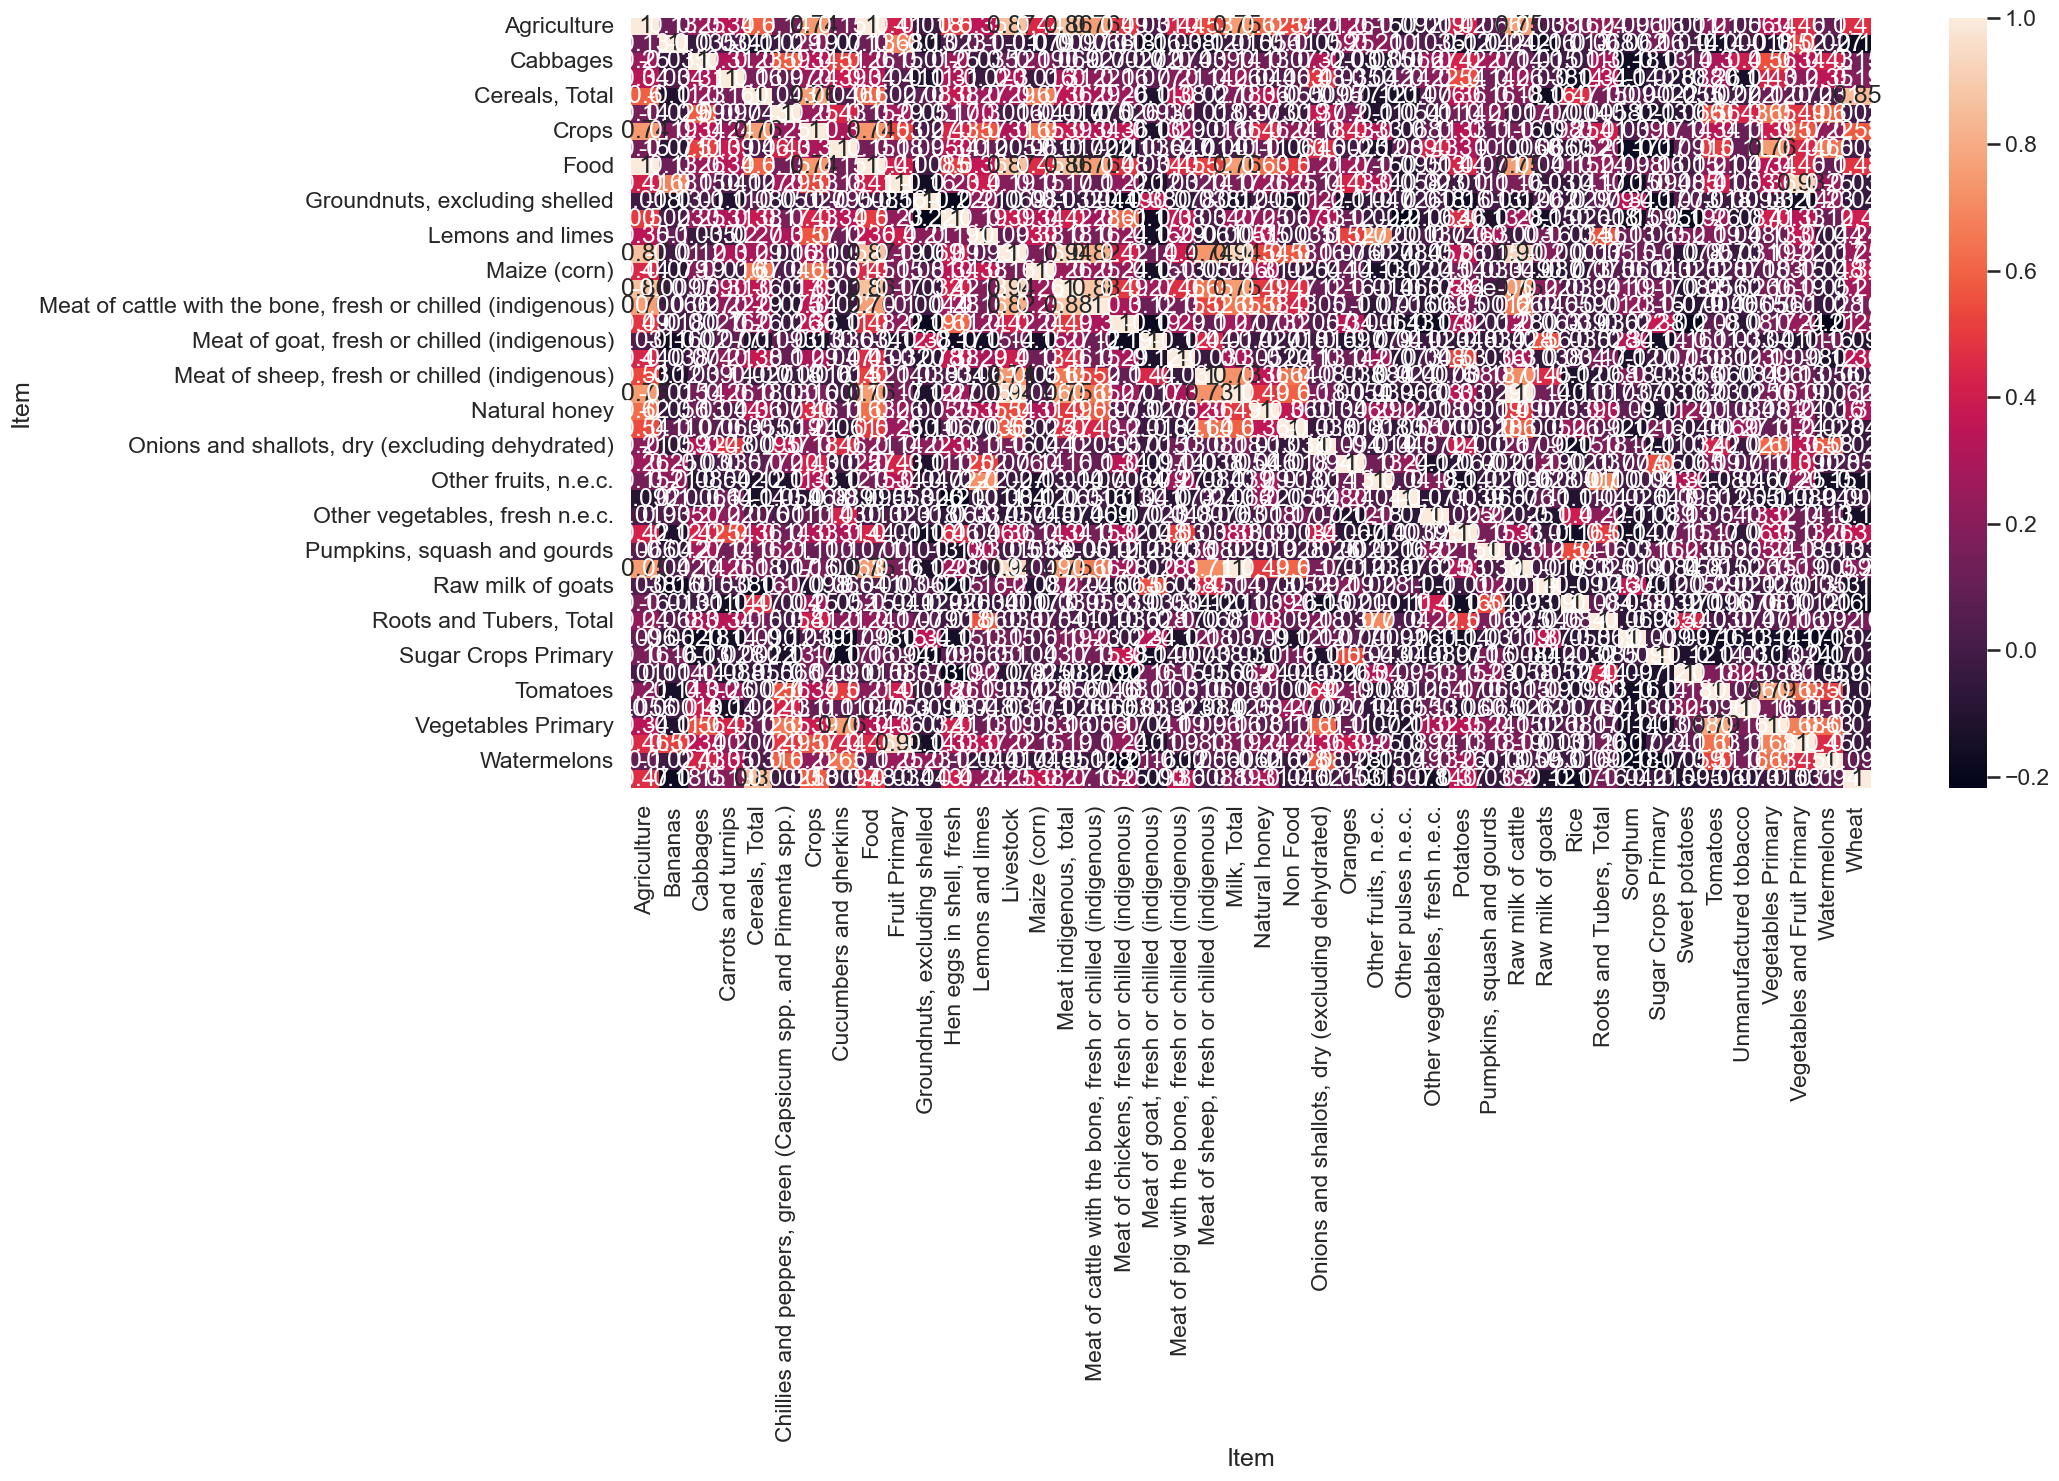

In [146]:
#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(prod_df.corr(),annot = True)
plt.show()

In [150]:
#featurewiz does not work for clustering or unsupervised problems
#pip install featurewiz --user

In [151]:
prod_df.fillna(0, inplace=True)

In [152]:
prod_df.set_index('Area', inplace=True)
prod_df.head()

Item                 Agriculture    Bananas  Cabbages  Carrots and turnips  \
Area                                                                         
Afghanistan           174.078401   0.000000  0.000000             0.000000   
Albania               736.821228   0.000000  5.575036             1.305203   
Algeria               364.737754   0.002014  0.620344             2.715115   
Angola                190.689824  44.369762  2.378747             0.000000   
Antigua and Barbuda    92.230533   0.575355  0.173692             0.553644   

Item                 Cereals, Total  \
Area                                  
Afghanistan               36.263282   
Albania                   49.112995   
Algeria                   29.452386   
Angola                    18.371780   
Antigua and Barbuda        0.108558   

Item                 Chillies and peppers, green (Capsicum spp. and Pimenta spp.)  \
Area                                                                                
Afghanistan                                                   0.000000              
Albania                                                      19.863717              
Algeria                                                      10.610352              
Angola                                                        0.000000              
Antigua and Barbuda                                           0.542788              

Item                      Crops  Cucumbers and gherkins        Food  \
Area                                                                  
Afghanistan          116.927365                0.000000  170.163867   
Albania              438.875208               16.485013  731.203045   
Algeria              252.020542                1.454641  360.776659   
Angola               154.329529                0.000000  188.052620   
Antigua and Barbuda   67.164584                0.325673   91.199236   

Item                 Fruit Primary  ...  Roots and Tubers, Total   Sorghum  \
Area                                ...                                      
Afghanistan              49.876860  ...                 6.103549  0.000000   
Albania                 155.545650  ...                22.699254  0.000000   
Algeria                  85.487778  ...                29.420493  0.004707   
Angola                   57.580569  ...                54.670691  0.216576   
Antigua and Barbuda      58.306284  ...                 1.107287  0.000000   

Item                 Sugar Crops Primary  Sweet potatoes   Tomatoes  \
Area                                                                  
Afghanistan                     0.054991        0.000000   0.000000   
Albania                         0.503500        0.000000  49.646071   
Algeria                         0.000000        0.000000  16.476664   
Angola                          1.040472       10.732844   0.245970   
Antigua and Barbuda             0.000000        0.401663   1.541518   

Item                 Unmanufactured tobacco  Vegetables Primary  \
Area                                                              
Afghanistan                        0.000000           12.133944   
Albania                            1.093294          151.655095   
Algeria                            0.795263           73.969390   
Angola                             0.201152            6.316054   
Antigua and Barbuda                0.000000            6.622013   

Item                 Vegetables and Fruit Primary  Watermelons      Wheat  
Area                                                                       
Afghanistan                             62.010804     5.202902  30.662361  
Albania                                307.200398    20.965711  19.218945  
Algeria                                159.457167    11.989523  21.499944  
Angola                                  63.896623     0.000000   0.021667  
Antigua and Barbuda                     64.928298     0.000000   0.000000  

[5 rows x 44 columns]

In [160]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns # data visualization library  
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [155]:
#https://www.kaggle.com/code/emilytries/clustering-and-feature-selection
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    
for col in prod_df.columns:
    replace_with_thresholds(prod_df, col)

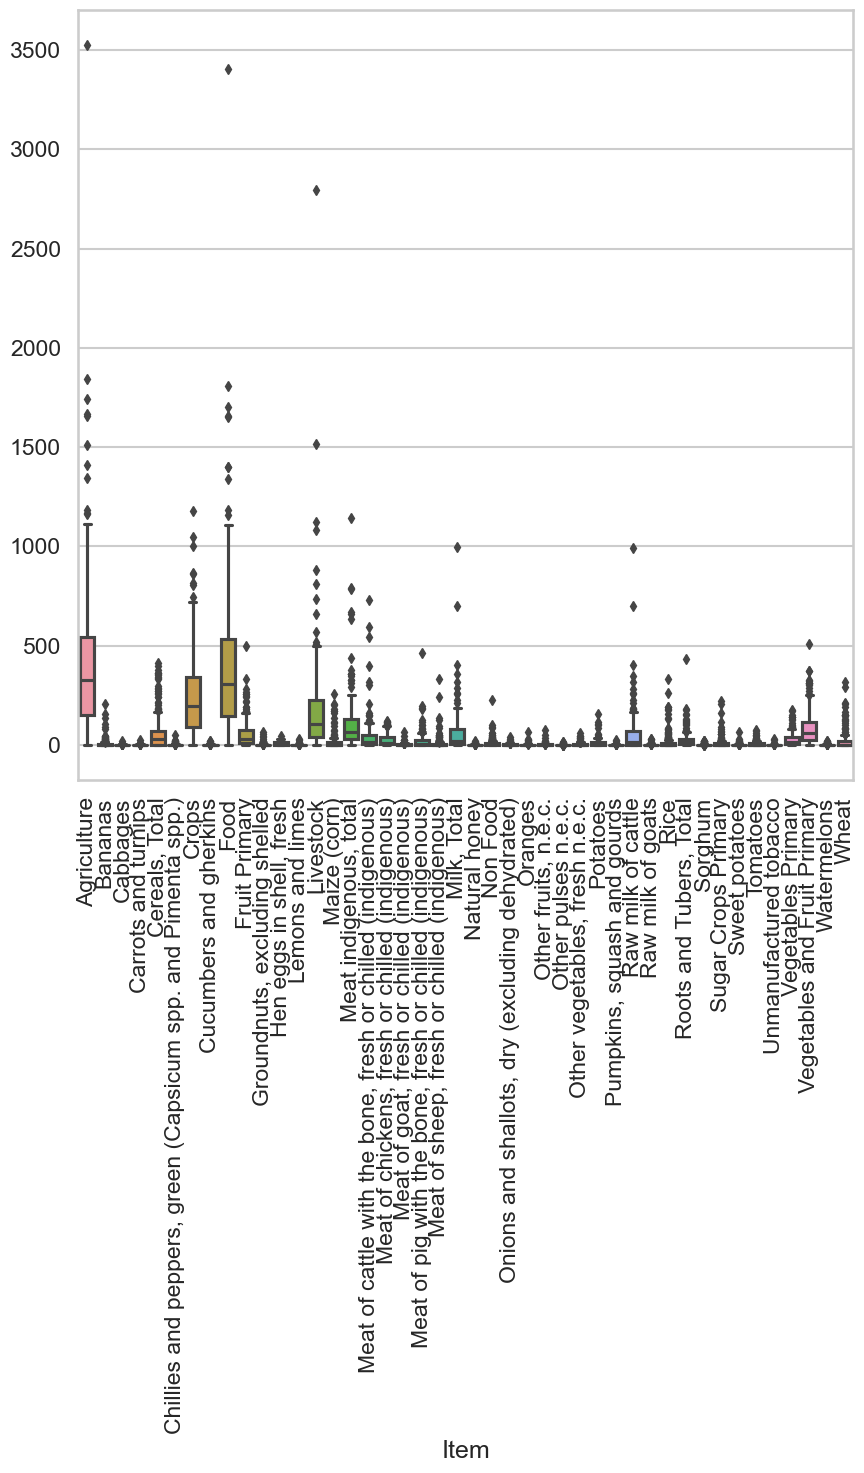

In [156]:
plt.figure(figsize=(10,10))
sns.boxplot(data=prod_df)
plt.xticks(rotation=90)
plt.show()

In [162]:
# Min Max Scaler
names = prod_df.columns
indexes = prod_df.index
sc = MinMaxScaler((0, 1))
df = sc.fit_transform(prod_df)
data_scaled = pd.DataFrame(df, columns=names, index=indexes)
data_scaled.head()

Item                 Agriculture   Bananas  Cabbages  Carrots and turnips  \
Area                                                                        
Afghanistan             0.049370  0.000000  0.000000             0.000000   
Albania                 0.208970  0.000000  0.298259             0.056230   
Algeria                 0.103443  0.000010  0.033188             0.116970   
Angola                  0.054081  0.216533  0.127261             0.000000   
Antigua and Barbuda     0.026157  0.002808  0.009292             0.023852   

Item                 Cereals, Total  \
Area                                  
Afghanistan                0.087325   
Albania                    0.118268   
Algeria                    0.070924   
Angola                     0.044241   
Antigua and Barbuda        0.000261   

Item                 Chillies and peppers, green (Capsicum spp. and Pimenta spp.)  \
Area                                                                                
Afghanistan                                                   0.000000              
Albania                                                       0.378461              
Algeria                                                       0.202158              
Angola                                                        0.000000              
Antigua and Barbuda                                           0.010342              

Item                    Crops  Cucumbers and gherkins      Food  \
Area                                                              
Afghanistan          0.099333                0.000000  0.049941   
Albania              0.372838                0.890719  0.214597   
Algeria              0.214099                0.078597  0.105883   
Angola               0.131108                0.000000  0.055191   
Antigua and Barbuda  0.057058                0.017597  0.026766   

Item                 Fruit Primary  ...  Roots and Tubers, Total   Sorghum  \
Area                                ...                                      
Afghanistan               0.100151  ...                 0.014064  0.000000   
Albania                   0.312330  ...                 0.052303  0.000000   
Algeria                   0.171657  ...                 0.067790  0.000243   
Angola                    0.115620  ...                 0.125971  0.011160   
Antigua and Barbuda       0.117077  ...                 0.002551  0.000000   

Item                 Sugar Crops Primary  Sweet potatoes  Tomatoes  \
Area                                                                 
Afghanistan                     0.000250        0.000000  0.000000   
Albania                         0.002287        0.000000  0.677845   
Algeria                         0.000000        0.000000  0.224965   
Angola                          0.004726        0.162796  0.003358   
Antigua and Barbuda             0.000000        0.006092  0.021047   

Item                 Unmanufactured tobacco  Vegetables Primary  \
Area                                                              
Afghanistan                        0.000000            0.068742   
Albania                            0.039340            0.859169   
Algeria                            0.028616            0.419057   
Angola                             0.007238            0.035782   
Antigua and Barbuda                0.000000            0.037516   

Item                 Vegetables and Fruit Primary  Watermelons     Wheat  
Area                                                                      
Afghanistan                              0.121600     0.248162  0.095964  
Albania                                  0.602402     1.000000  0.060149  
Algeria                                  0.312686     0.571863  0.067288  
Angola                                   0.125298     0.000000  0.000068  
Antigua and Barbuda                      0.127321     0.000000  0.000000  

[5 rows x 44 columns]

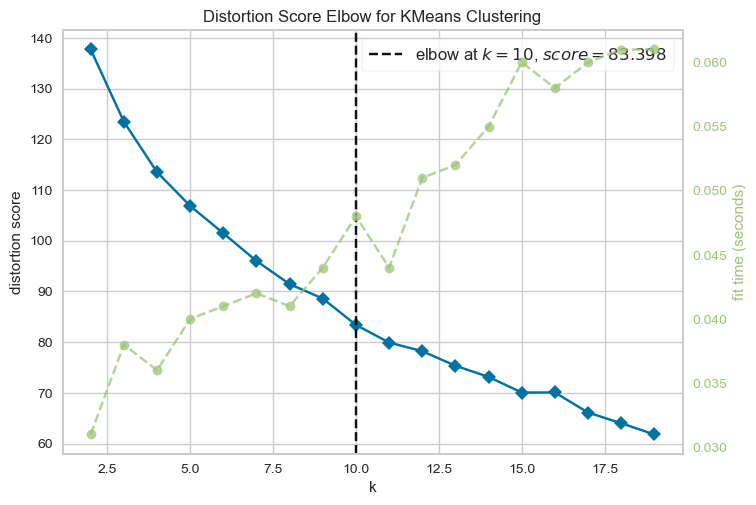

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [163]:
# KMeans Clustering
kmeans = KMeans()
ssd = []
K = range(1, 44)

for k in K:
    kmeans = KMeans(n_clusters=k).fit(data_scaled)
    ssd.append(kmeans.inertia_)

ssd

plt.plot(K, ssd, "bx-")
plt.xlabel("Distance Residual Sums for K Values (WCSS)")
plt.title("Elbow Method for Optimum Number of Clusters")
plt.show()

kmeans = KMeans()
visu = KElbowVisualizer(kmeans, k=(2, 20))
visu.fit(df)
visu.show()

In [165]:
kmeans = KMeans(n_clusters=10).fit(data_scaled)
clusters = kmeans.labels_

pd.DataFrame({"Customers": prod_df.index, "Clusters": clusters})
prod_df["cluster_no"] = clusters
prod_df.head()

Item                 Agriculture    Bananas  Cabbages  Carrots and turnips  \
Area                                                                         
Afghanistan           174.078401   0.000000  0.000000             0.000000   
Albania               736.821228   0.000000  5.575036             1.305203   
Algeria               364.737754   0.002014  0.620344             2.715115   
Angola                190.689824  44.369762  2.378747             0.000000   
Antigua and Barbuda    92.230533   0.575355  0.173692             0.553644   

Item                 Cereals, Total  \
Area                                  
Afghanistan               36.263282   
Albania                   49.112995   
Algeria                   29.452386   
Angola                    18.371780   
Antigua and Barbuda        0.108558   

Item                 Chillies and peppers, green (Capsicum spp. and Pimenta spp.)  \
Area                                                                                
Afghanistan                                                   0.000000              
Albania                                                      19.863717              
Algeria                                                      10.610352              
Angola                                                        0.000000              
Antigua and Barbuda                                           0.542788              

Item                      Crops  Cucumbers and gherkins        Food  \
Area                                                                  
Afghanistan          116.927365                0.000000  170.163867   
Albania              438.875208               16.485013  731.203045   
Algeria              252.020542                1.454641  360.776659   
Angola               154.329529                0.000000  188.052620   
Antigua and Barbuda   67.164584                0.325673   91.199236   

Item                 Fruit Primary  ...   Sorghum  Sugar Crops Primary  \
Area                                ...                                  
Afghanistan              49.876860  ...  0.000000             0.054991   
Albania                 155.545650  ...  0.000000             0.503500   
Algeria                  85.487778  ...  0.004707             0.000000   
Angola                   57.580569  ...  0.216576             1.040472   
Antigua and Barbuda      58.306284  ...  0.000000             0.000000   

Item                 Sweet potatoes   Tomatoes  Unmanufactured tobacco  \
Area                                                                     
Afghanistan                0.000000   0.000000                0.000000   
Albania                    0.000000  49.646071                1.093294   
Algeria                    0.000000  16.476664                0.795263   
Angola                    10.732844   0.245970                0.201152   
Antigua and Barbuda        0.401663   1.541518                0.000000   

Item                 Vegetables Primary  Vegetables and Fruit Primary  \
Area                                                                    
Afghanistan                   12.133944                     62.010804   
Albania                      151.655095                    307.200398   
Algeria                       73.969390                    159.457167   
Angola                         6.316054                     63.896623   
Antigua and Barbuda            6.622013                     64.928298   

Item                 Watermelons      Wheat  cluster_no  
Area                                                     
Afghanistan             5.202902  30.662361           6  
Albania                20.965711  19.218945           7  
Algeria                11.989523  21.499944           7  
Angola                  0.000000   0.021667           6  
Antigua and Barbuda     0.000000   0.000000           6  

[5 rows x 45 columns]

In [166]:
prod_df["cluster_no"] = prod_df["cluster_no"] + 1
prod_df.groupby("cluster_no").agg({"cluster_no": "count"})

Item        cluster_no
cluster_no            
1                   13
2                   39
3                   16
4                   14
5                   10
6                   11
7                   86
8                   17
9                    4
10                   1

In [167]:
prod_df.groupby("cluster_no").agg(np.mean)

Item        Agriculture    Bananas  Cabbages  Carrots and turnips  \
cluster_no                                                          
1            371.749009   3.474303  0.724162             0.607738   
2            343.436476   4.562825  1.364371             1.076612   
3            786.983735   0.071392  2.429800             3.561896   
4            418.952604   9.145503  1.367702             0.081421   
5           1116.235799   0.630490  2.735026             2.050429   
6            678.798210  75.870160  1.138895             1.342407   
7            161.191159   5.565318  0.330586             0.211290   
8            698.096667   0.723230  4.568208             5.120931   
9           1545.681850   3.955146  0.533683             2.104210   
10          3525.971994   0.000000  3.419618             4.233687   

Item        Cereals, Total  \
cluster_no                   
1                59.637115   
2                28.457872   
3               203.344240   
4               127.644912   
5               322.789529   
6                54.880517   
7                13.266043   
8                68.538792   
9               189.136459   
10               43.675442   

Item        Chillies and peppers, green (Capsicum spp. and Pimenta spp.)  \
cluster_no                                                                 
1                                                    1.155383              
2                                                    2.645035              
3                                                    0.555675              
4                                                    1.405758              
5                                                    4.009165              
6                                                    2.696651              
7                                                    0.373143              
8                                                   12.078044              
9                                                    0.937819              
10                                                   0.417622              

Item             Crops  Cucumbers and gherkins         Food  Fruit Primary  \
cluster_no                                                                   
1           211.963035                0.689790   357.383566      28.433099   
2           176.475911                2.161376   319.533083      50.846332   
3           373.509108                2.292028   782.989981      27.919105   
4           332.509877                0.733394   393.060765      49.191998   
5           782.357913                2.421703  1104.886771     103.445928   
6           516.025358                0.979273   663.309373     236.577742   
7           105.302358                0.158507   154.311405      24.754060   
8           426.596065                8.621464   671.732415     115.860173   
9           547.913550                0.089352  1489.736653      58.320634   
10          402.917988                0.043960  3407.324693     258.049854   

Item        ...  Roots and Tubers, Total    Sorghum  Sugar Crops Primary  \
cluster_no  ...                                                            
1           ...                26.089945  11.457458             4.145892   
2           ...                10.702604   0.495787            13.308598   
3           ...                41.972749   0.152357            13.679122   
4           ...                43.931244   0.189317            15.288012   
5           ...                34.642667   2.579144            10.804799   
6           ...                65.333181   0.843691            38.368586   
7           ...                19.175239   0.594745             4.021390   
8           ...                28.981641   0.089264             2.858587   
9           ...                15.368818   5.467570            55.631005   
10          ...                26.762470   0.000000             0.000000   

Item        Sweet potatoes   Tomatoes  Unmanufa

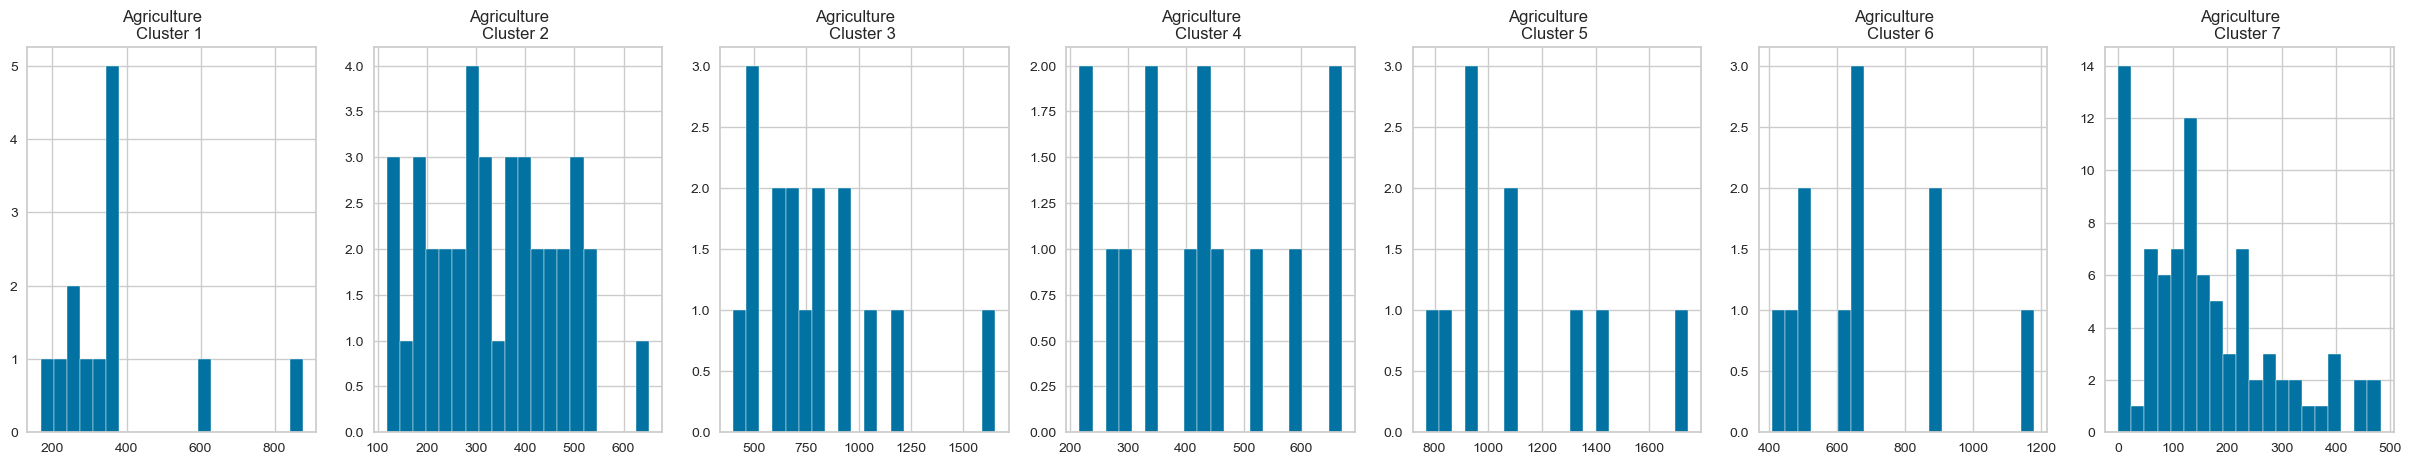

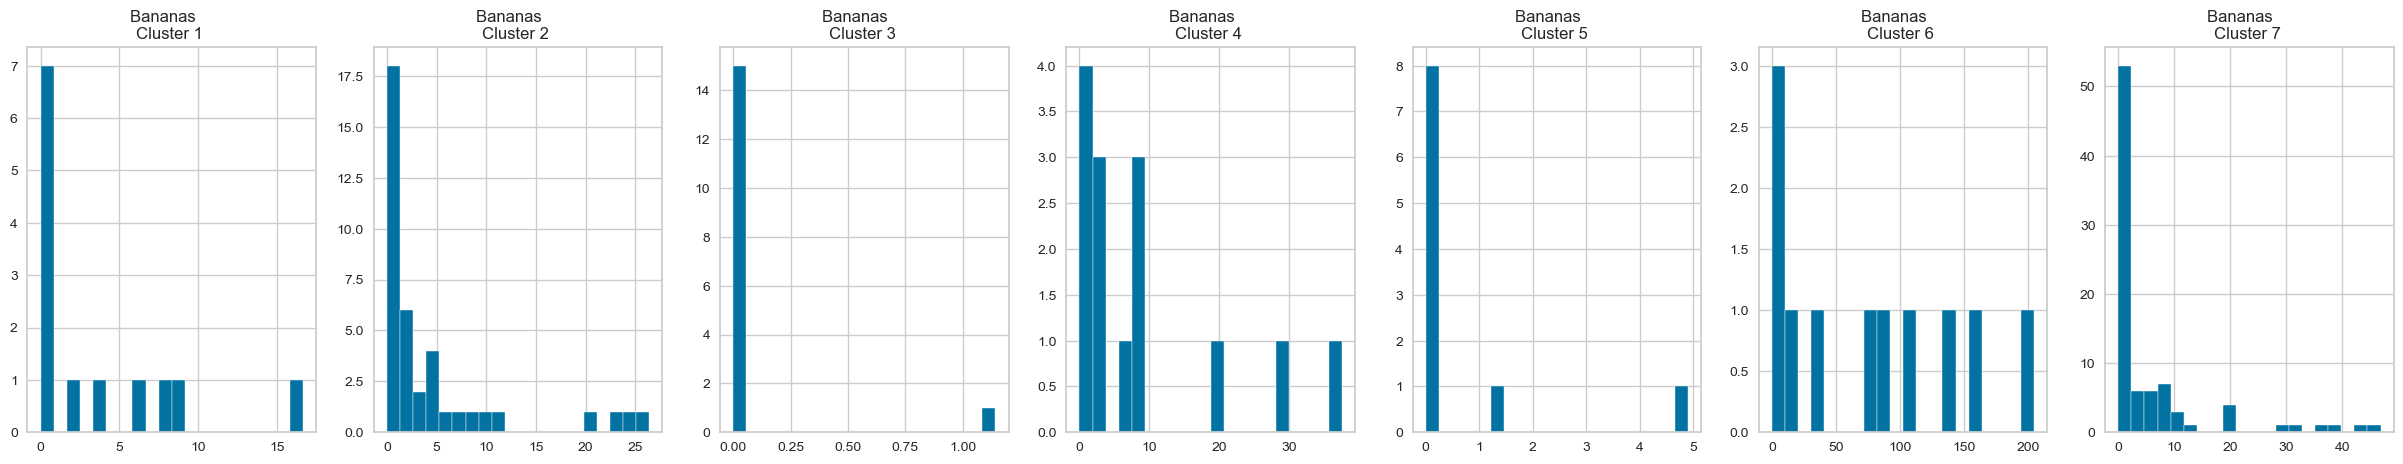

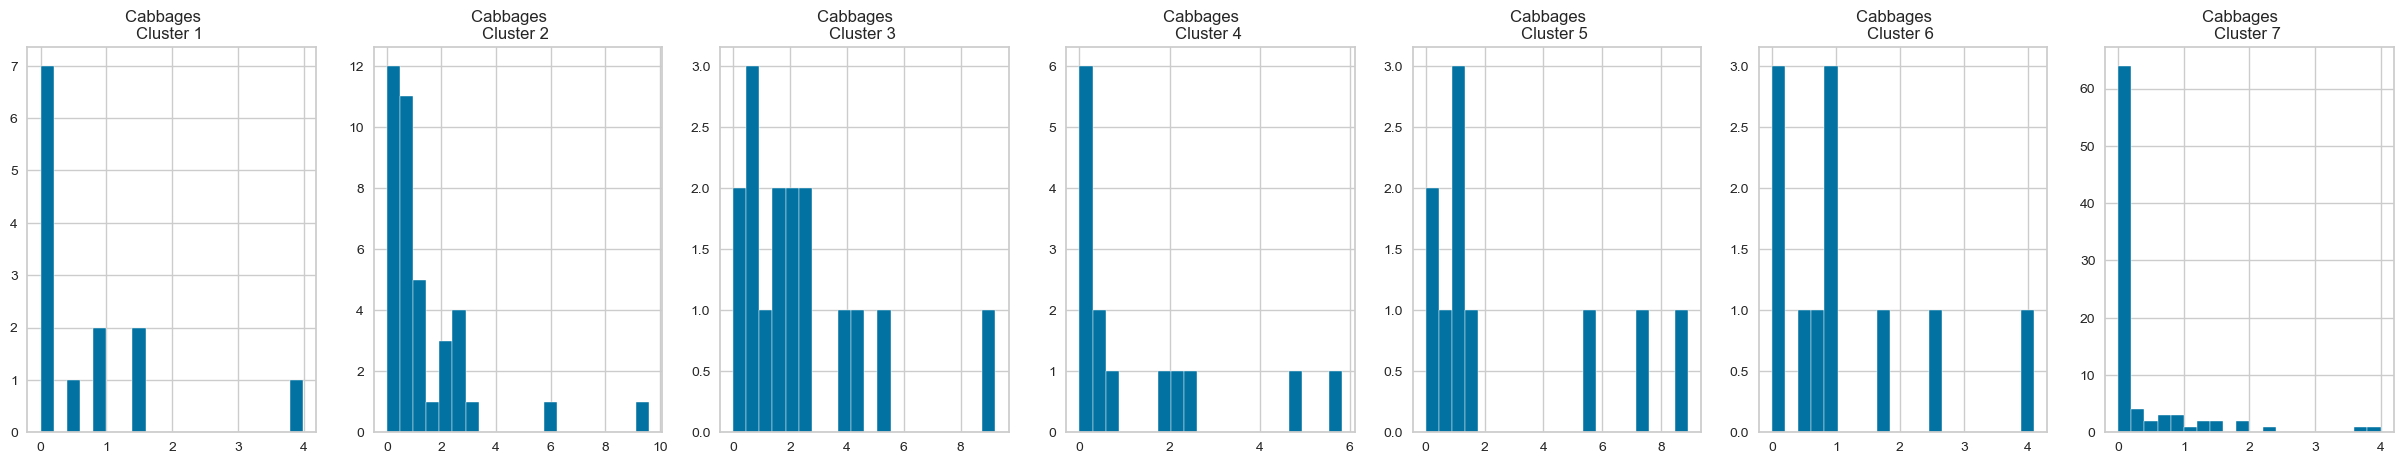

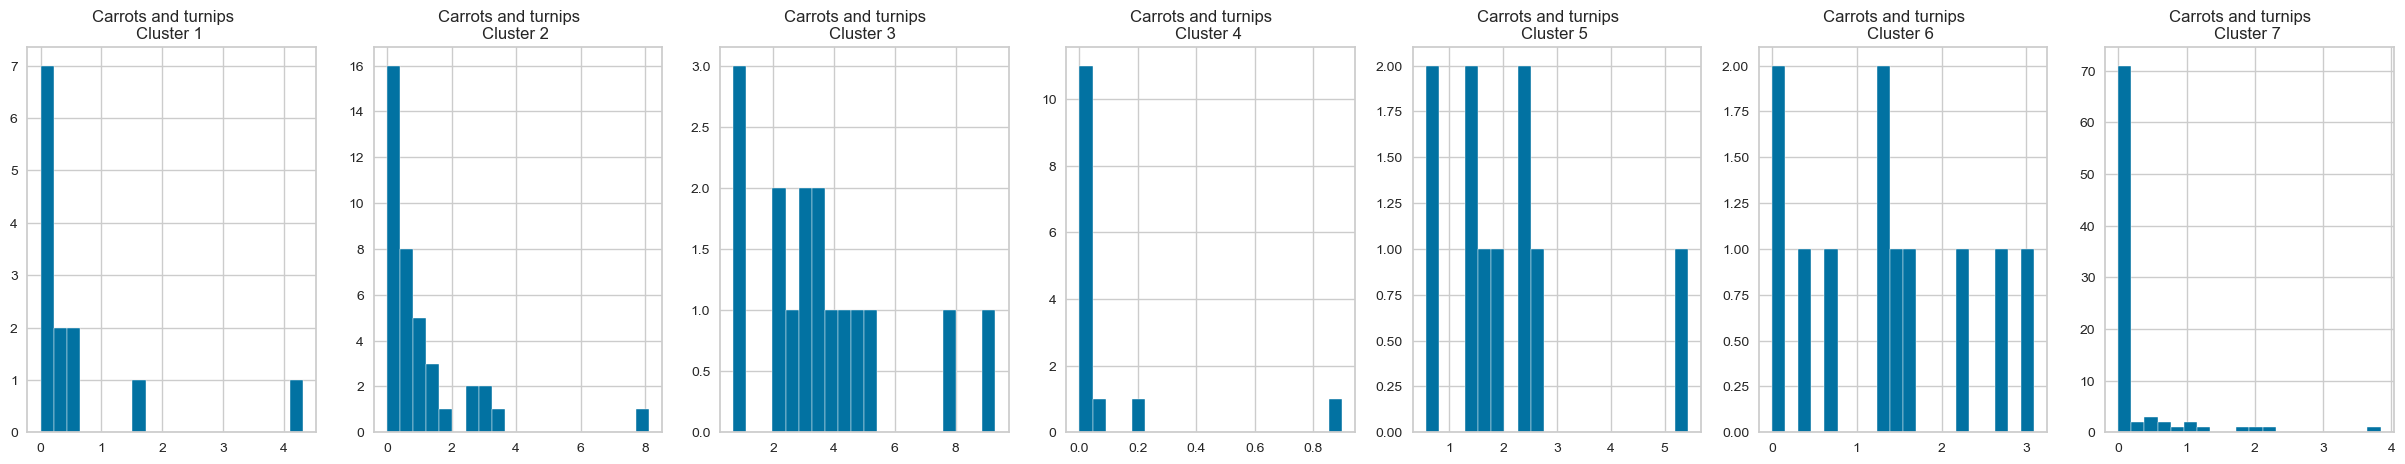

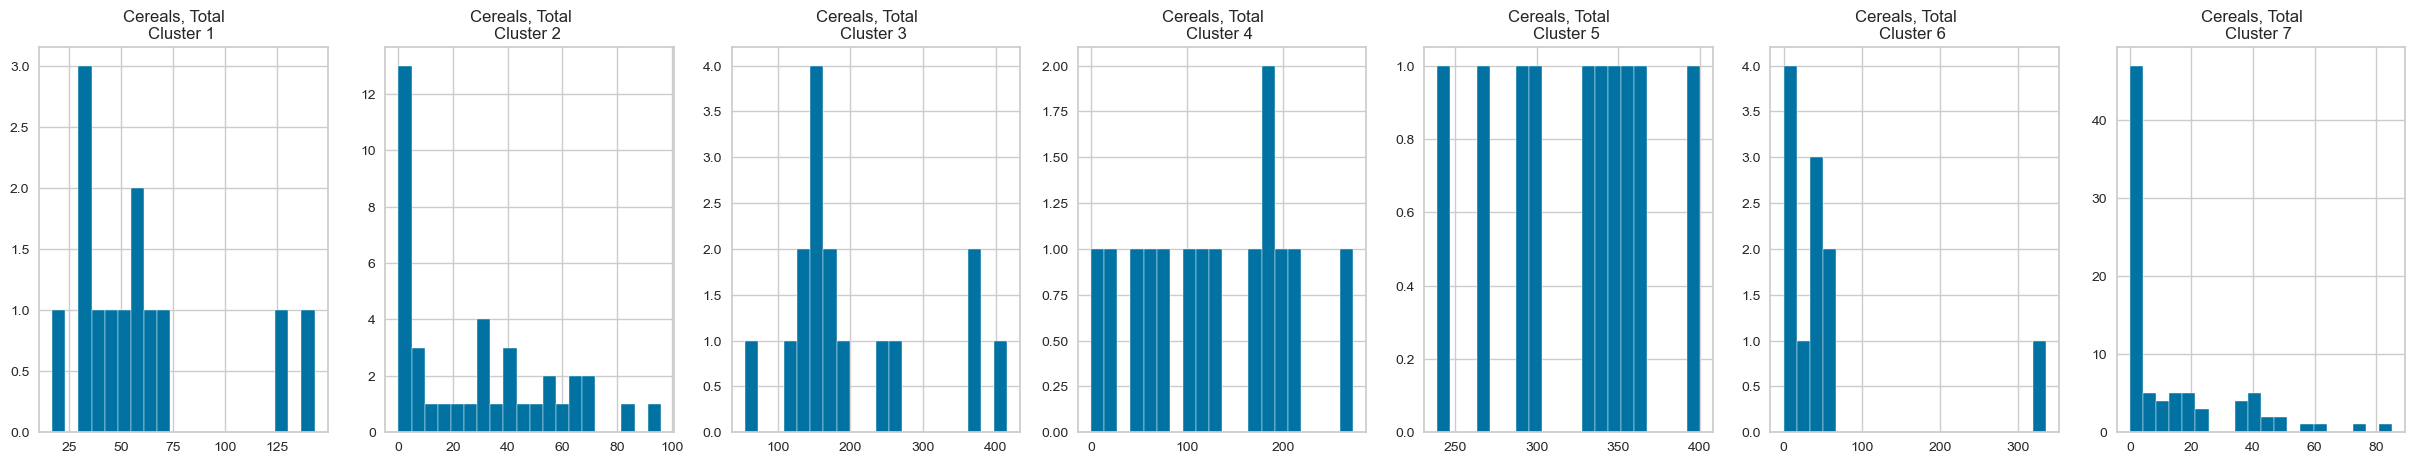

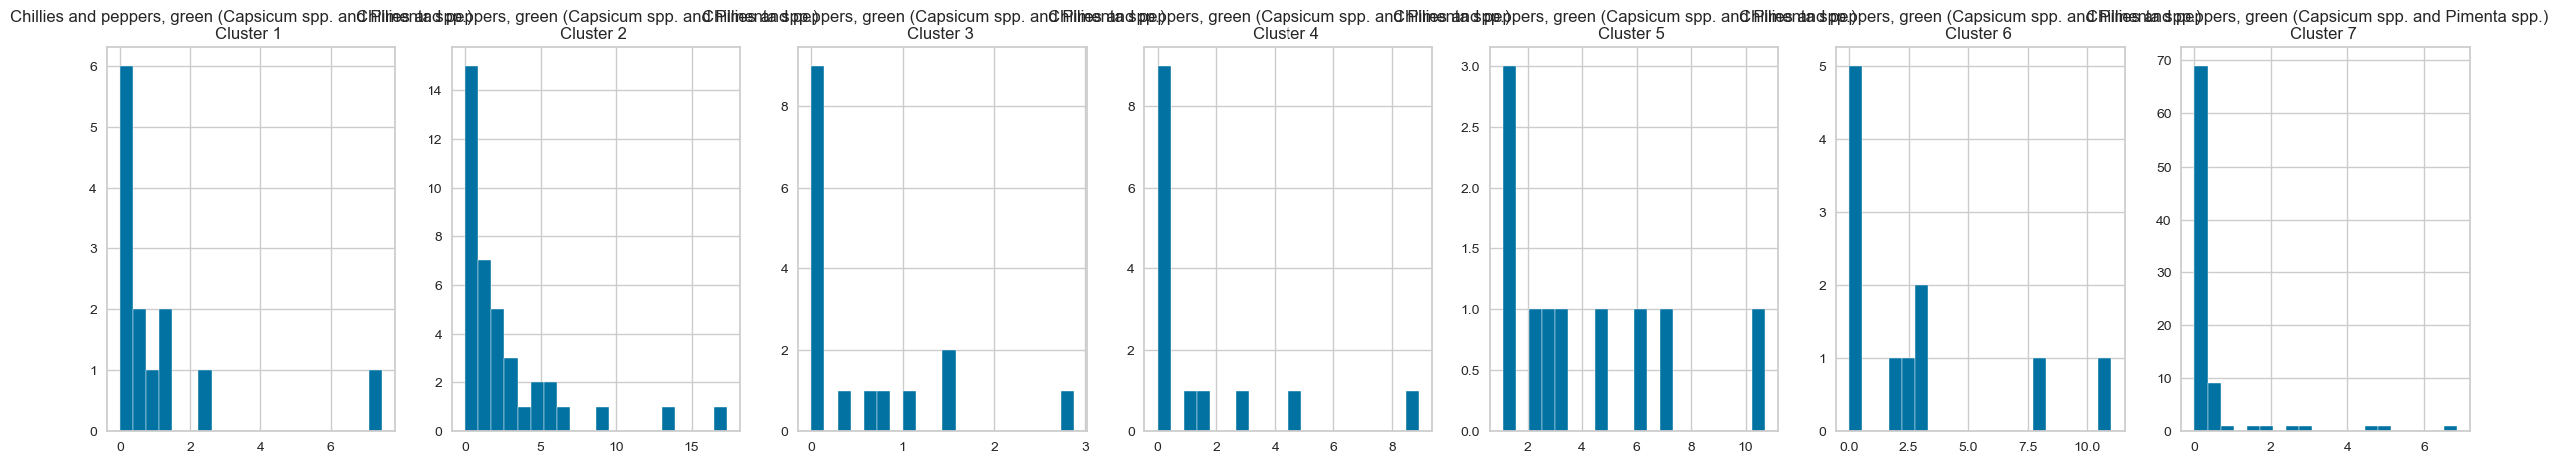

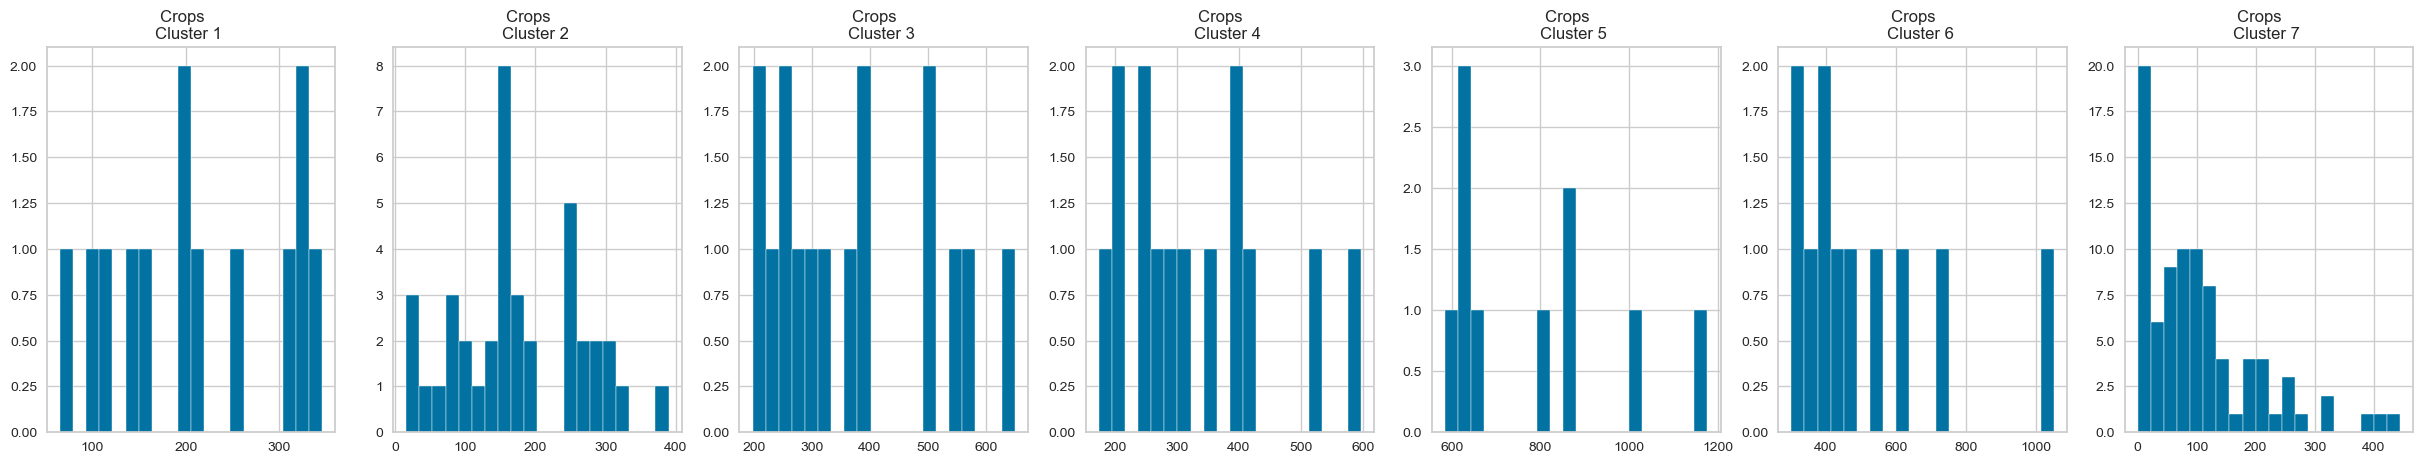

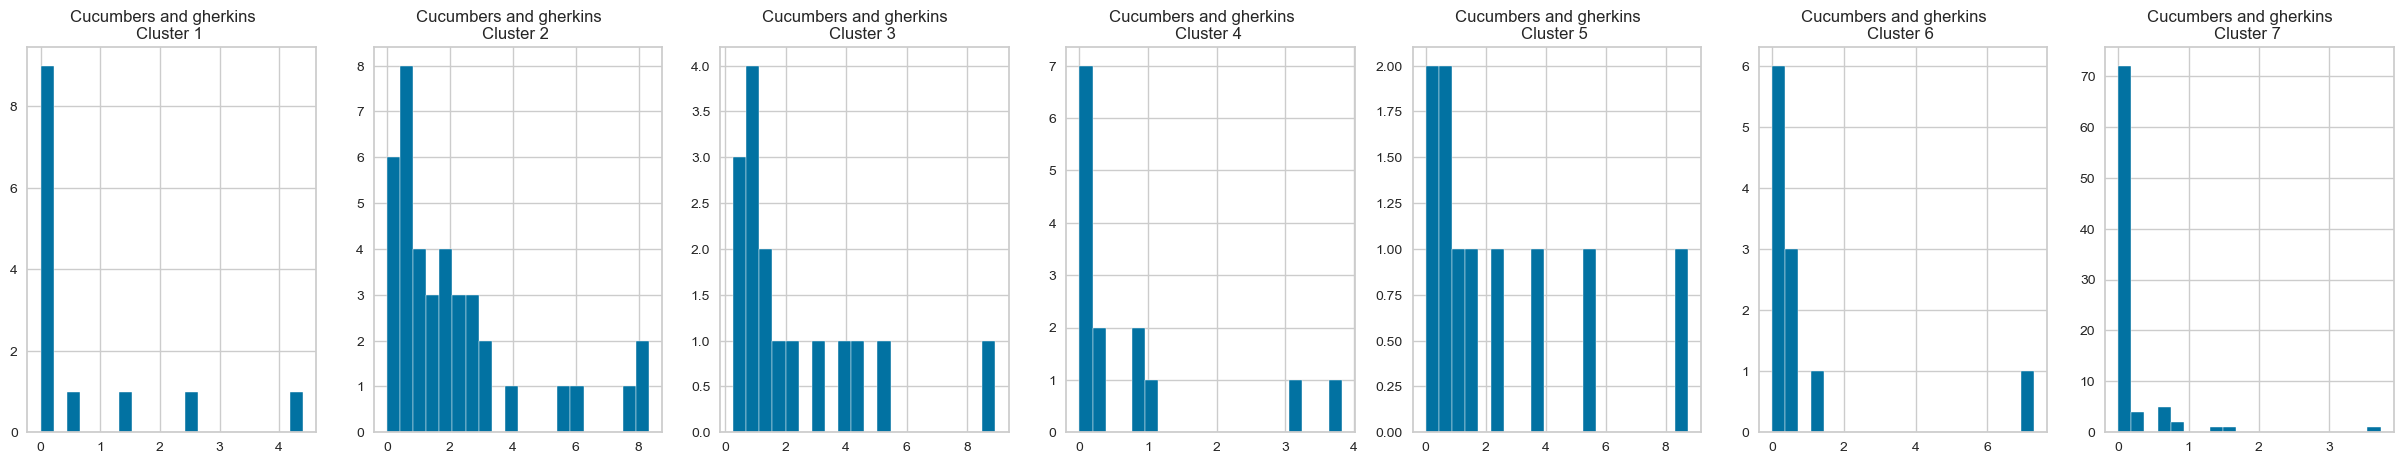

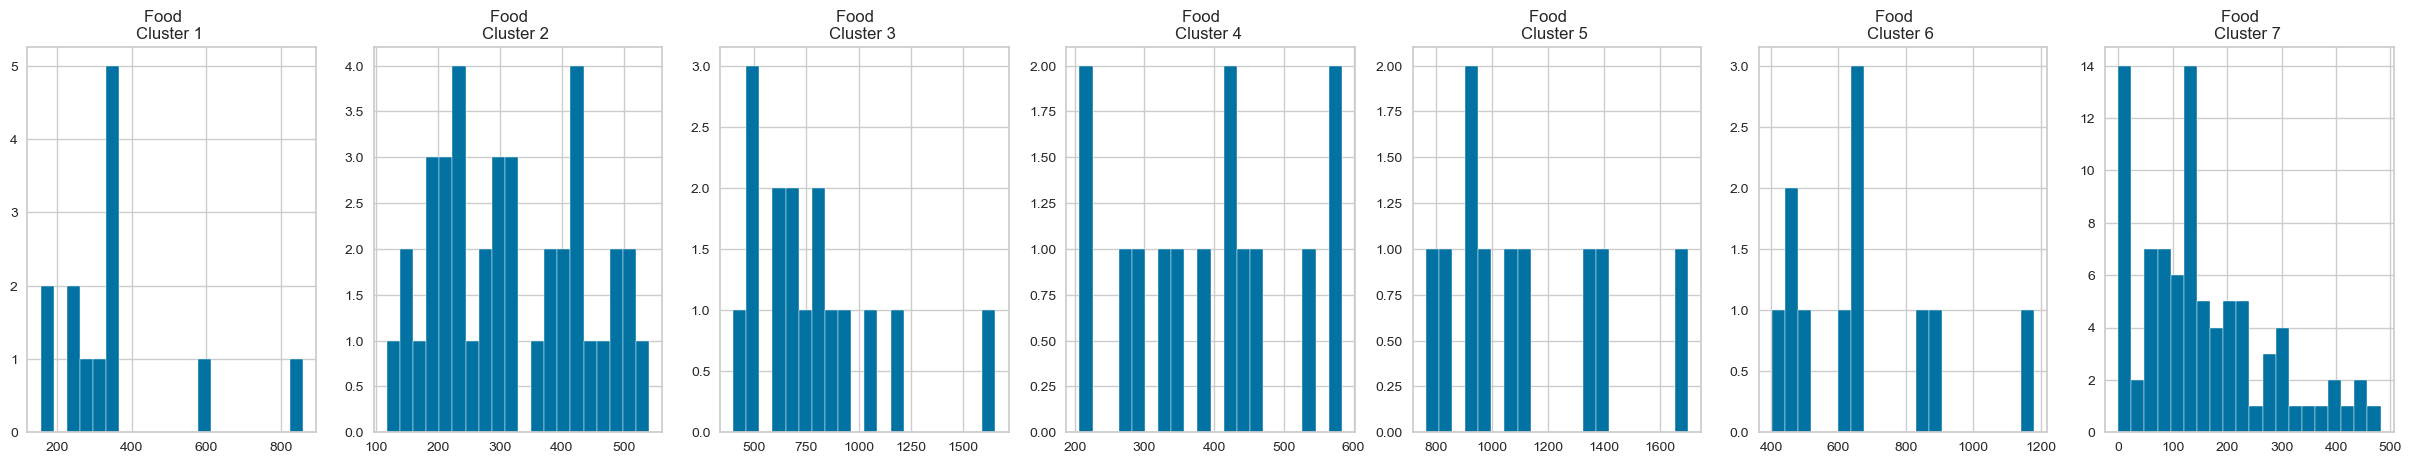

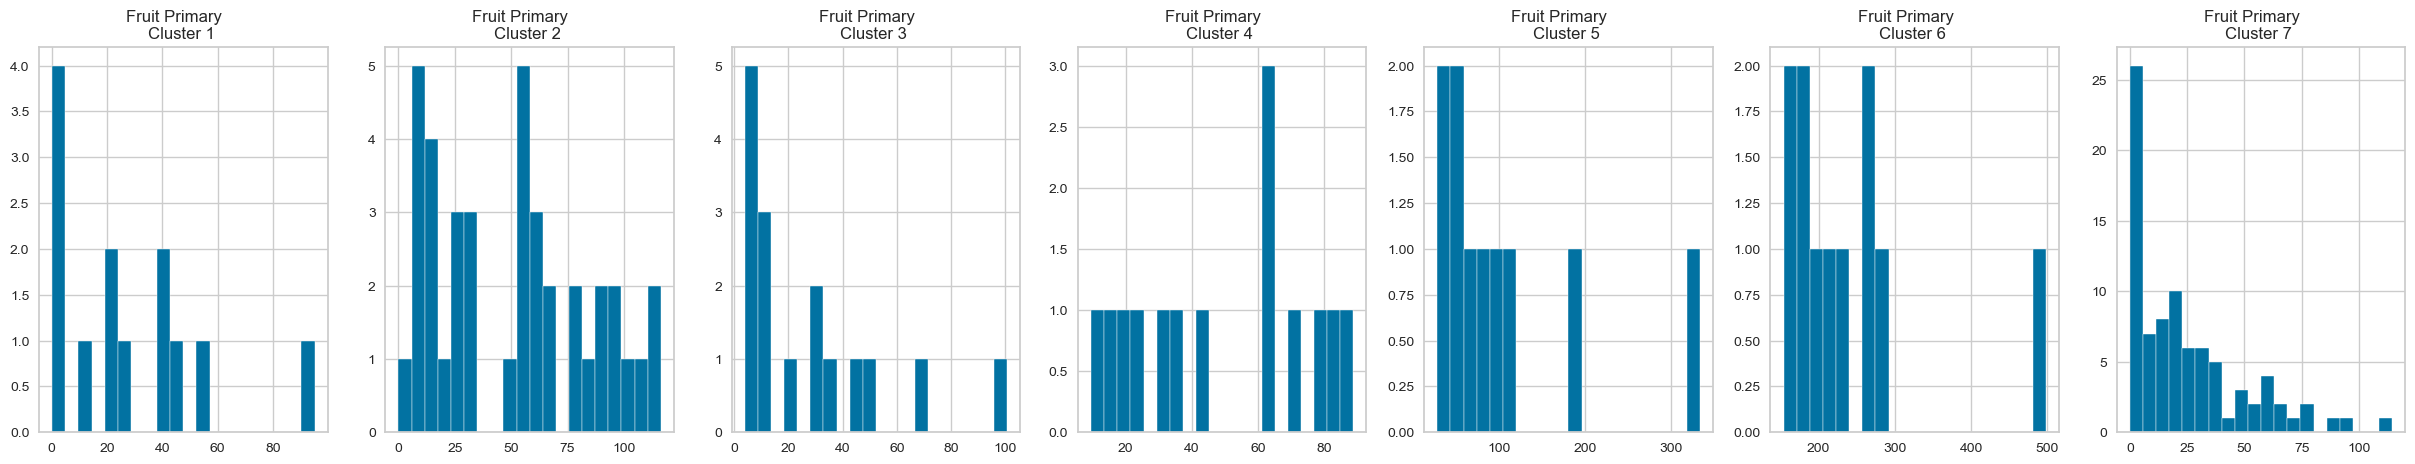

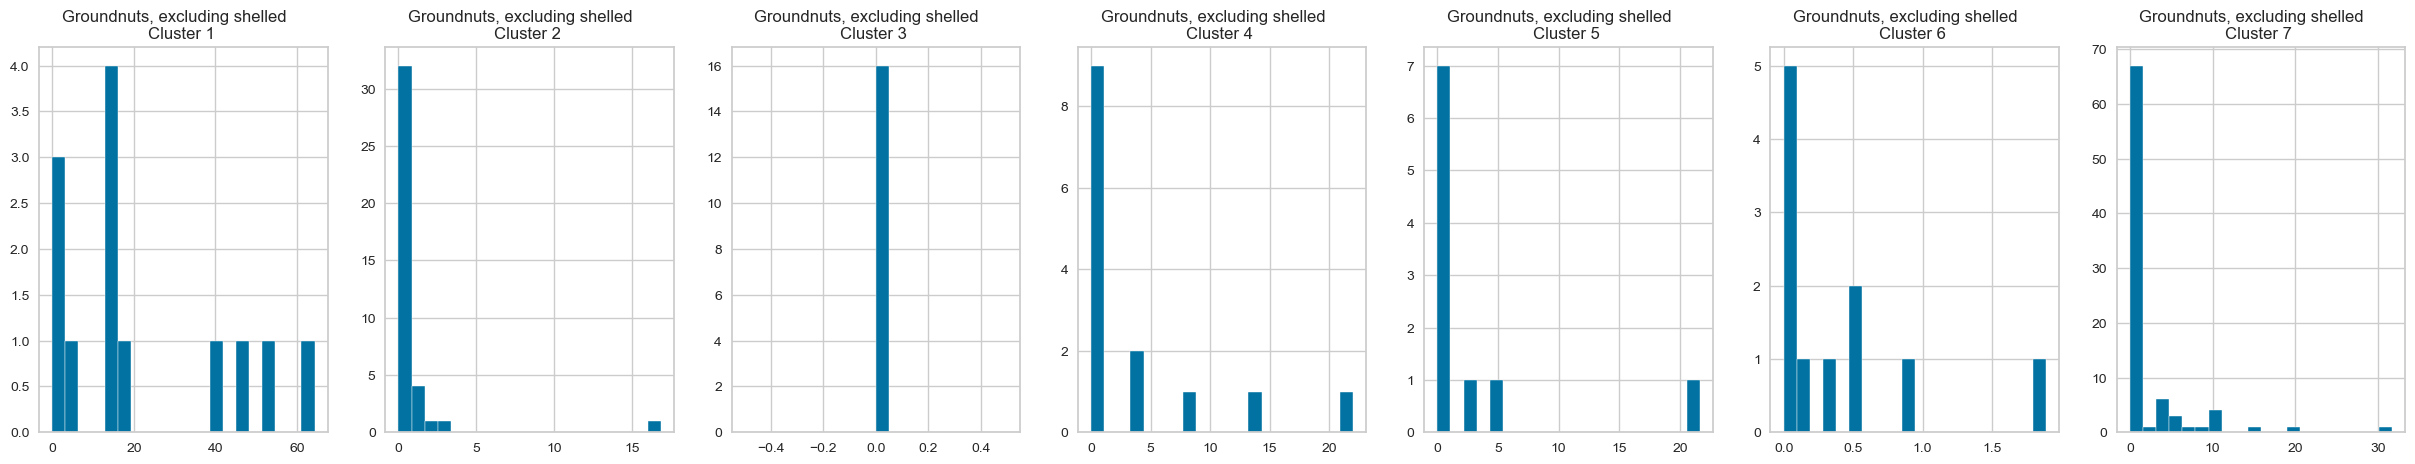

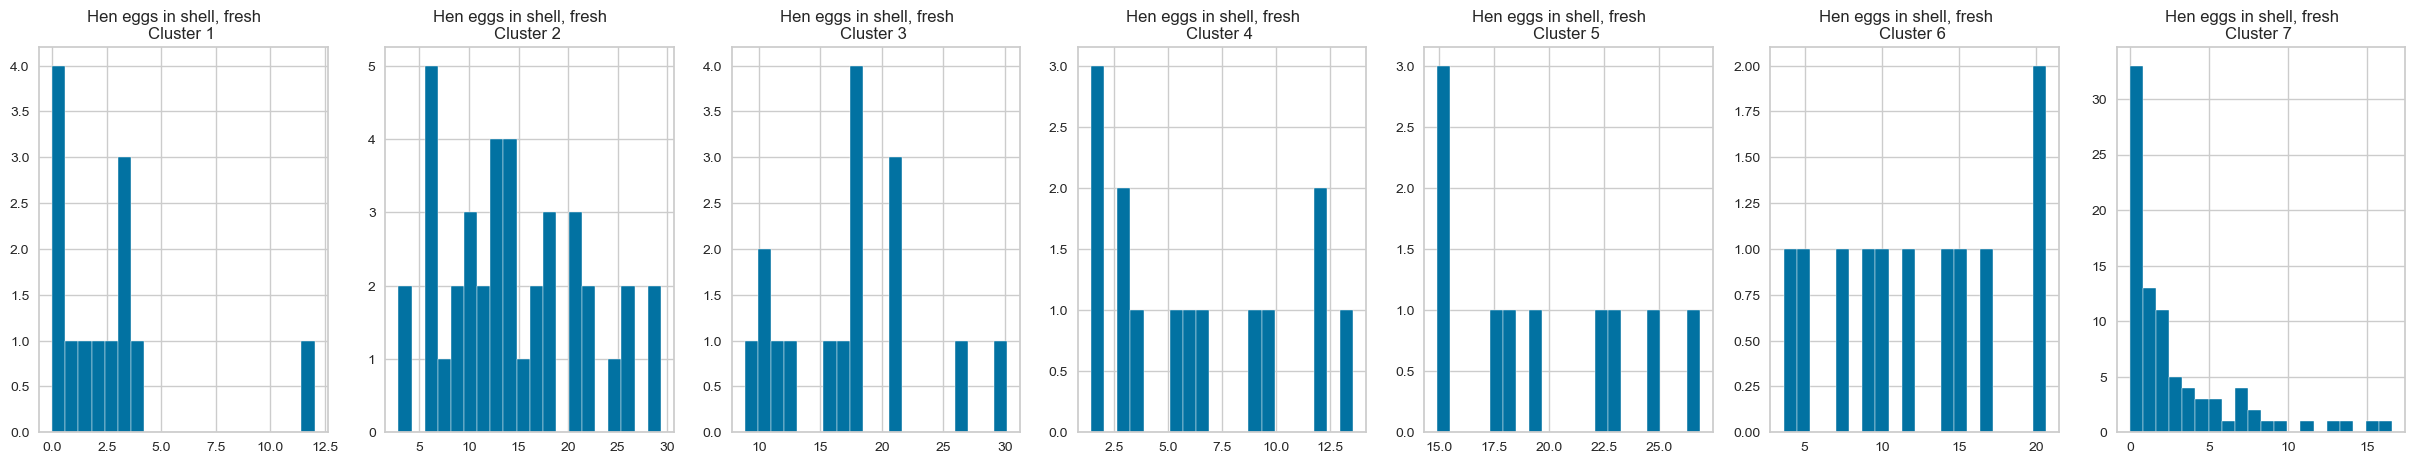

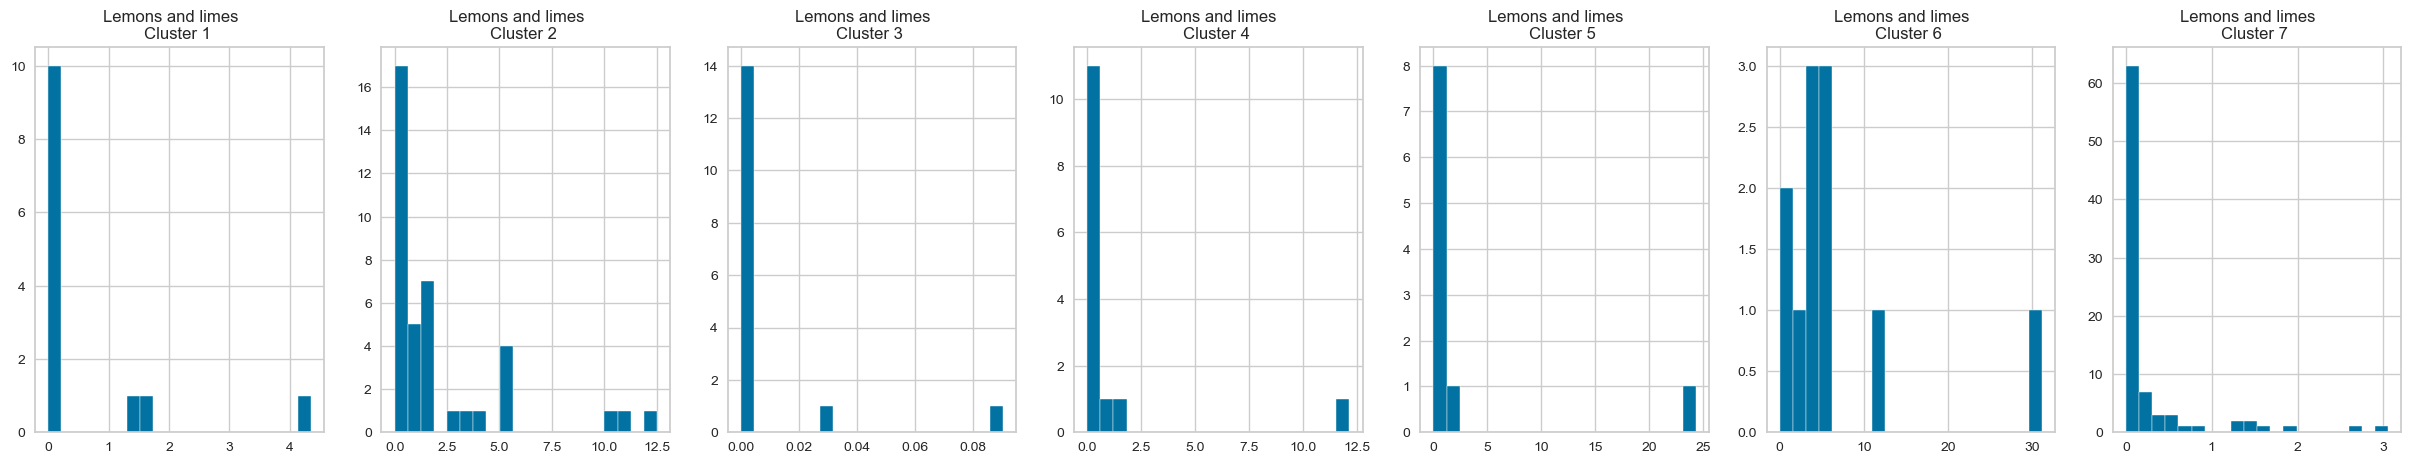

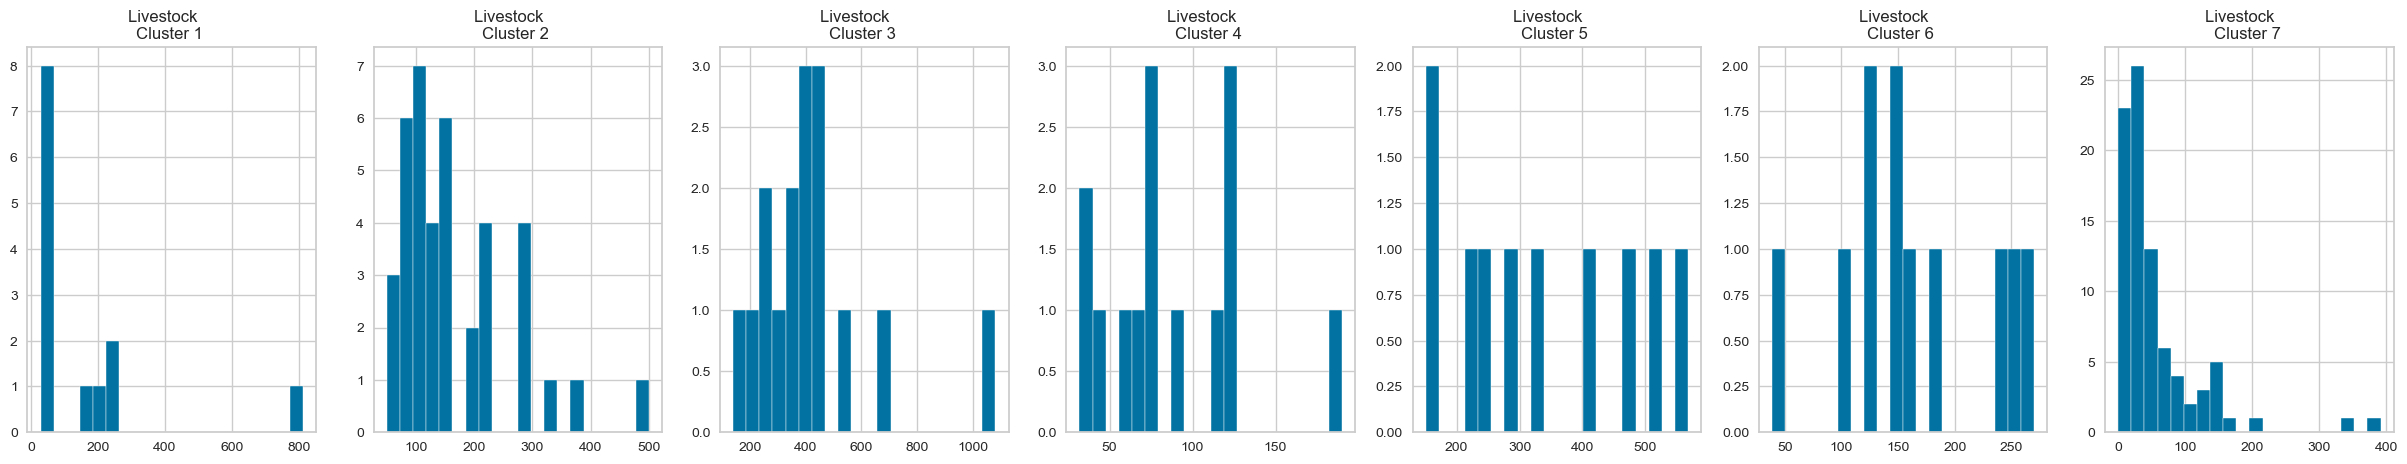

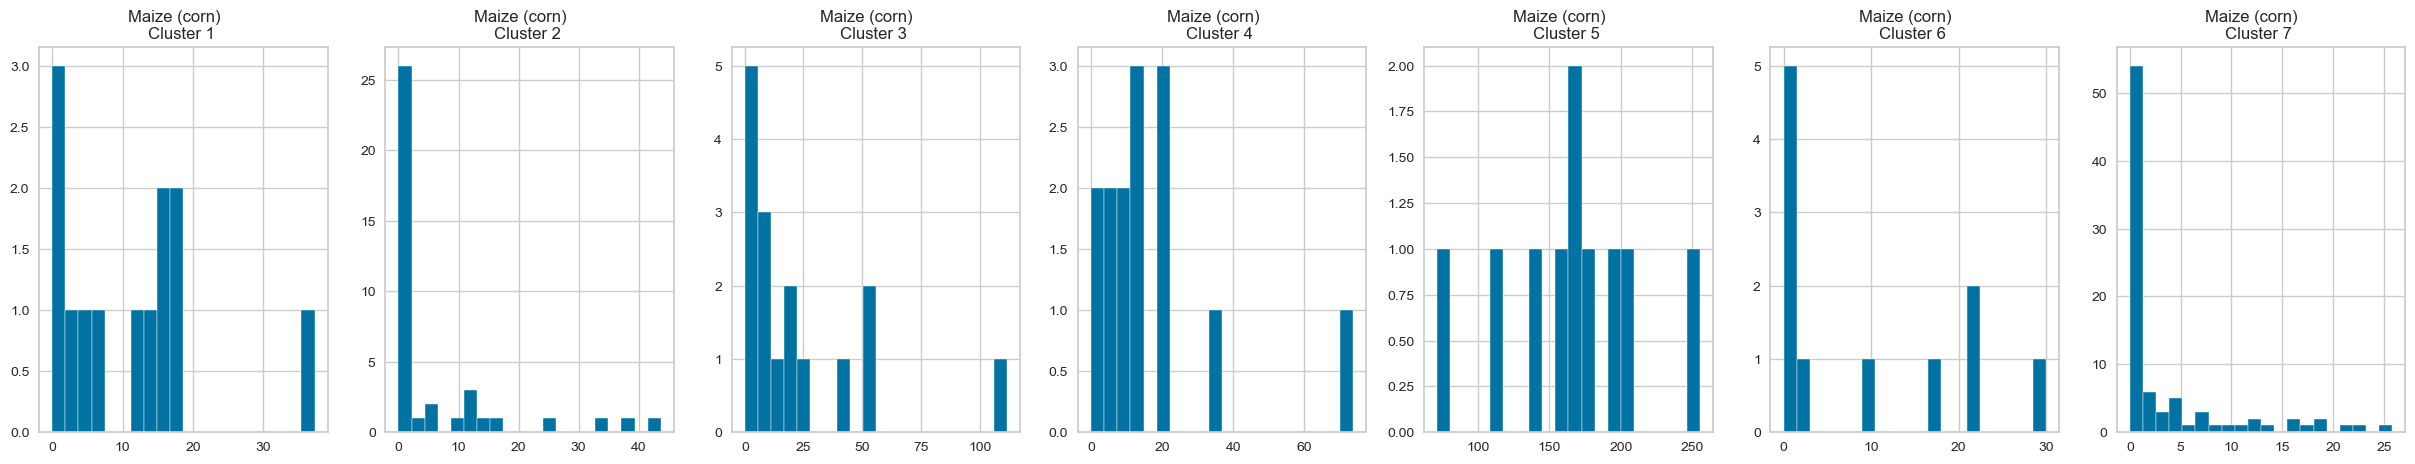

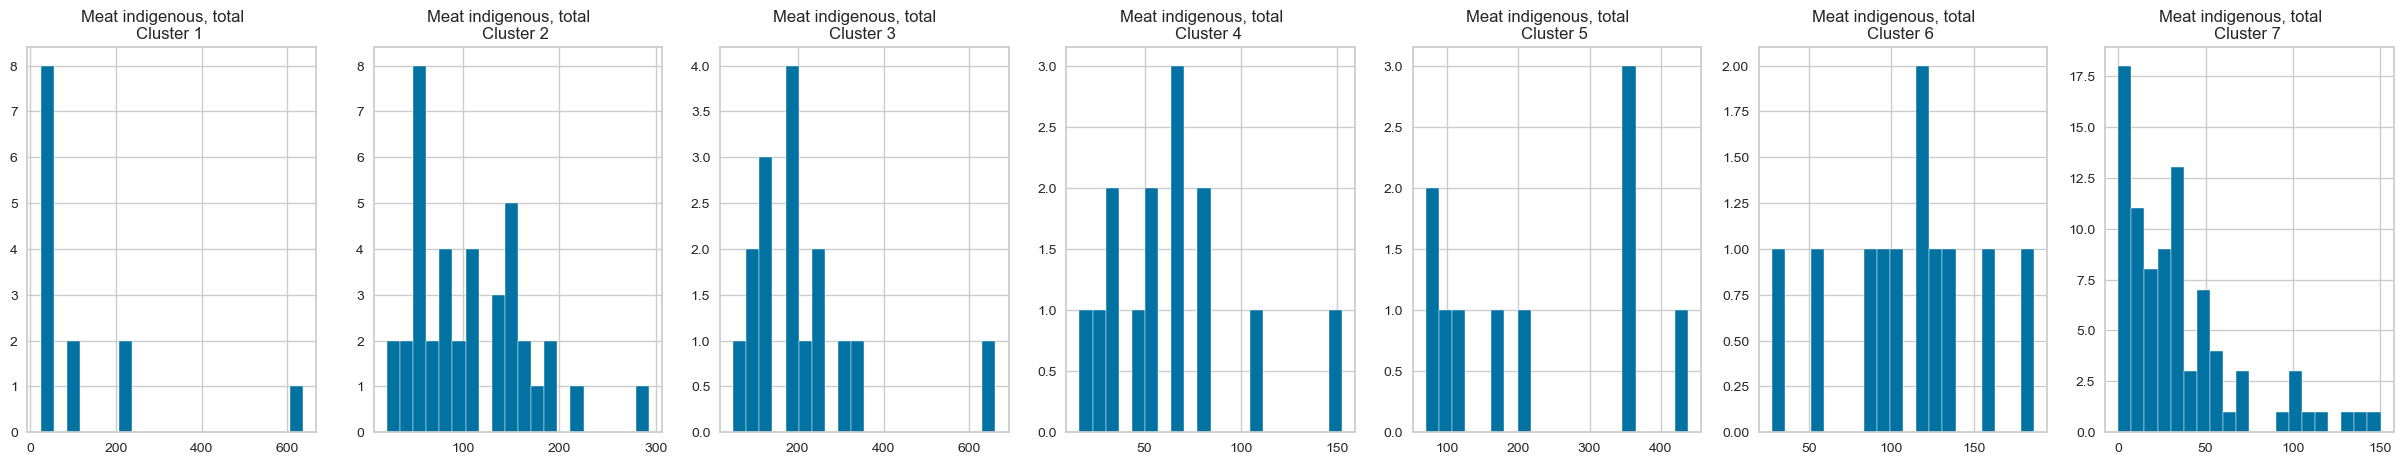

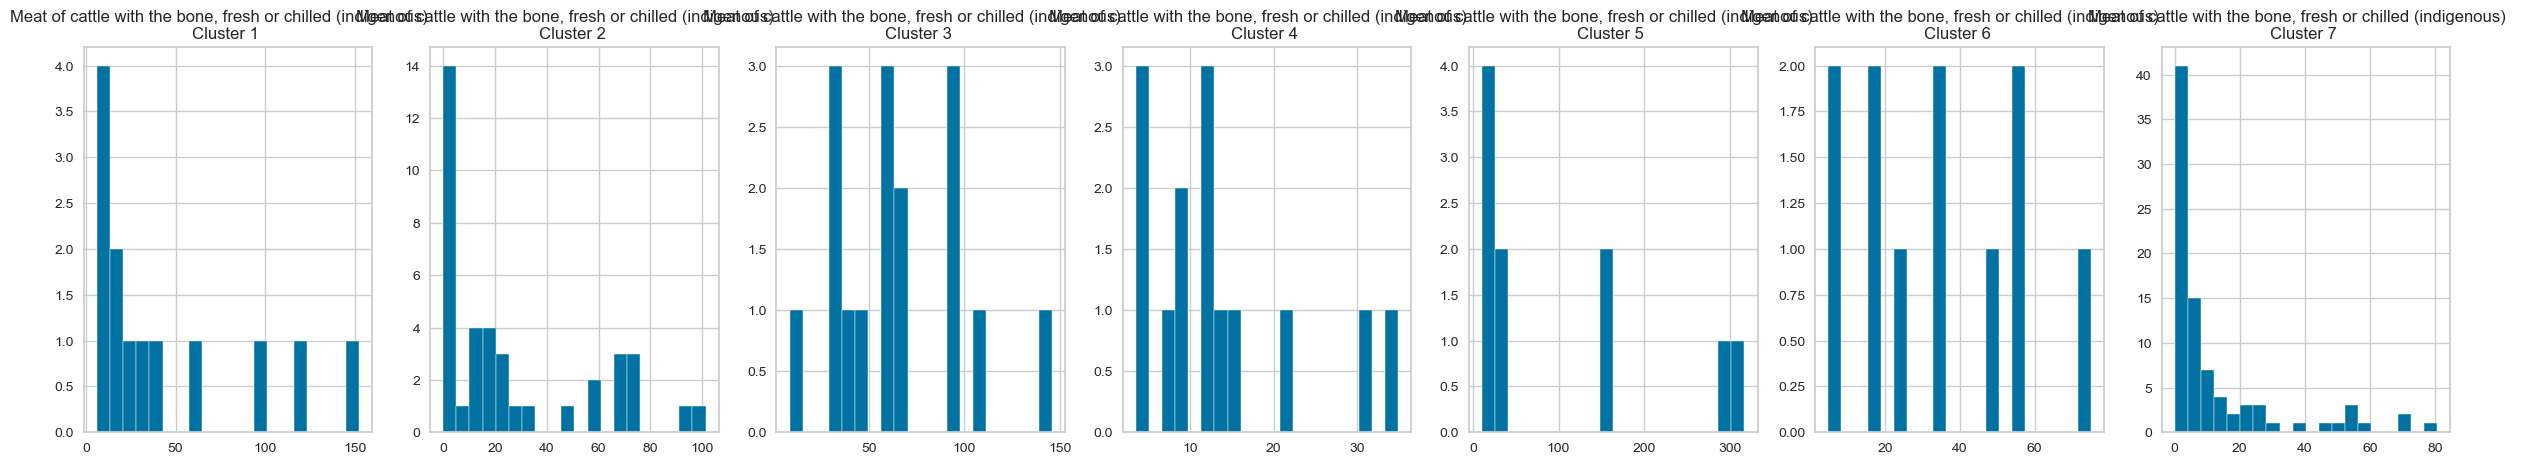

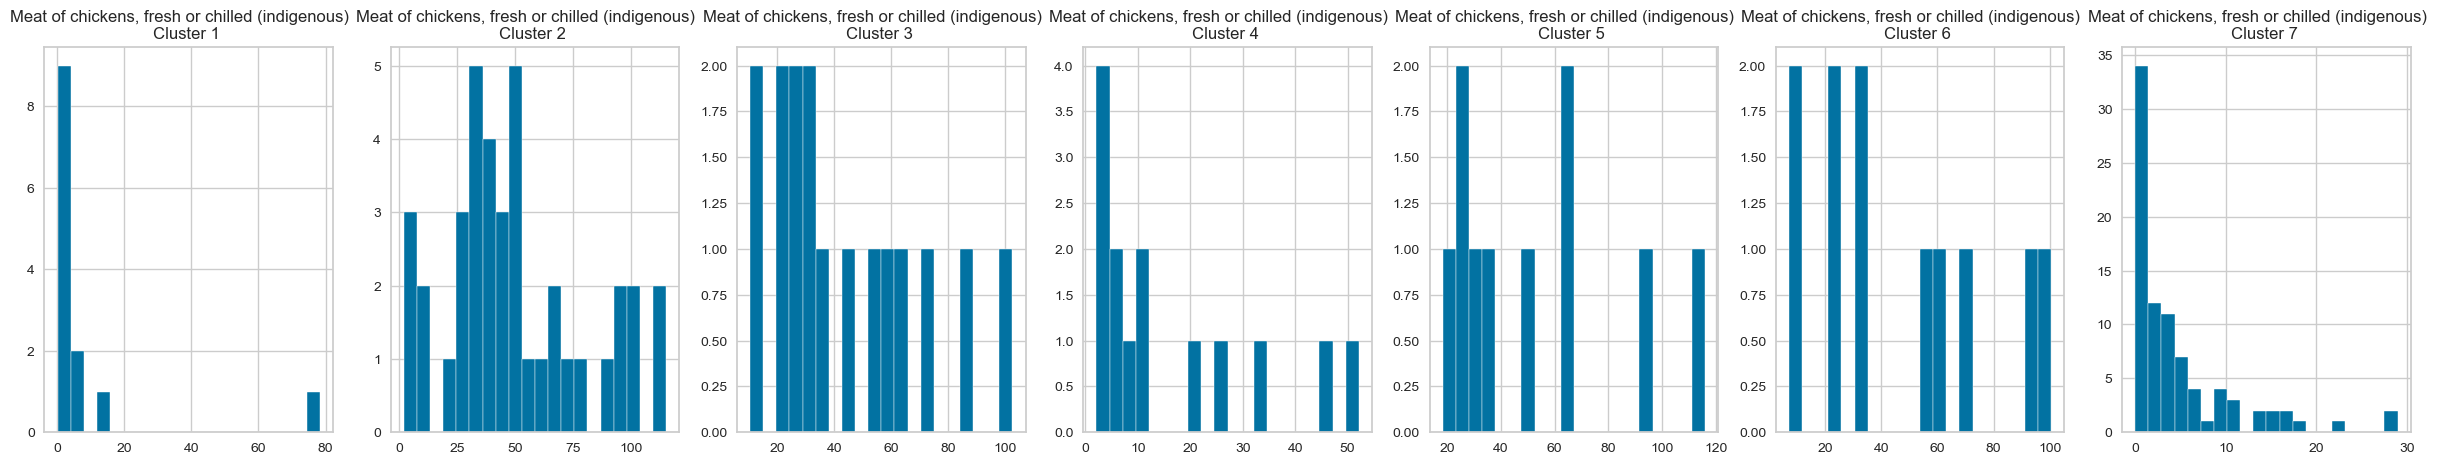

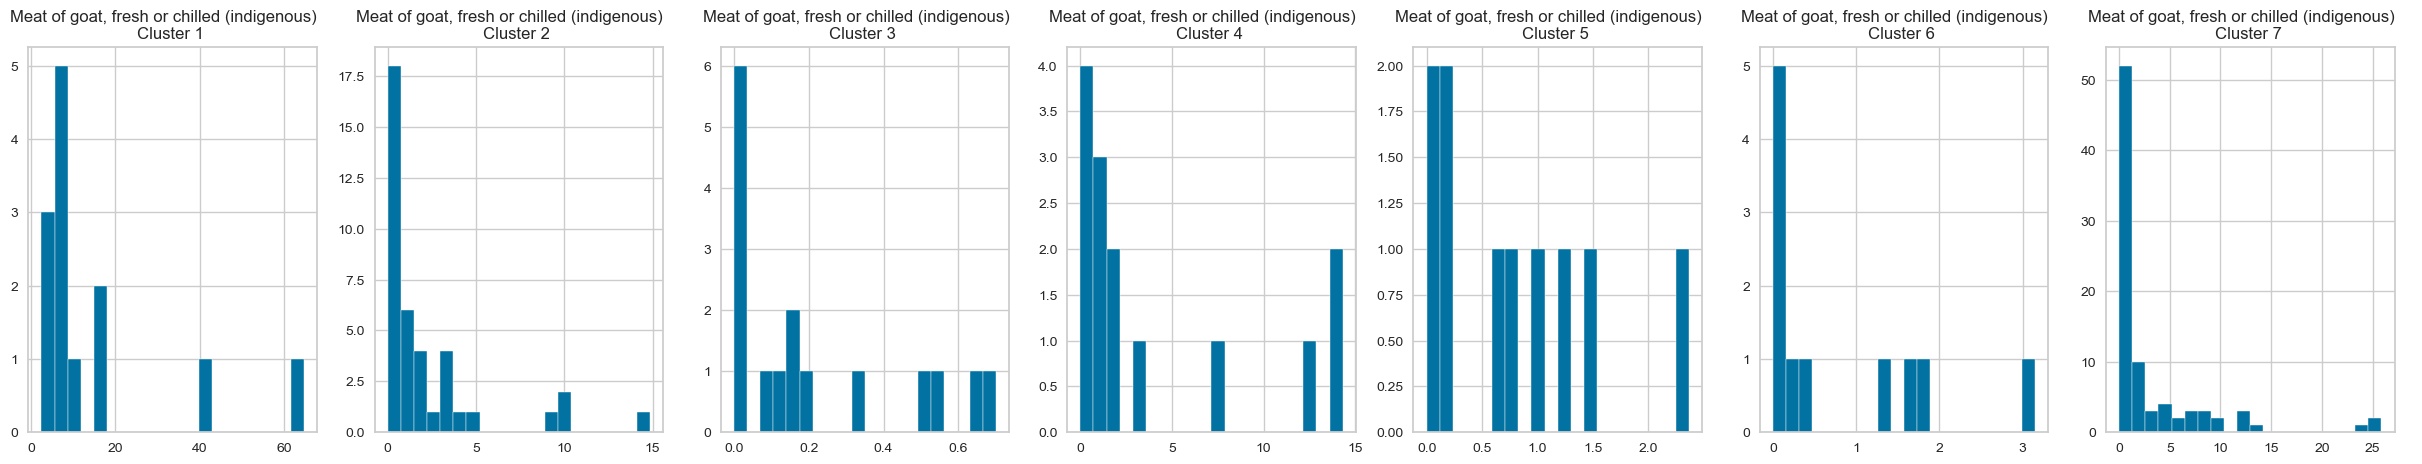

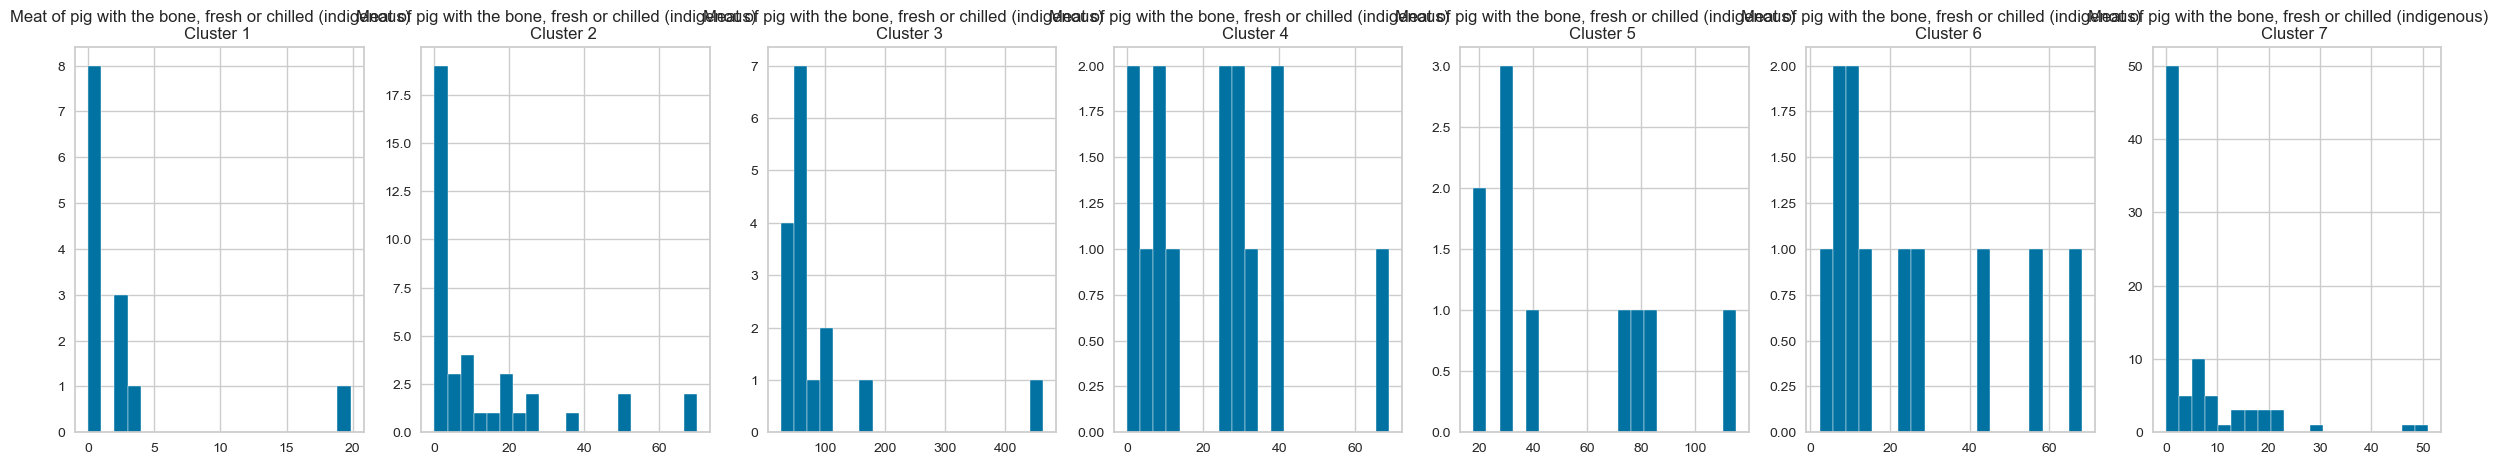

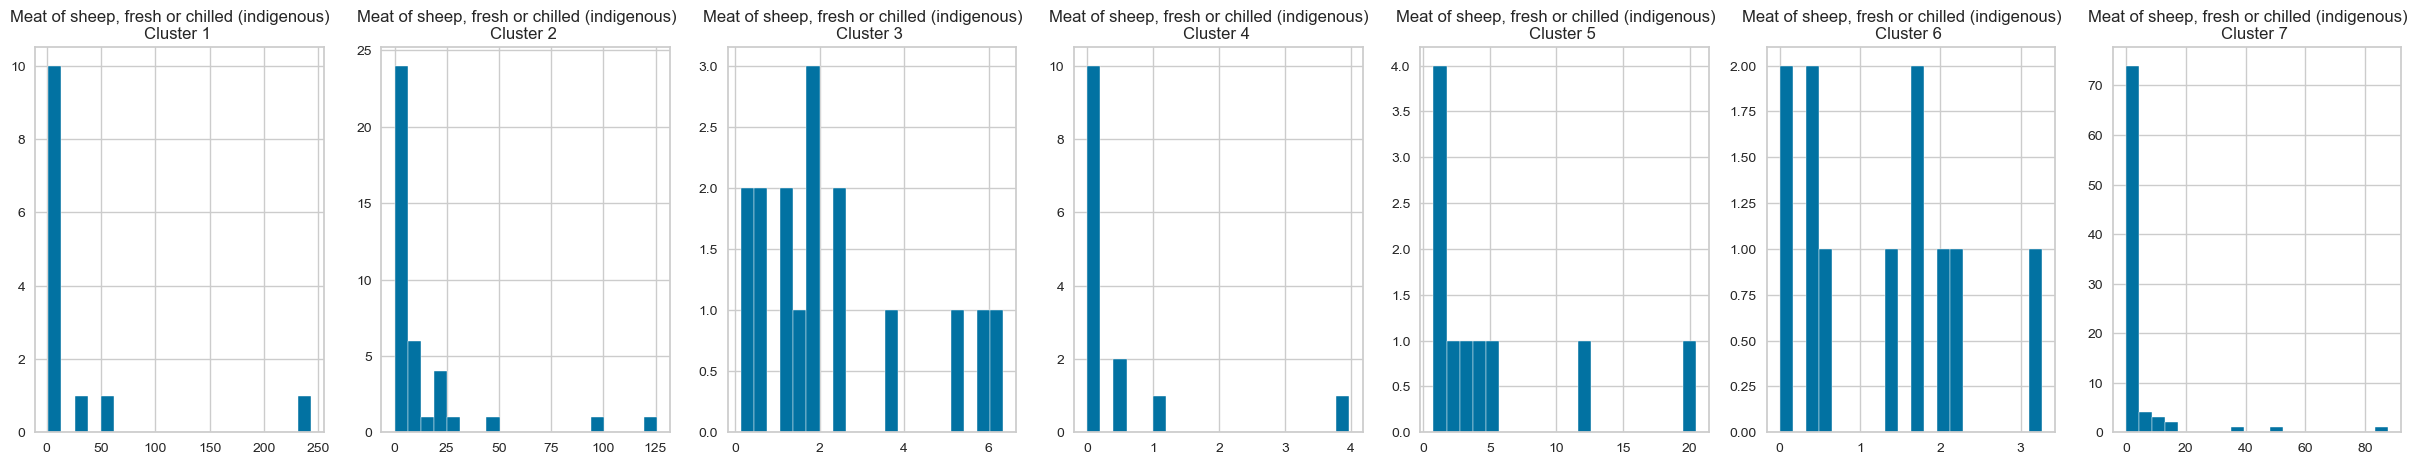

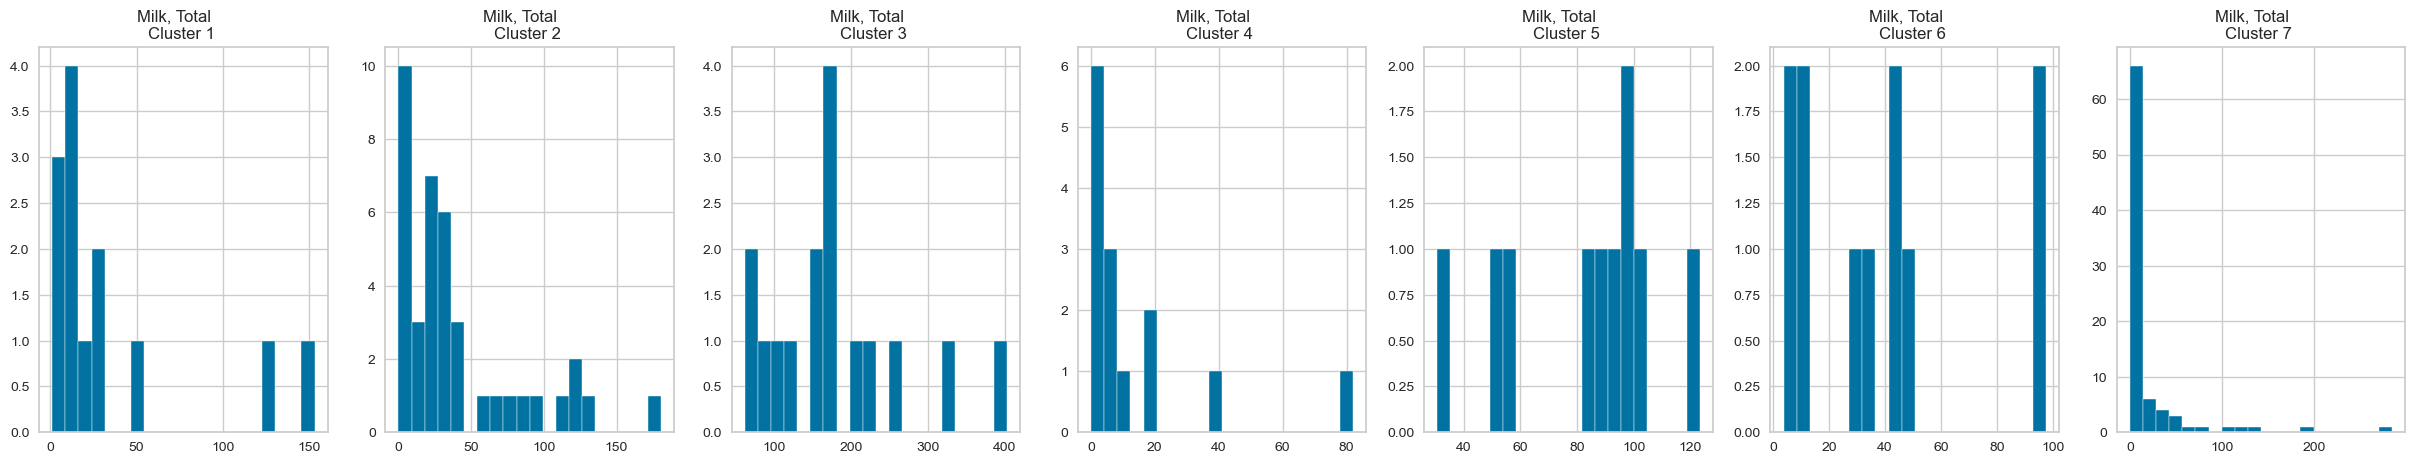

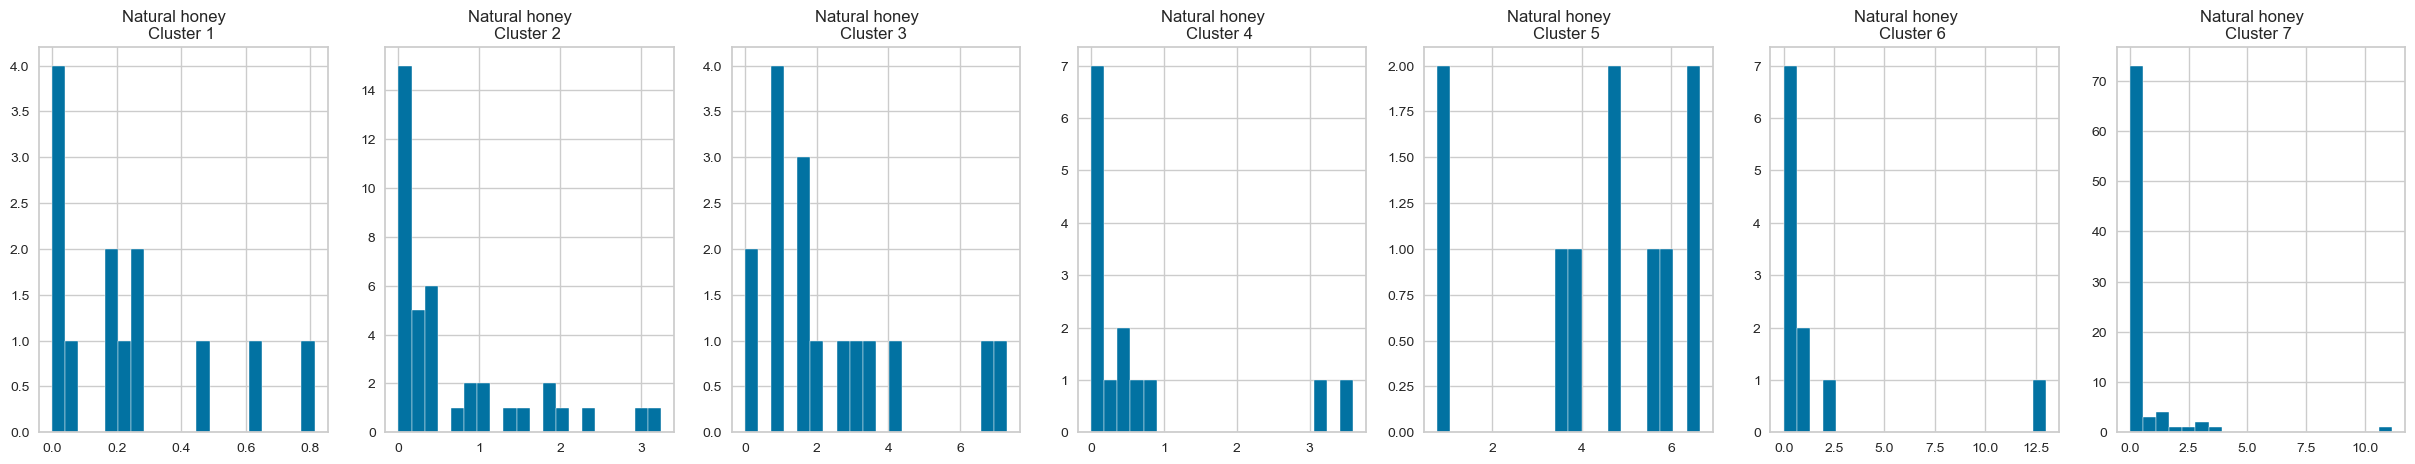

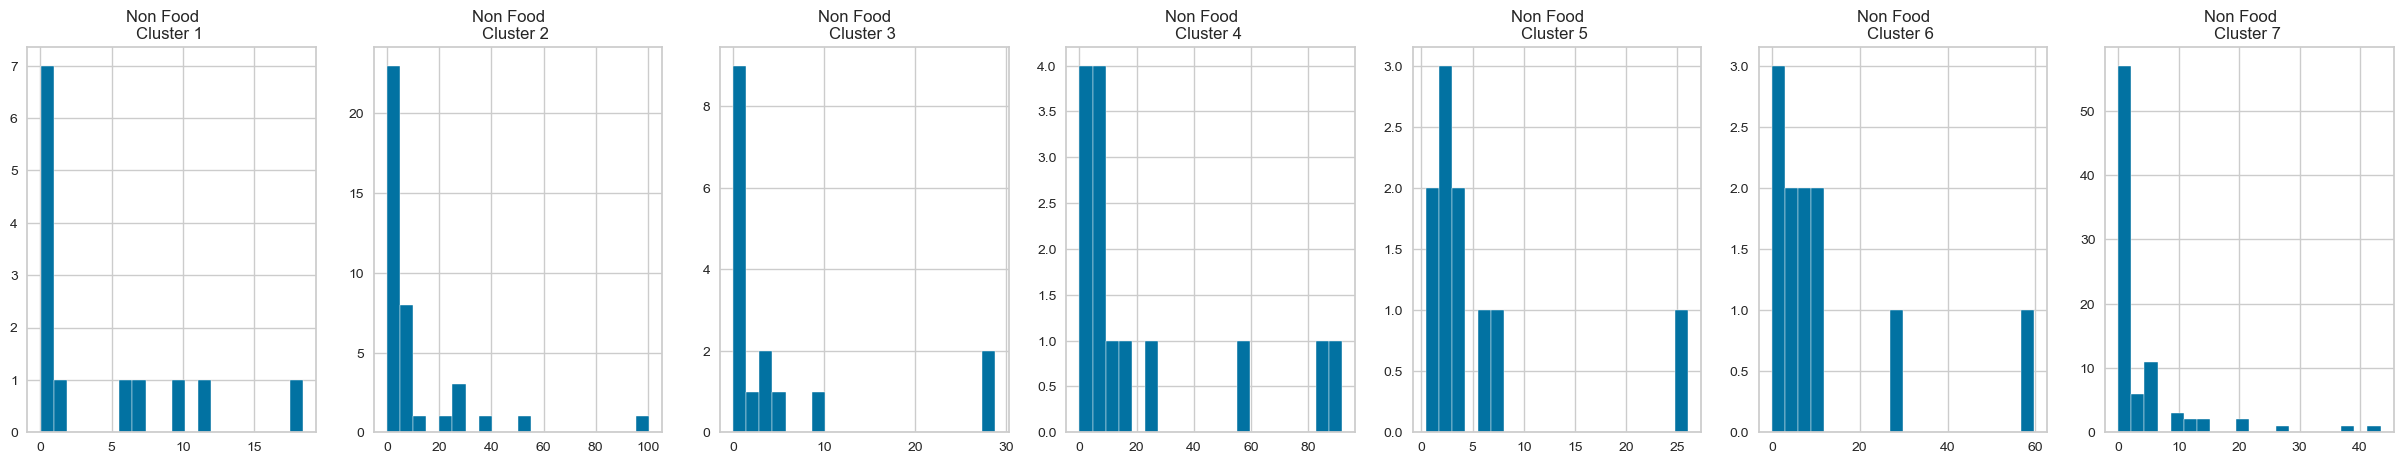

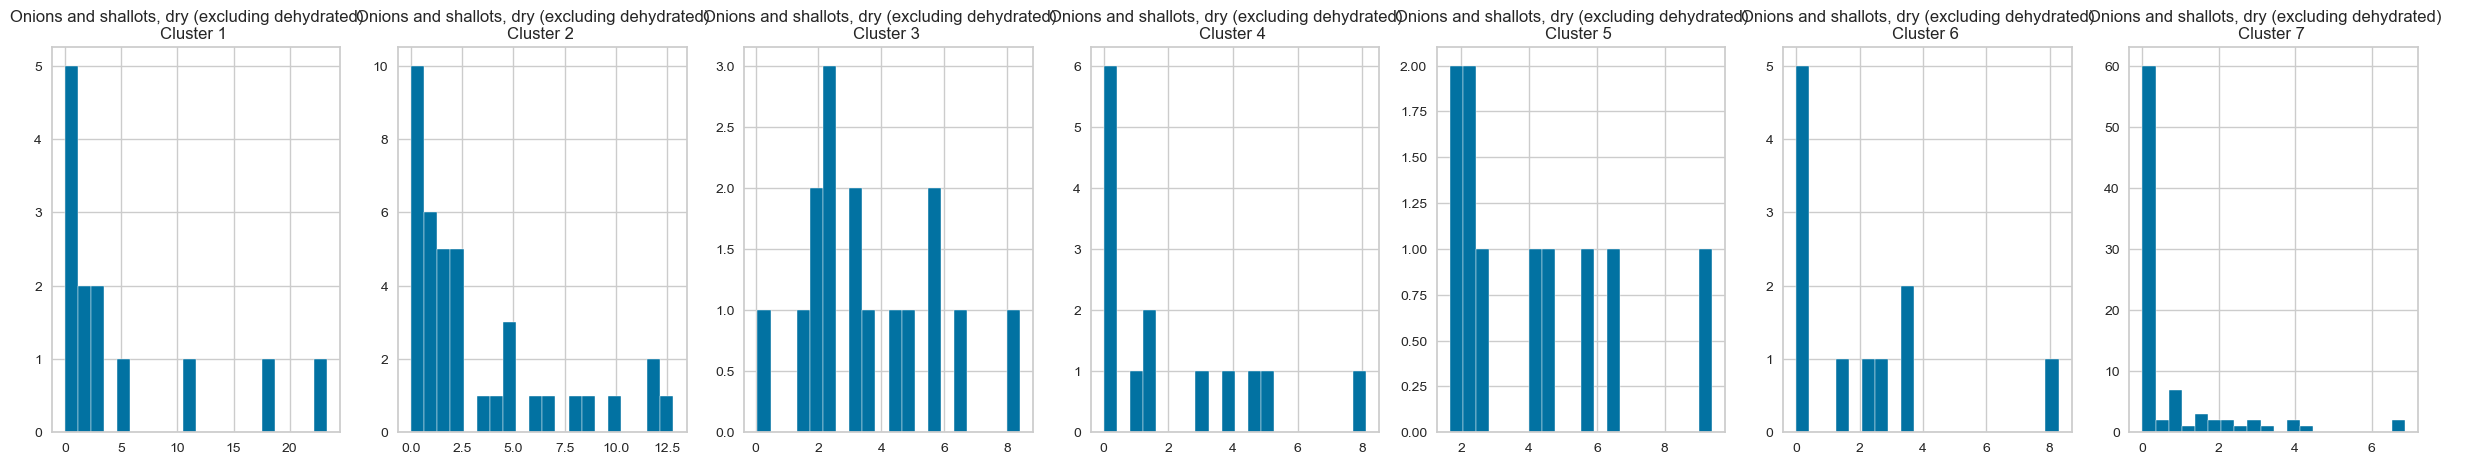

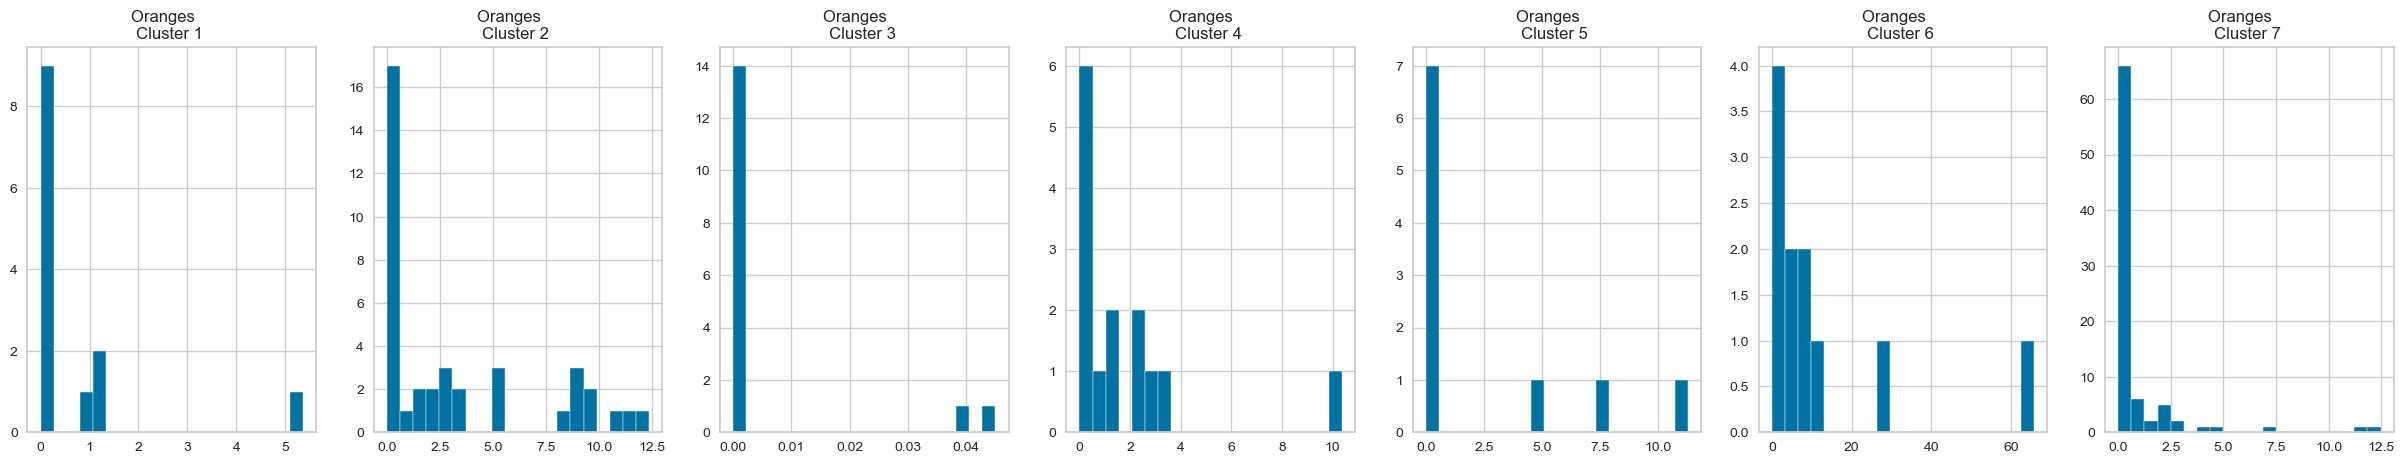

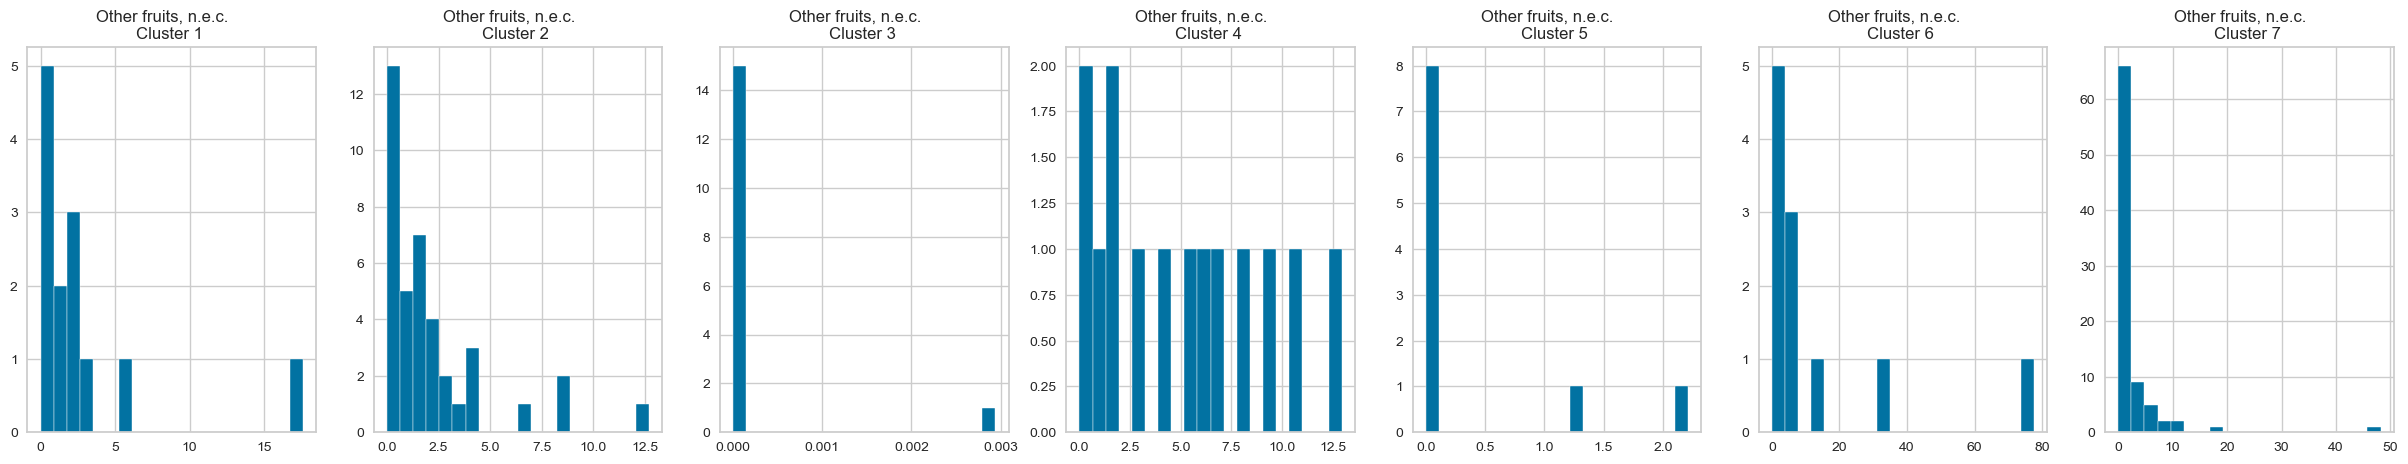

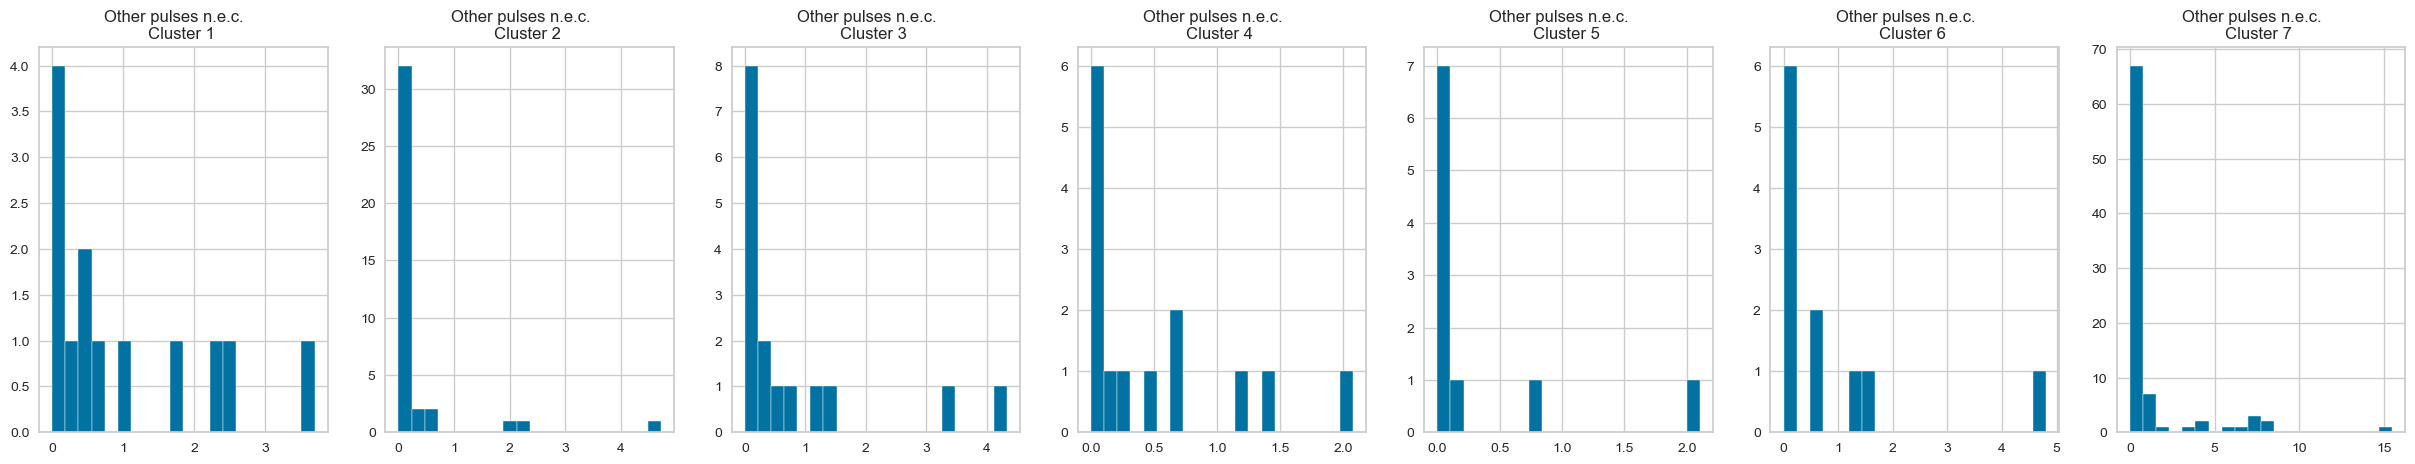

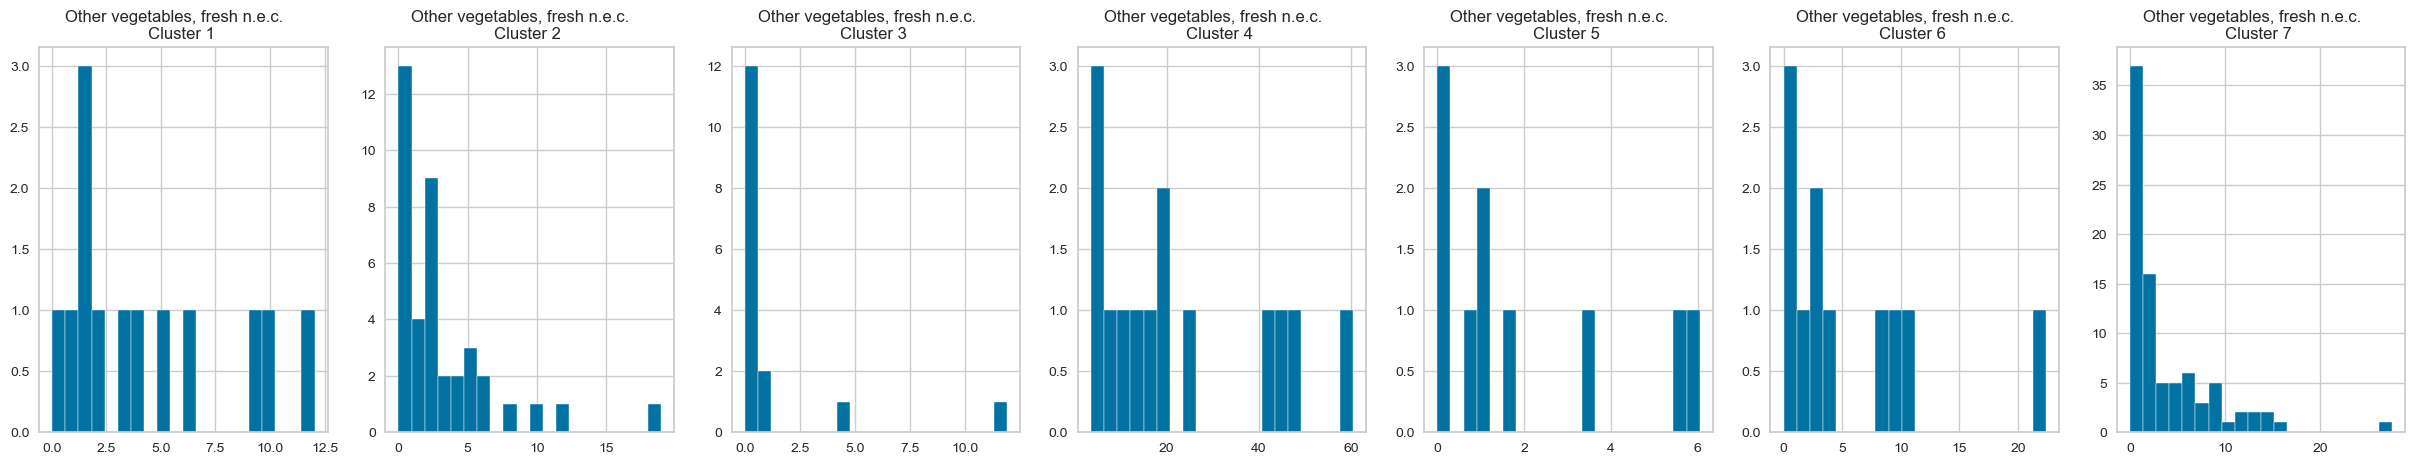

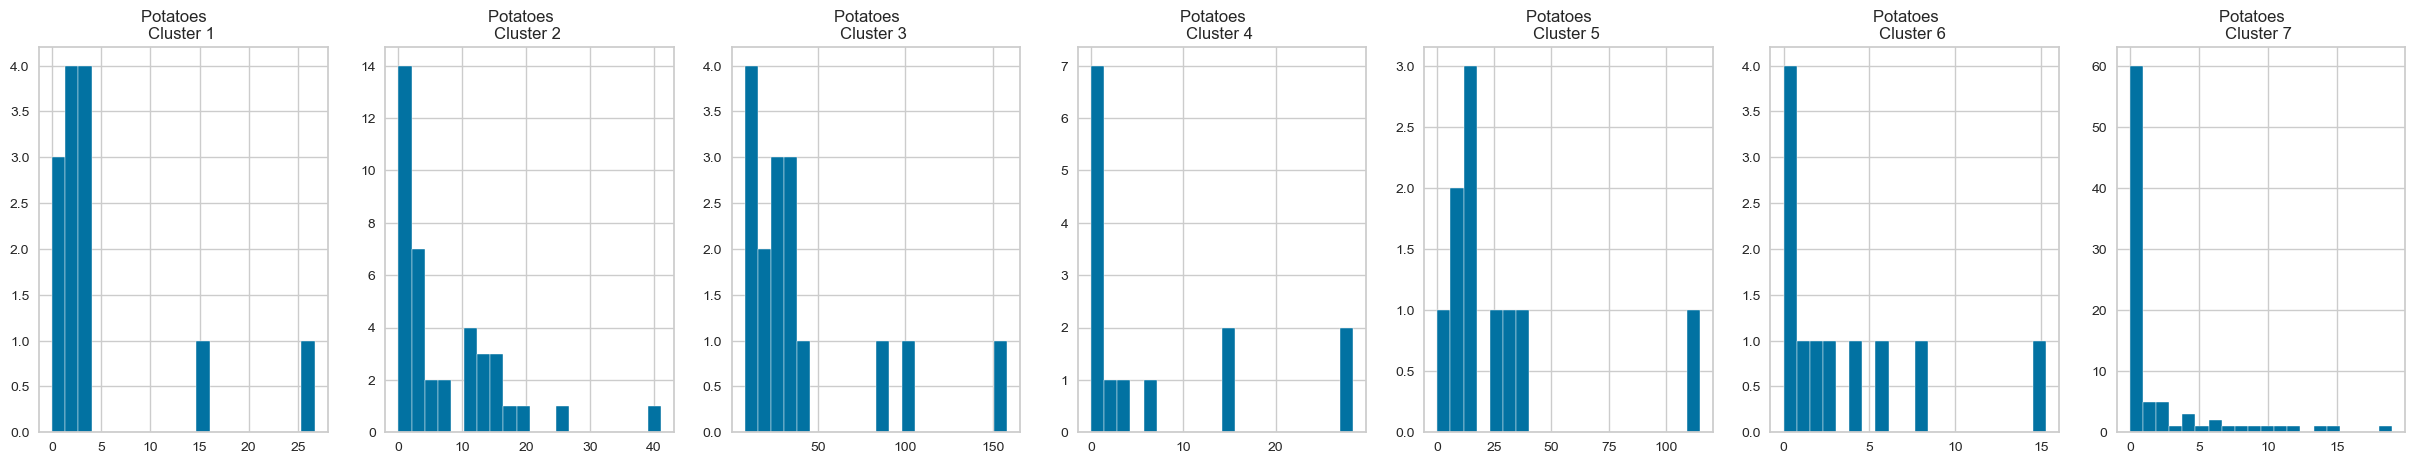

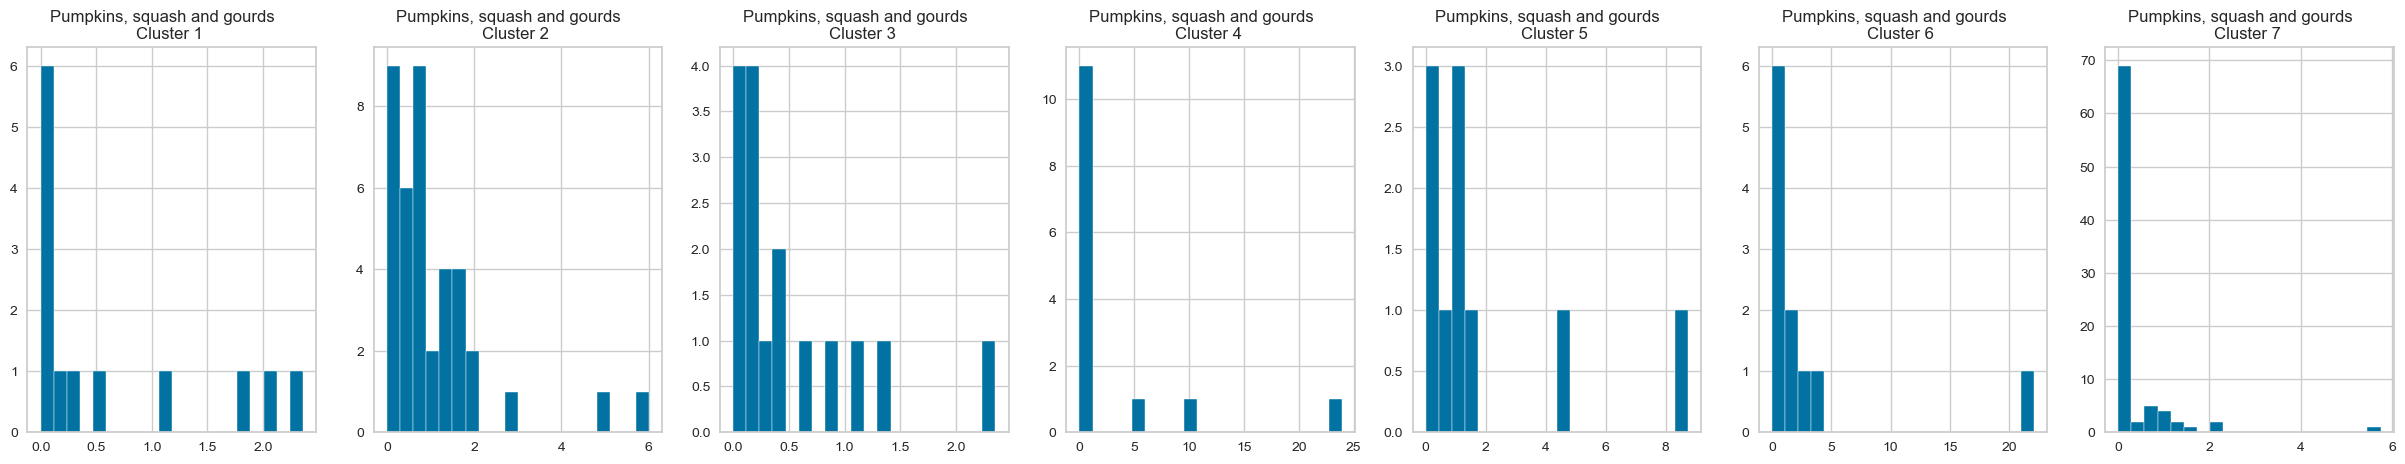

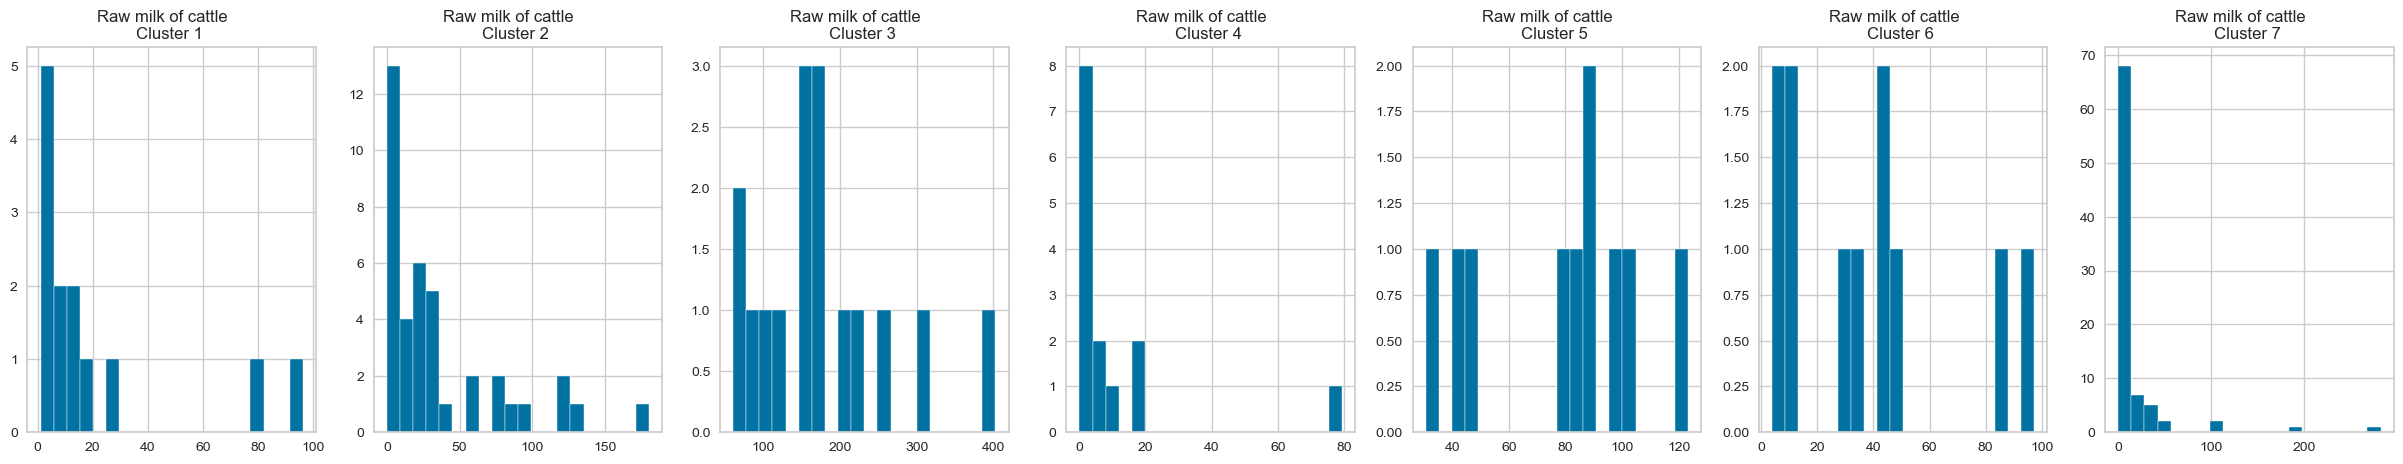

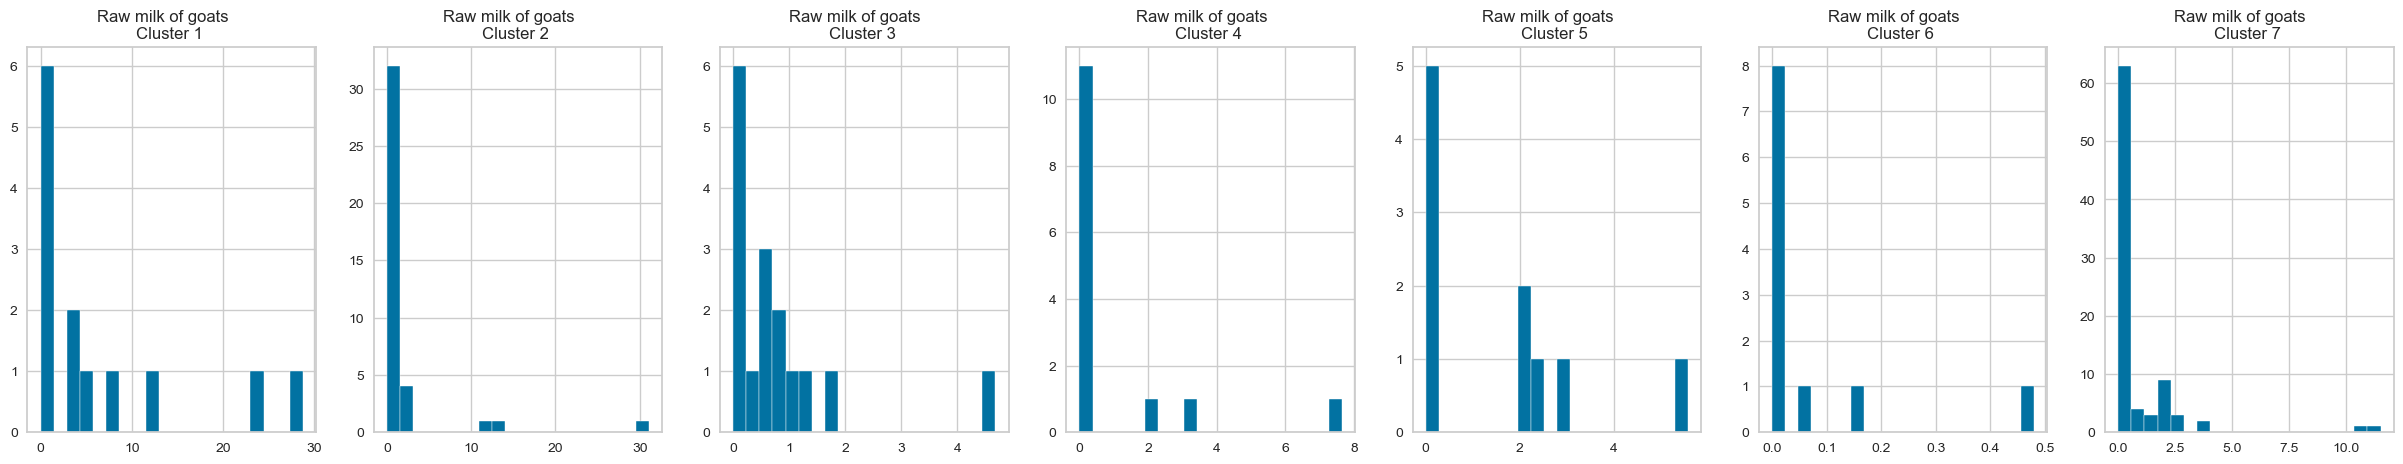

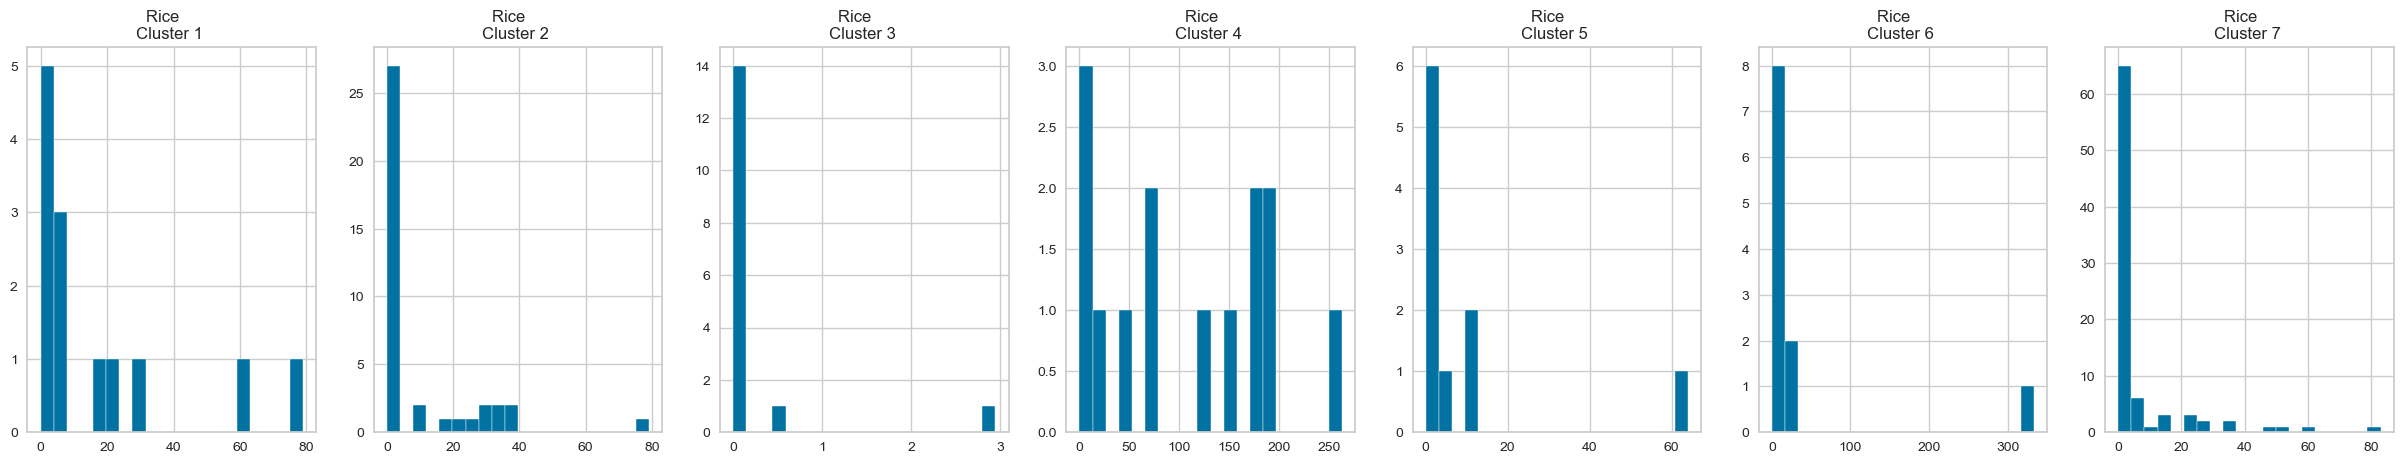

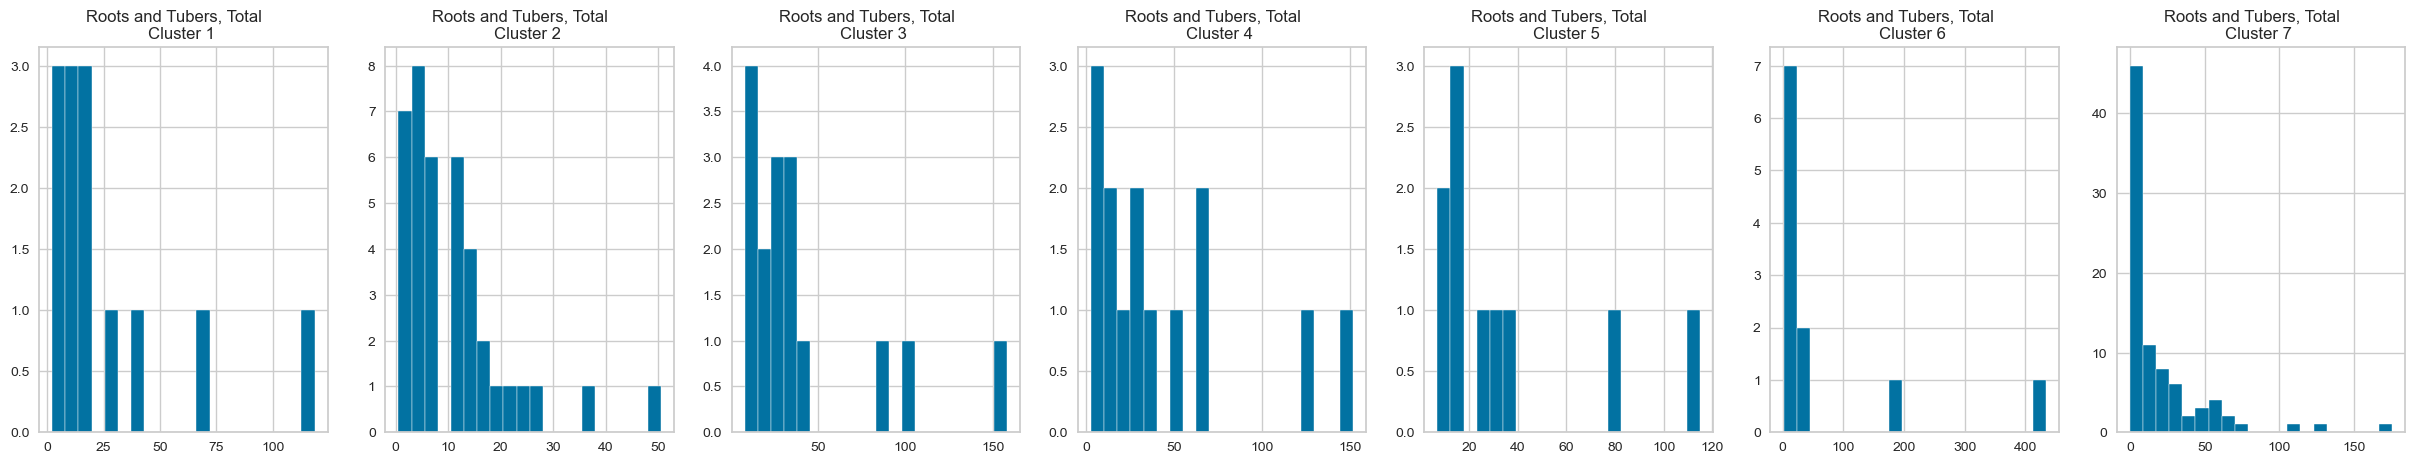

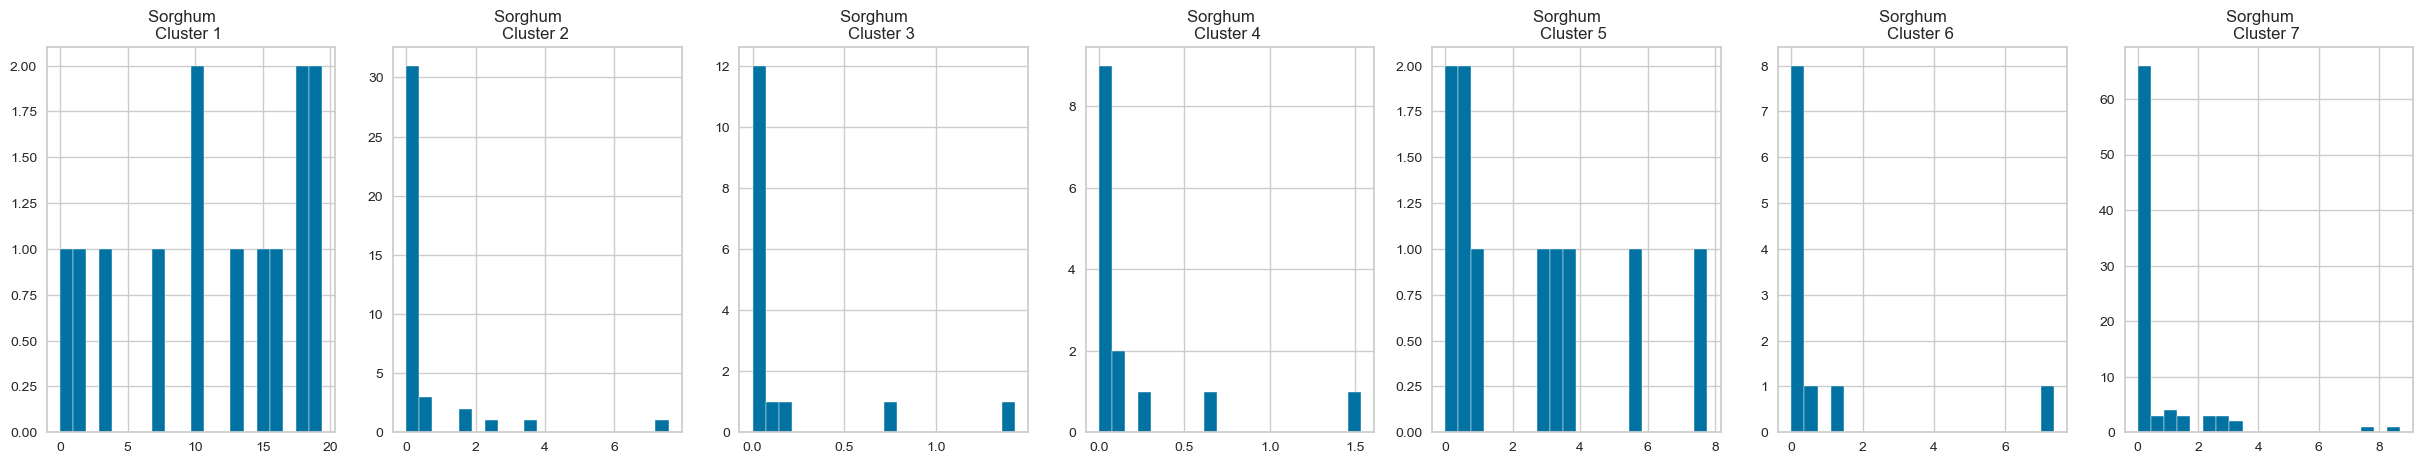

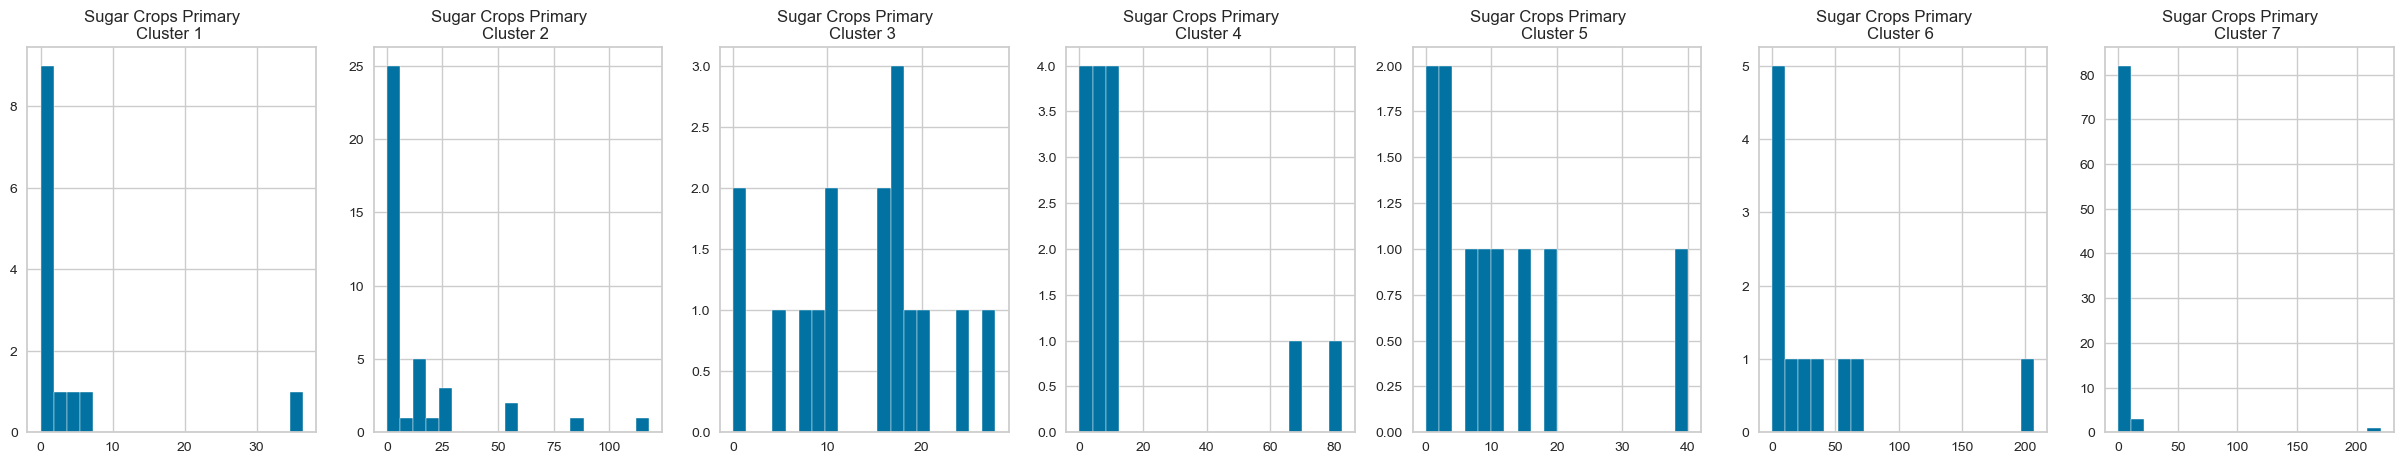

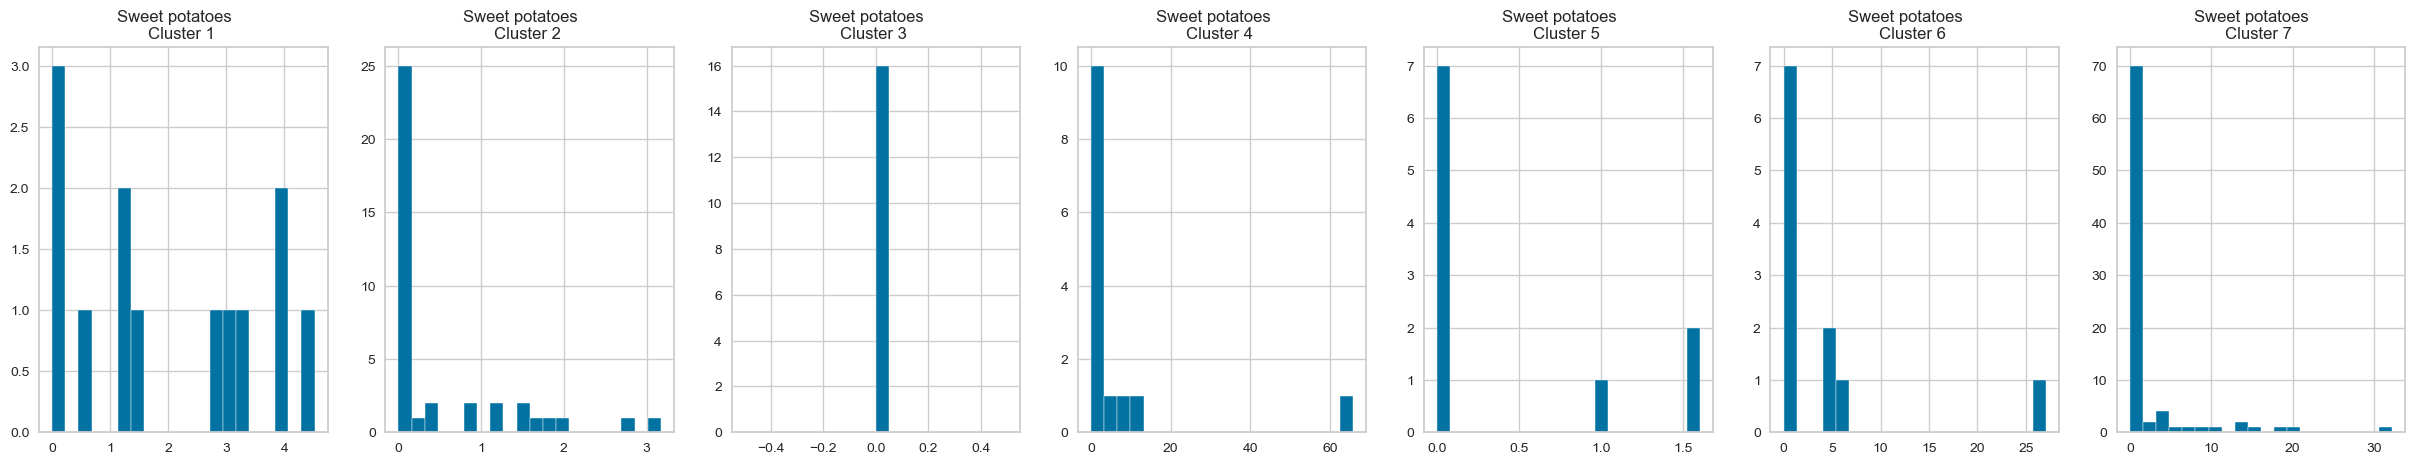

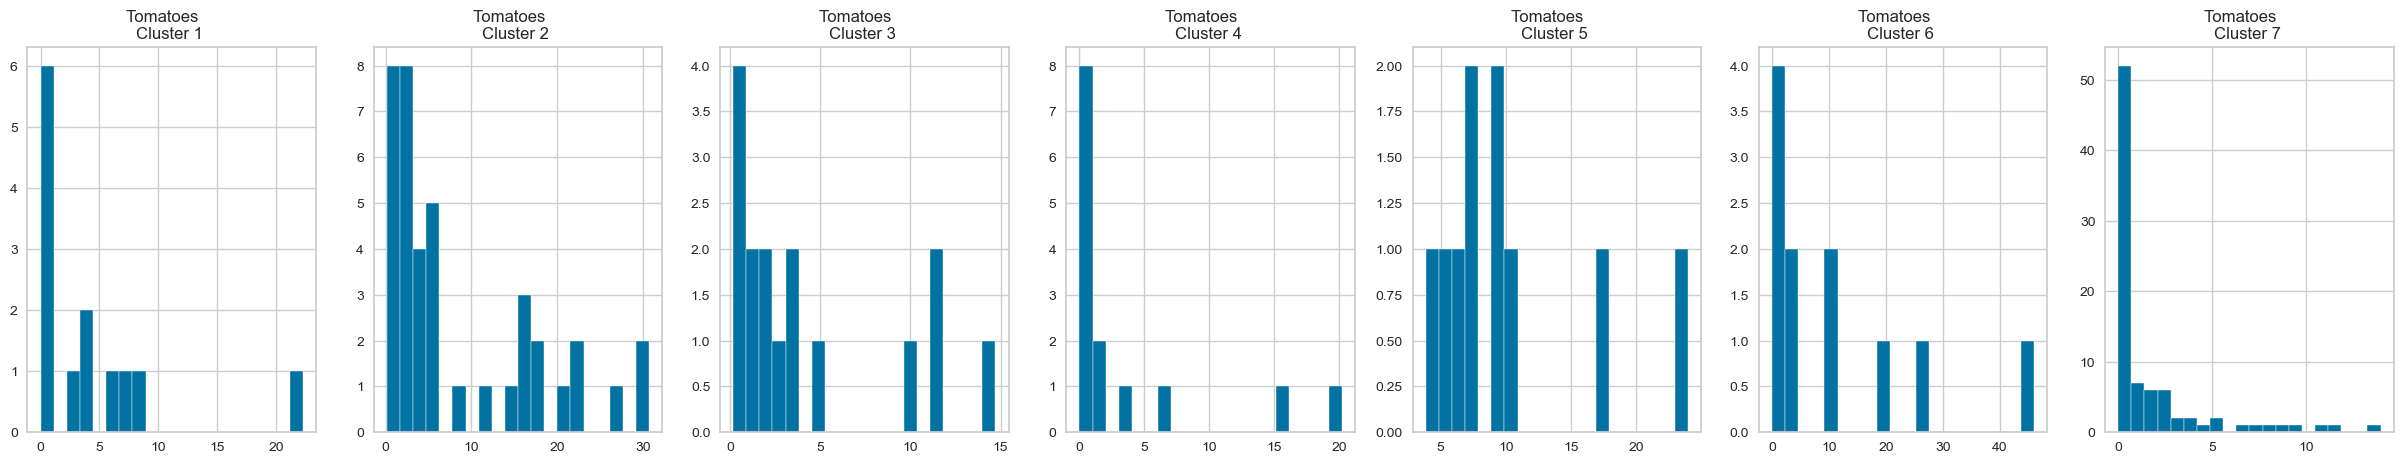

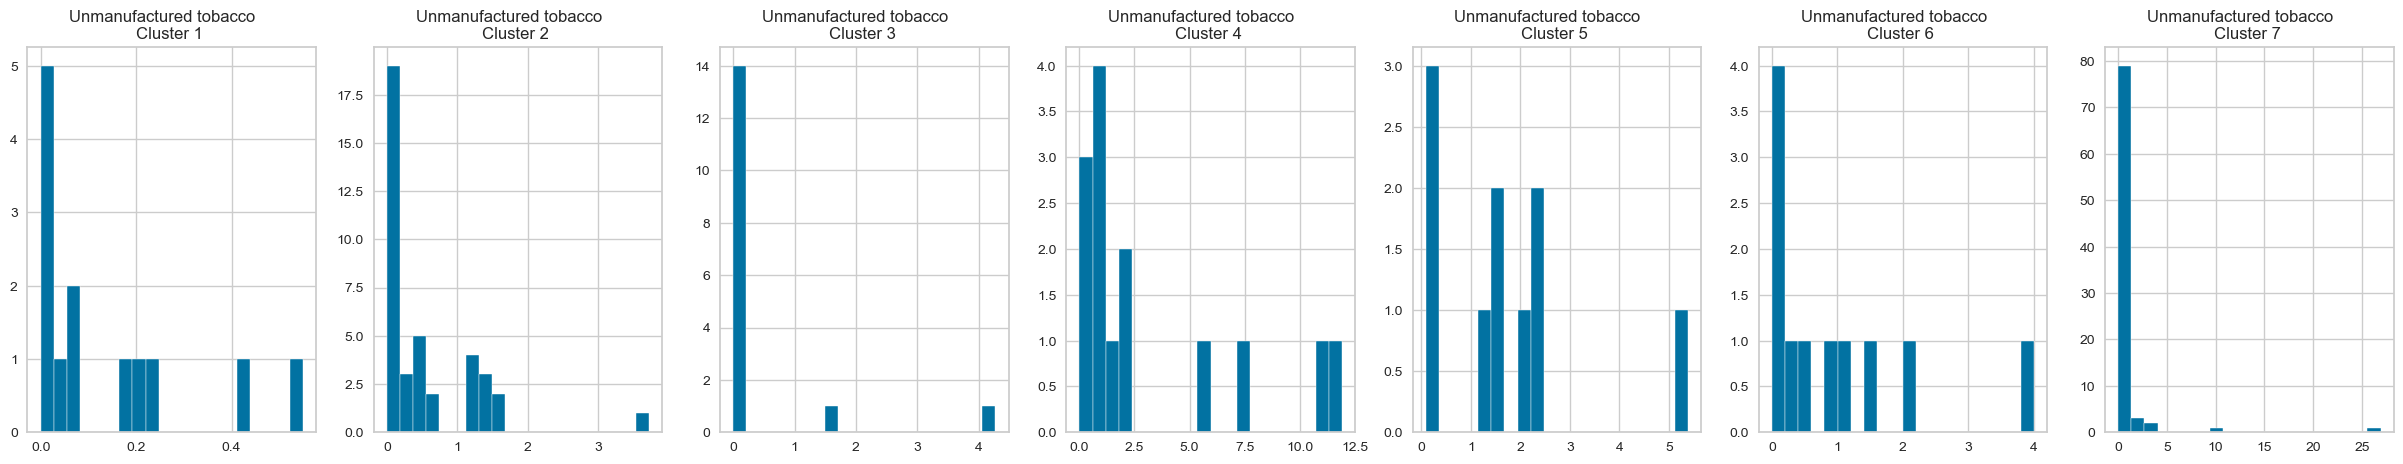

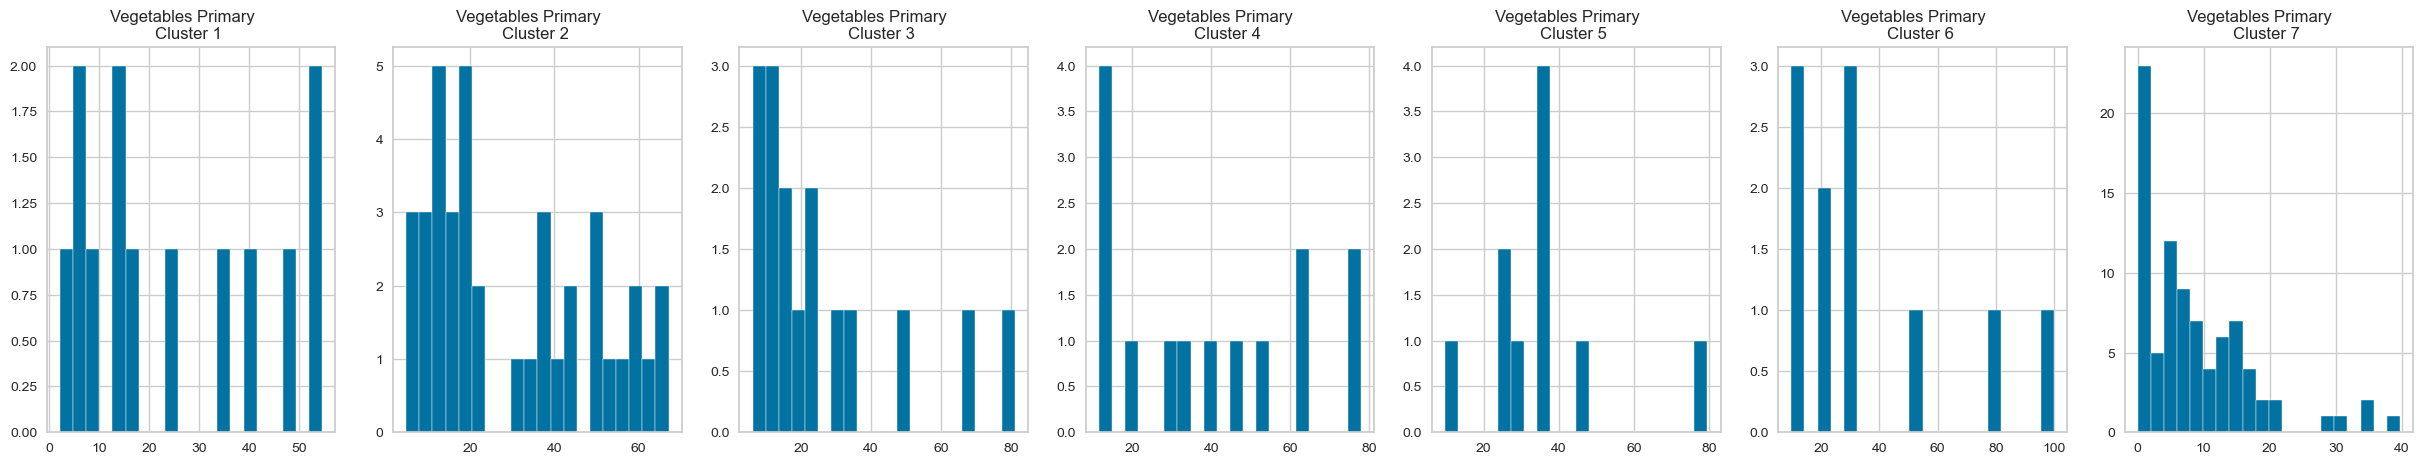

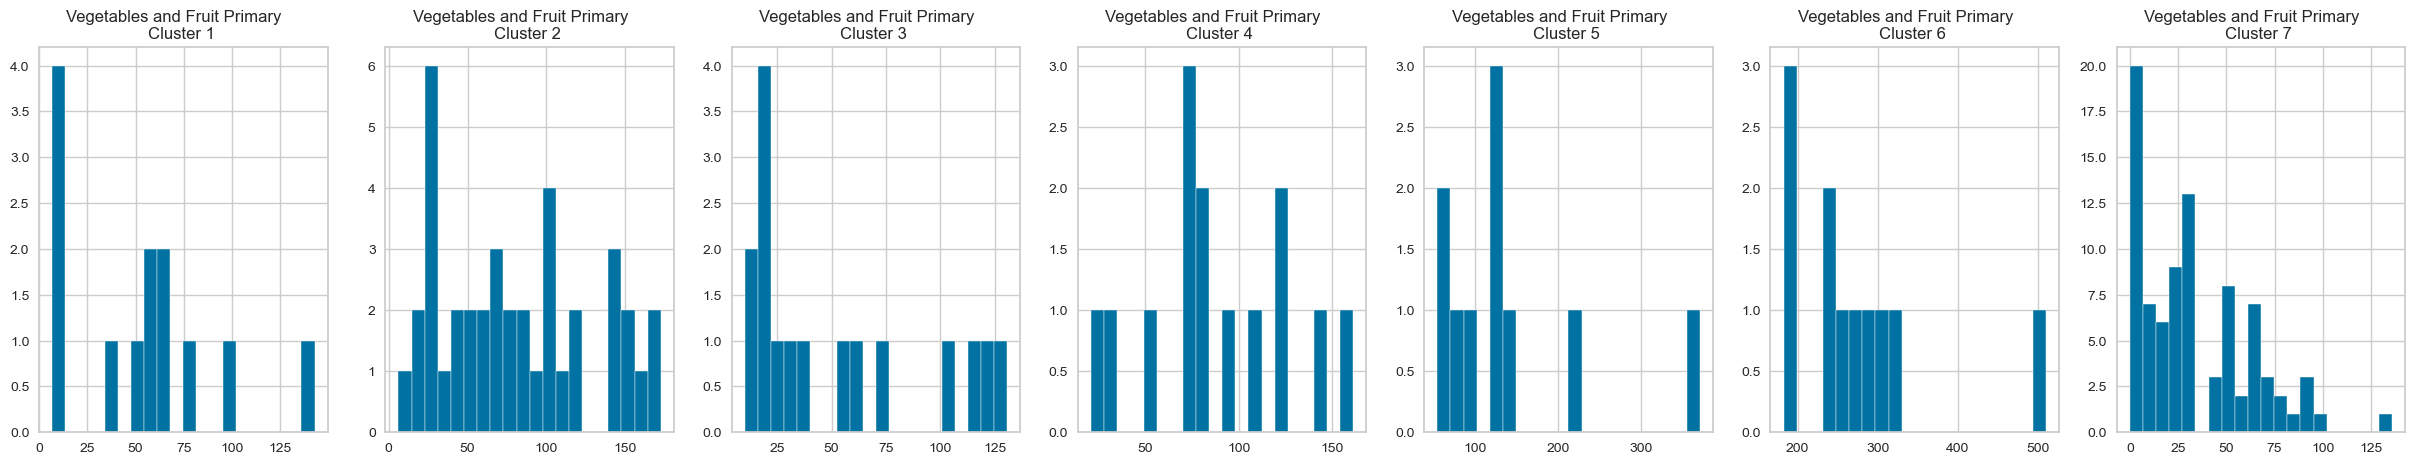

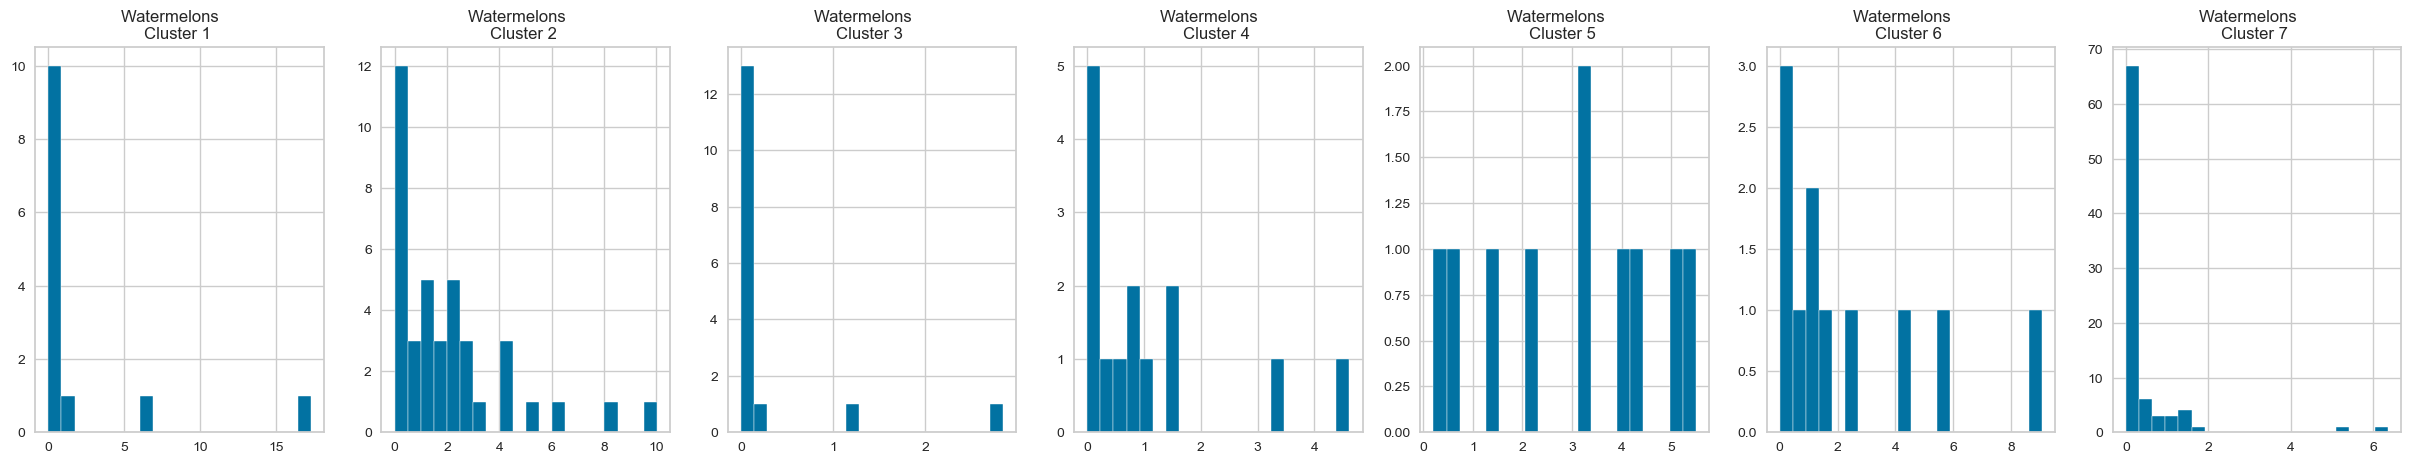

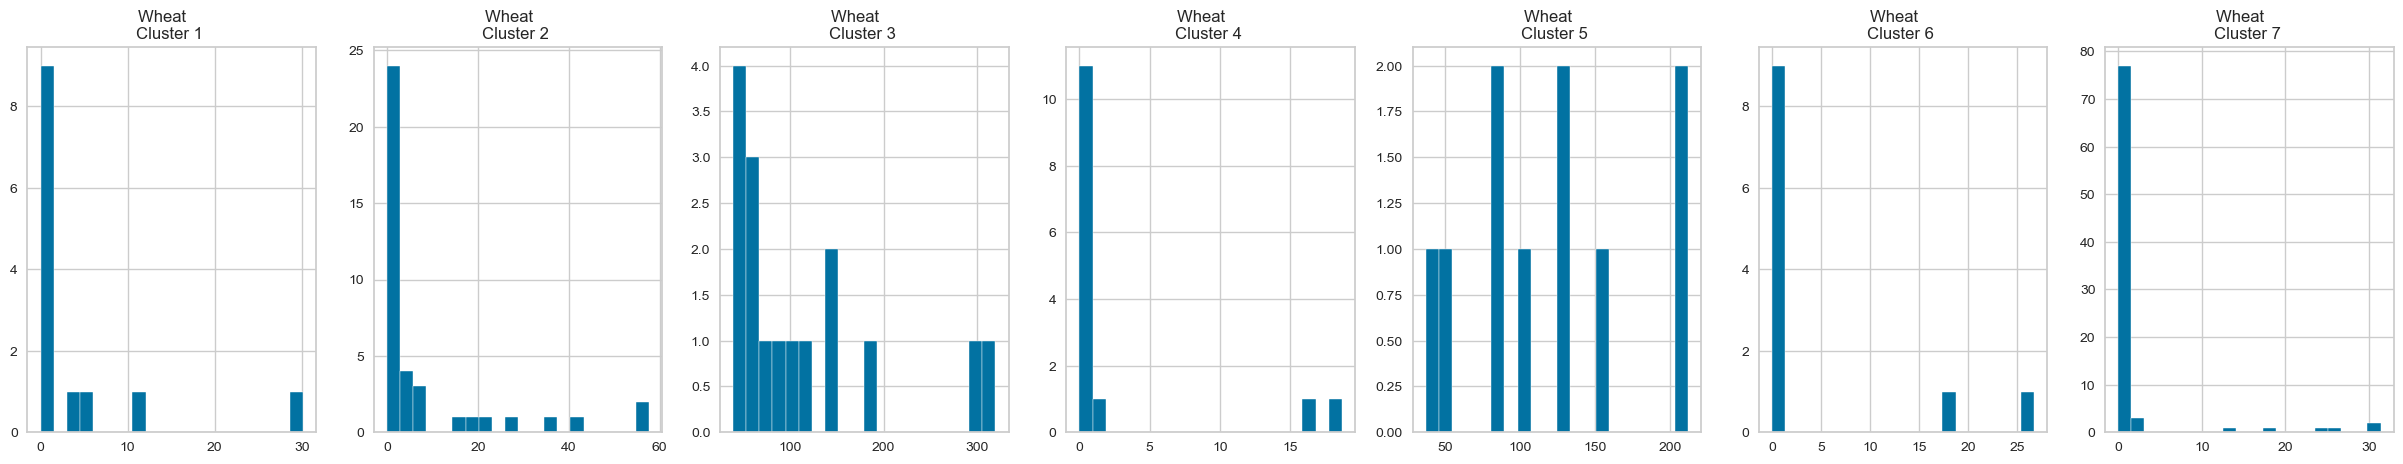

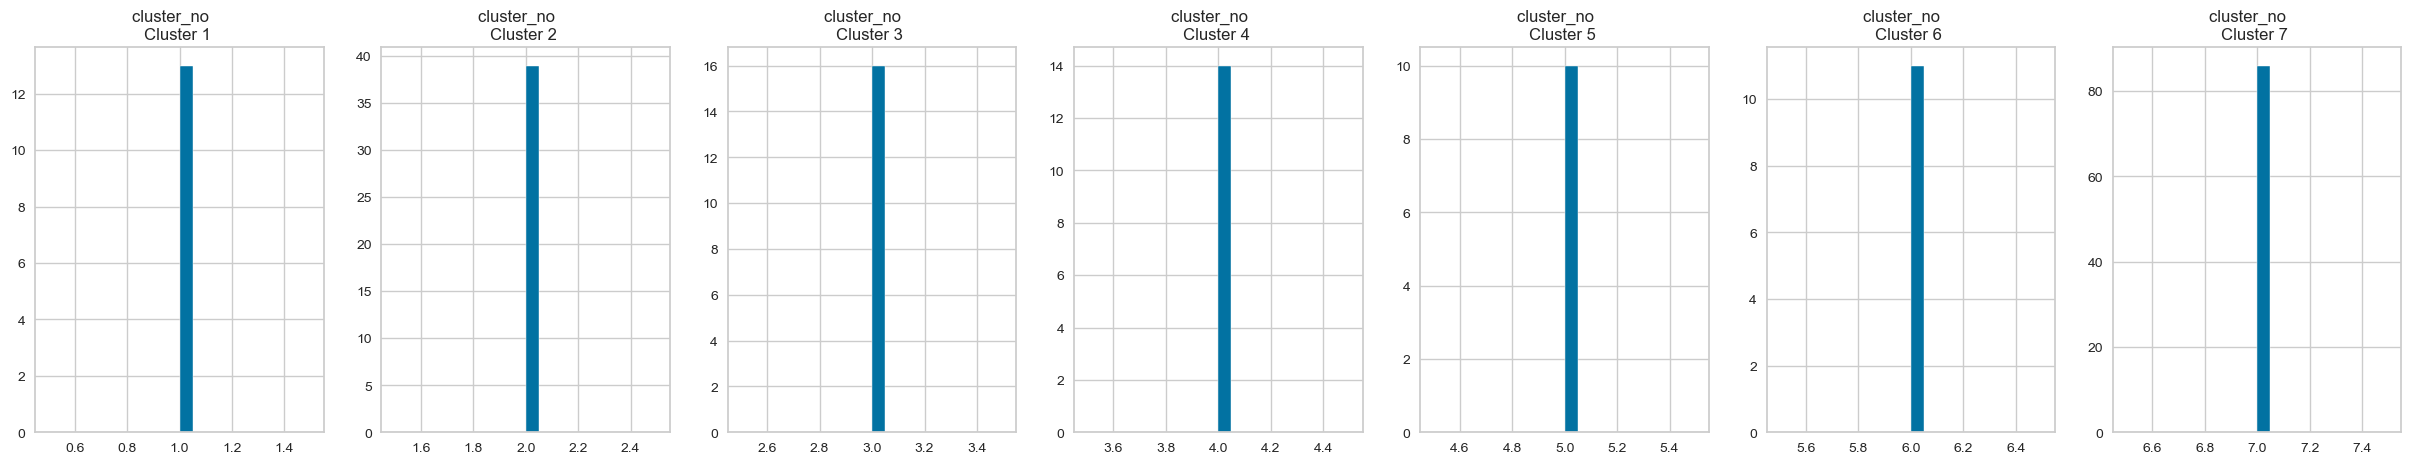

In [168]:
for i in prod_df.columns:
  plt.figure(figsize = (35, 5))
  for j in range(1,8):
    plt.subplot(1,8,j+1)
    cluster = prod_df[prod_df['cluster_no'] == j]
    cluster[i].hist(bins = 20)
    plt.title('{}    \nCluster {} '.format(i,j))
  
  plt.show()

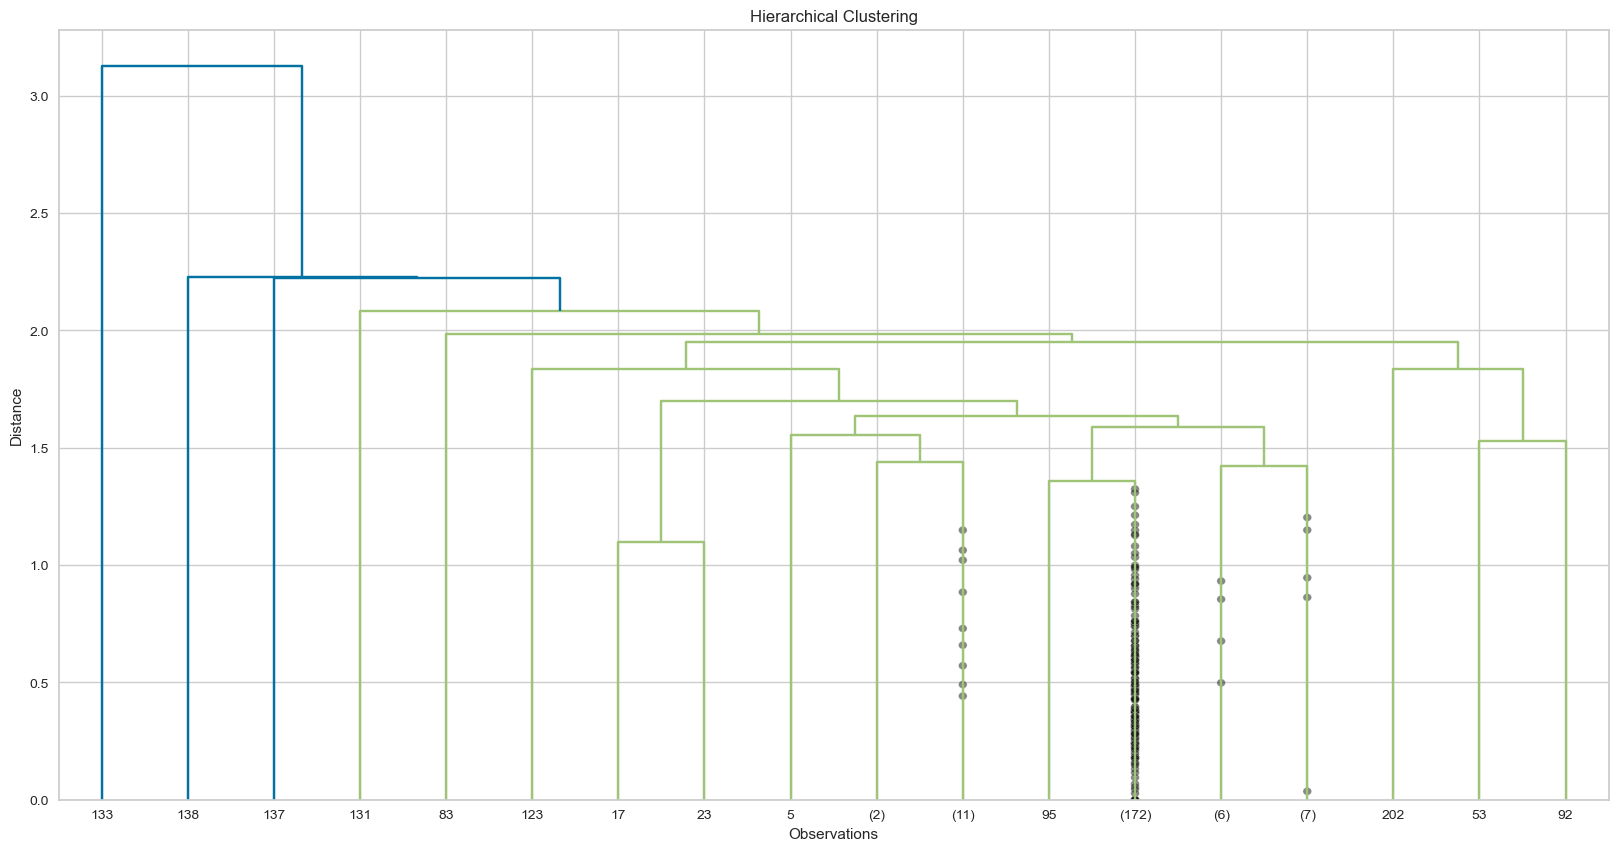

In [169]:
# Average Linkage Method
hc_average = linkage(data_scaled, "average")

plt.figure(figsize=(20, 10))
plt.title("Hierarchical Clustering")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_average,
           leaf_font_size=10, 
           p=10,
           show_contracted=True,
          truncate_mode='level')
plt.show()

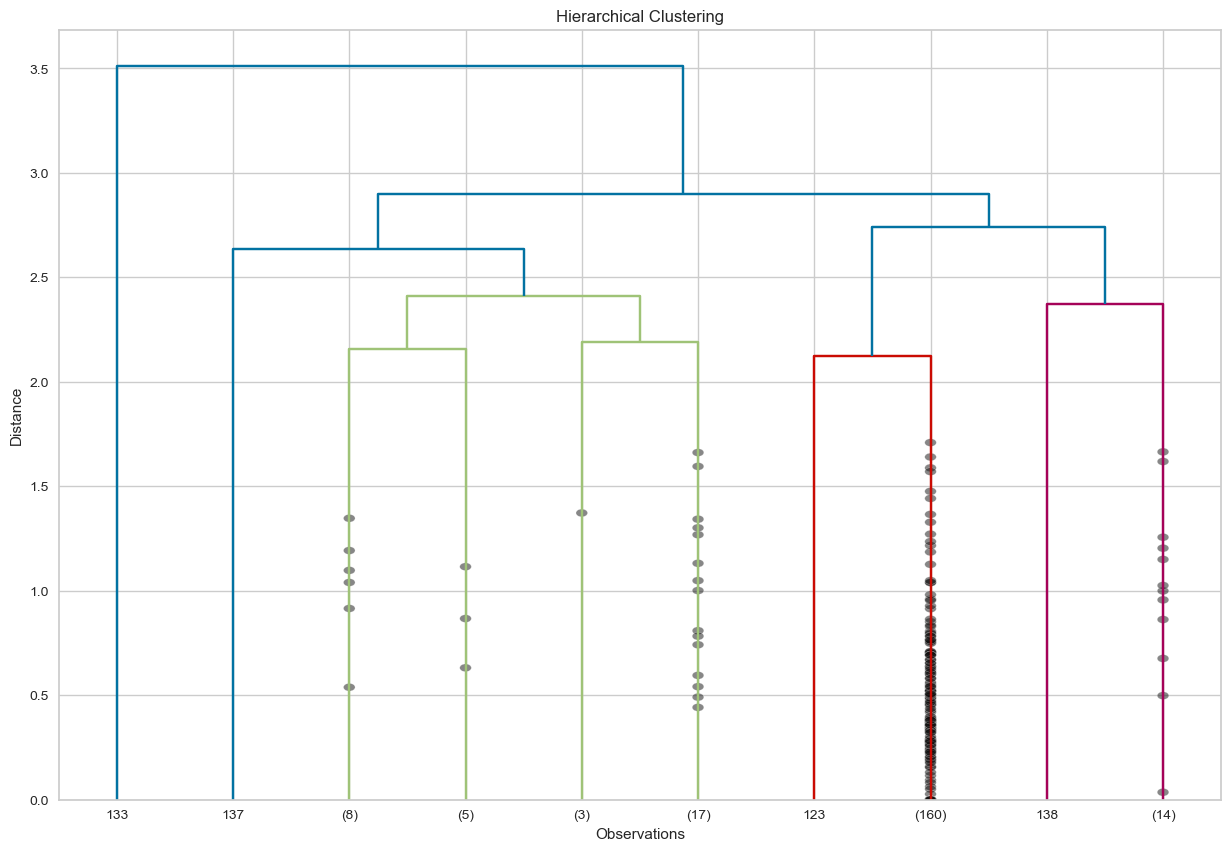

In [170]:
# Complete Linkage Method
hc_complete = linkage(data_scaled, "complete")

plt.figure(figsize=(15, 10))
plt.title("Hierarchical Clustering")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_complete,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.show()

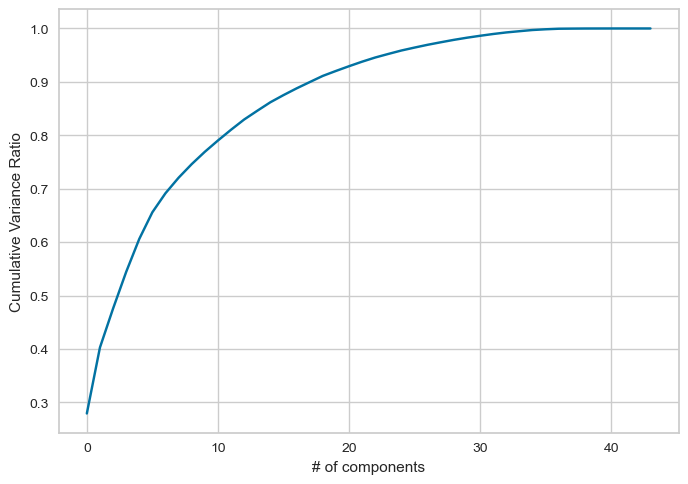

In [171]:
pca = PCA().fit(data_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("# of components")
plt.ylabel("Cumulative Variance Ratio")
plt.show()

In [189]:
for i in range(prod_df.shape[1]-1):
    pca = PCA(n_components=i)
    pca_fit = pca.fit_transform(data_scaled)
    print(i, pca.explained_variance_ratio_.sum())

0 0.0
1 0.2791121834799882
2 0.40261974386790433
3 0.47545496899405837
4 0.5441040402443734
5 0.6059082170812086
6 0.6558603872654419
7 0.6915045991948875
8 0.720523807164966
9 0.7459884213554197
10 0.769045705857887
11 0.79017636897612
12 0.810342206243453
13 0.8294981550660485
14 0.8458669526393646
15 0.8618024358406423
16 0.8751911569531775
17 0.8878067853297328
18 0.89955825268539
19 0.9111691916087997
20 0.9204337470875078
21 0.929322031534072
22 0.9378179109212631
23 0.9456308436357718
24 0.9523102509562118
25 0.95876529575896
26 0.9642313784794138
27 0.9694573516528415
28 0.974158341520885
29 0.9786815476147801
30 0.9827114035405614
31 0.9863052727470302
32 0.9896516996823086
33 0.9925821473095158
34 0.9948914669684159
35 0.9971221053182682
36 0.9984821291129012
37 0.9994996720778289
38 0.9997293017870293
39 0.9998940526033429
40 0.9999479112962568
41 0.9999818439458764
42 0.999999926263228
43 0.9999999998901562


In [190]:
pca = PCA(n_components=18)
pca_fit = pca.fit_transform(data_scaled)
pca.explained_variance_ratio_

array([0.27911218, 0.12350756, 0.07283523, 0.06864907, 0.06180418,
       0.04995217, 0.03564421, 0.02901921, 0.02546461, 0.02305728,
       0.02113066, 0.02016584, 0.01915595, 0.0163688 , 0.01593548,
       0.01338872, 0.01261563, 0.01175147])

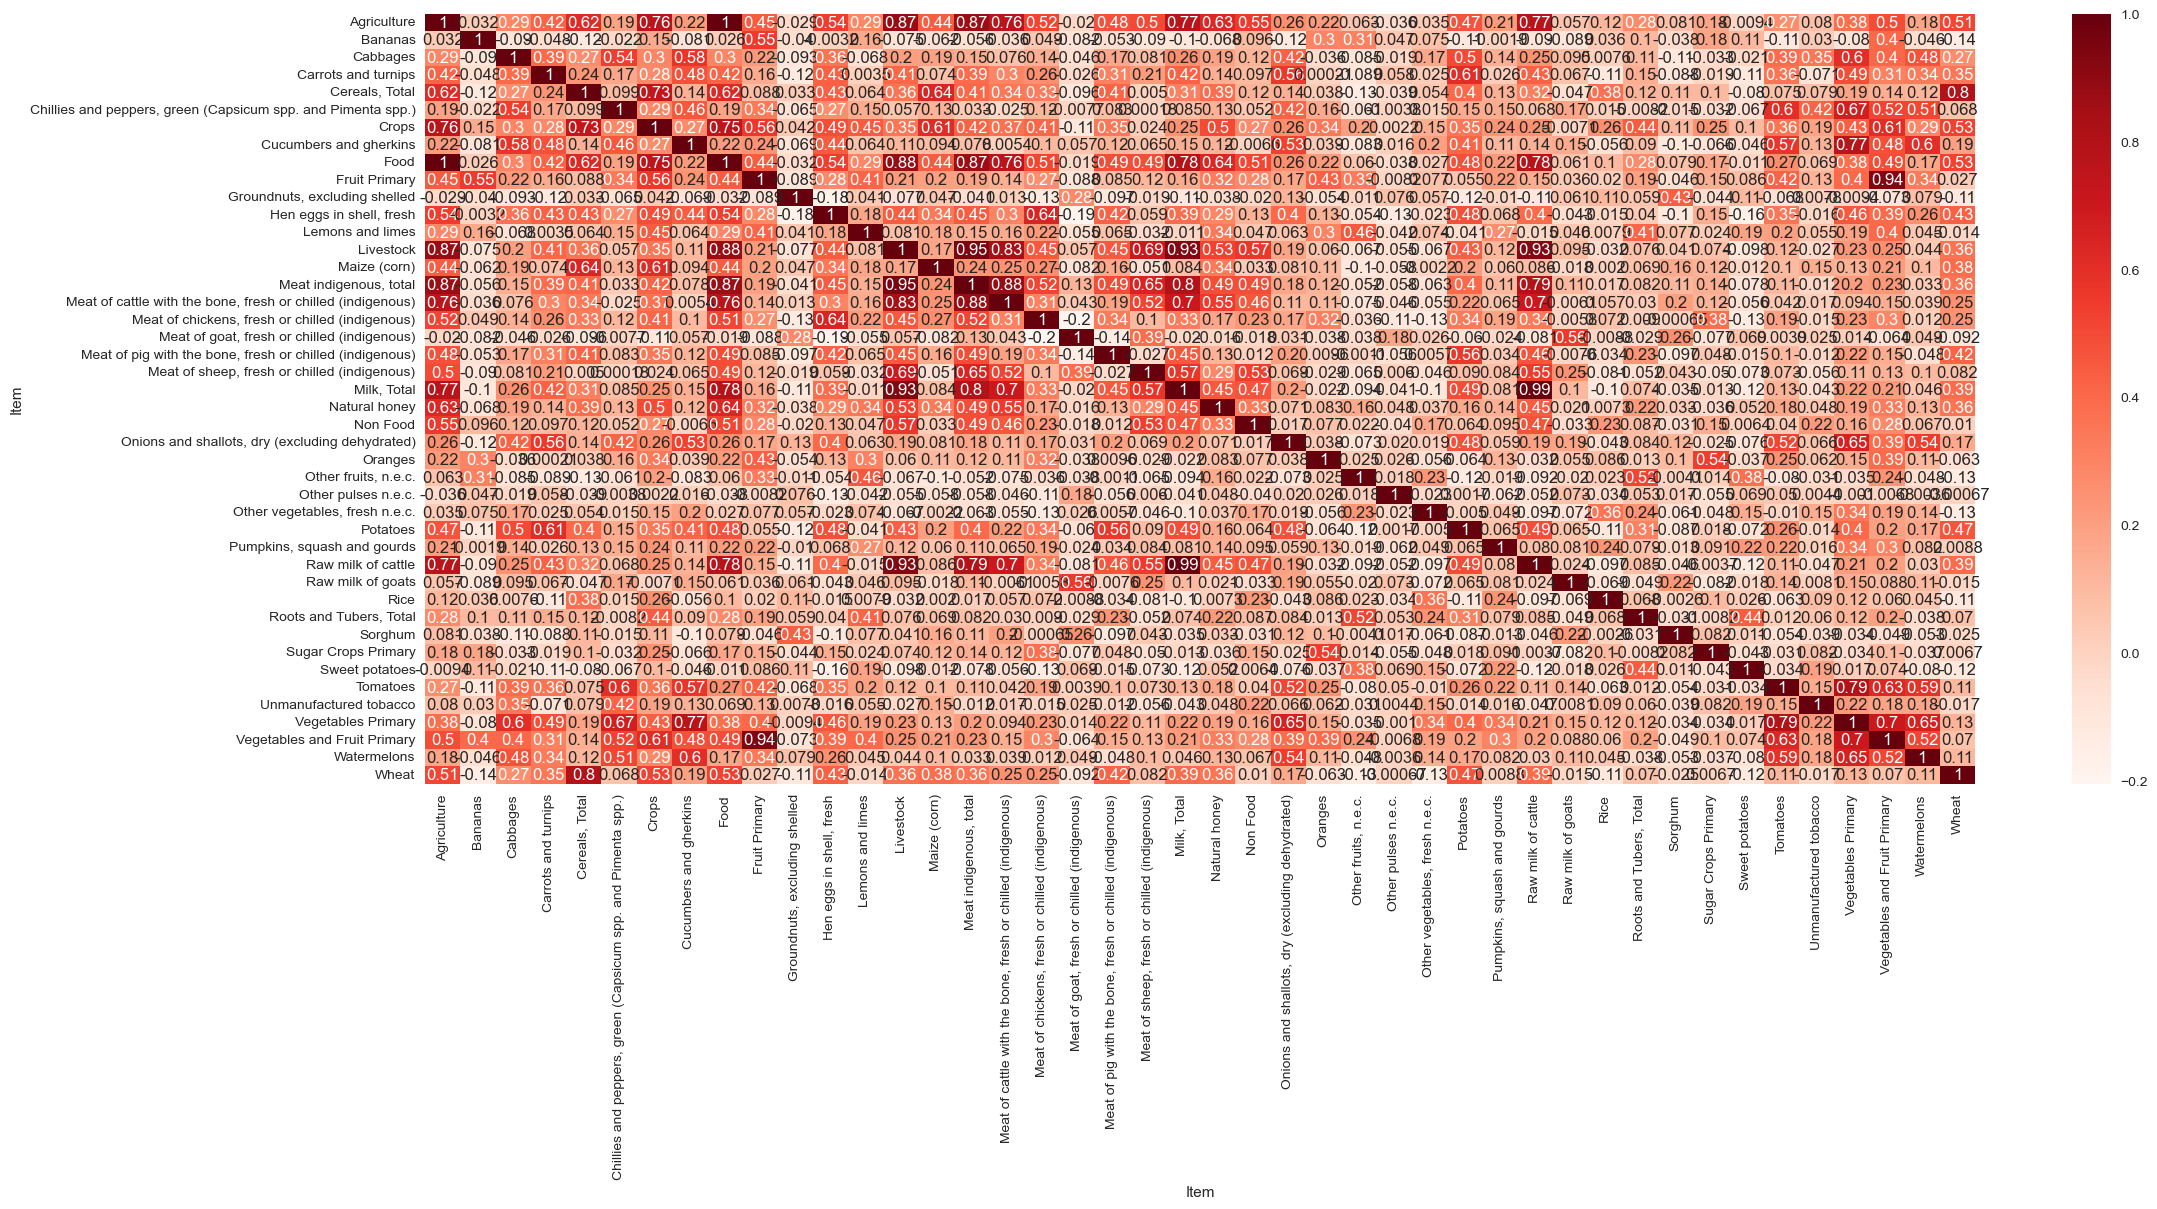

In [191]:
plt.figure(figsize=(25,10))
cor = data_scaled.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

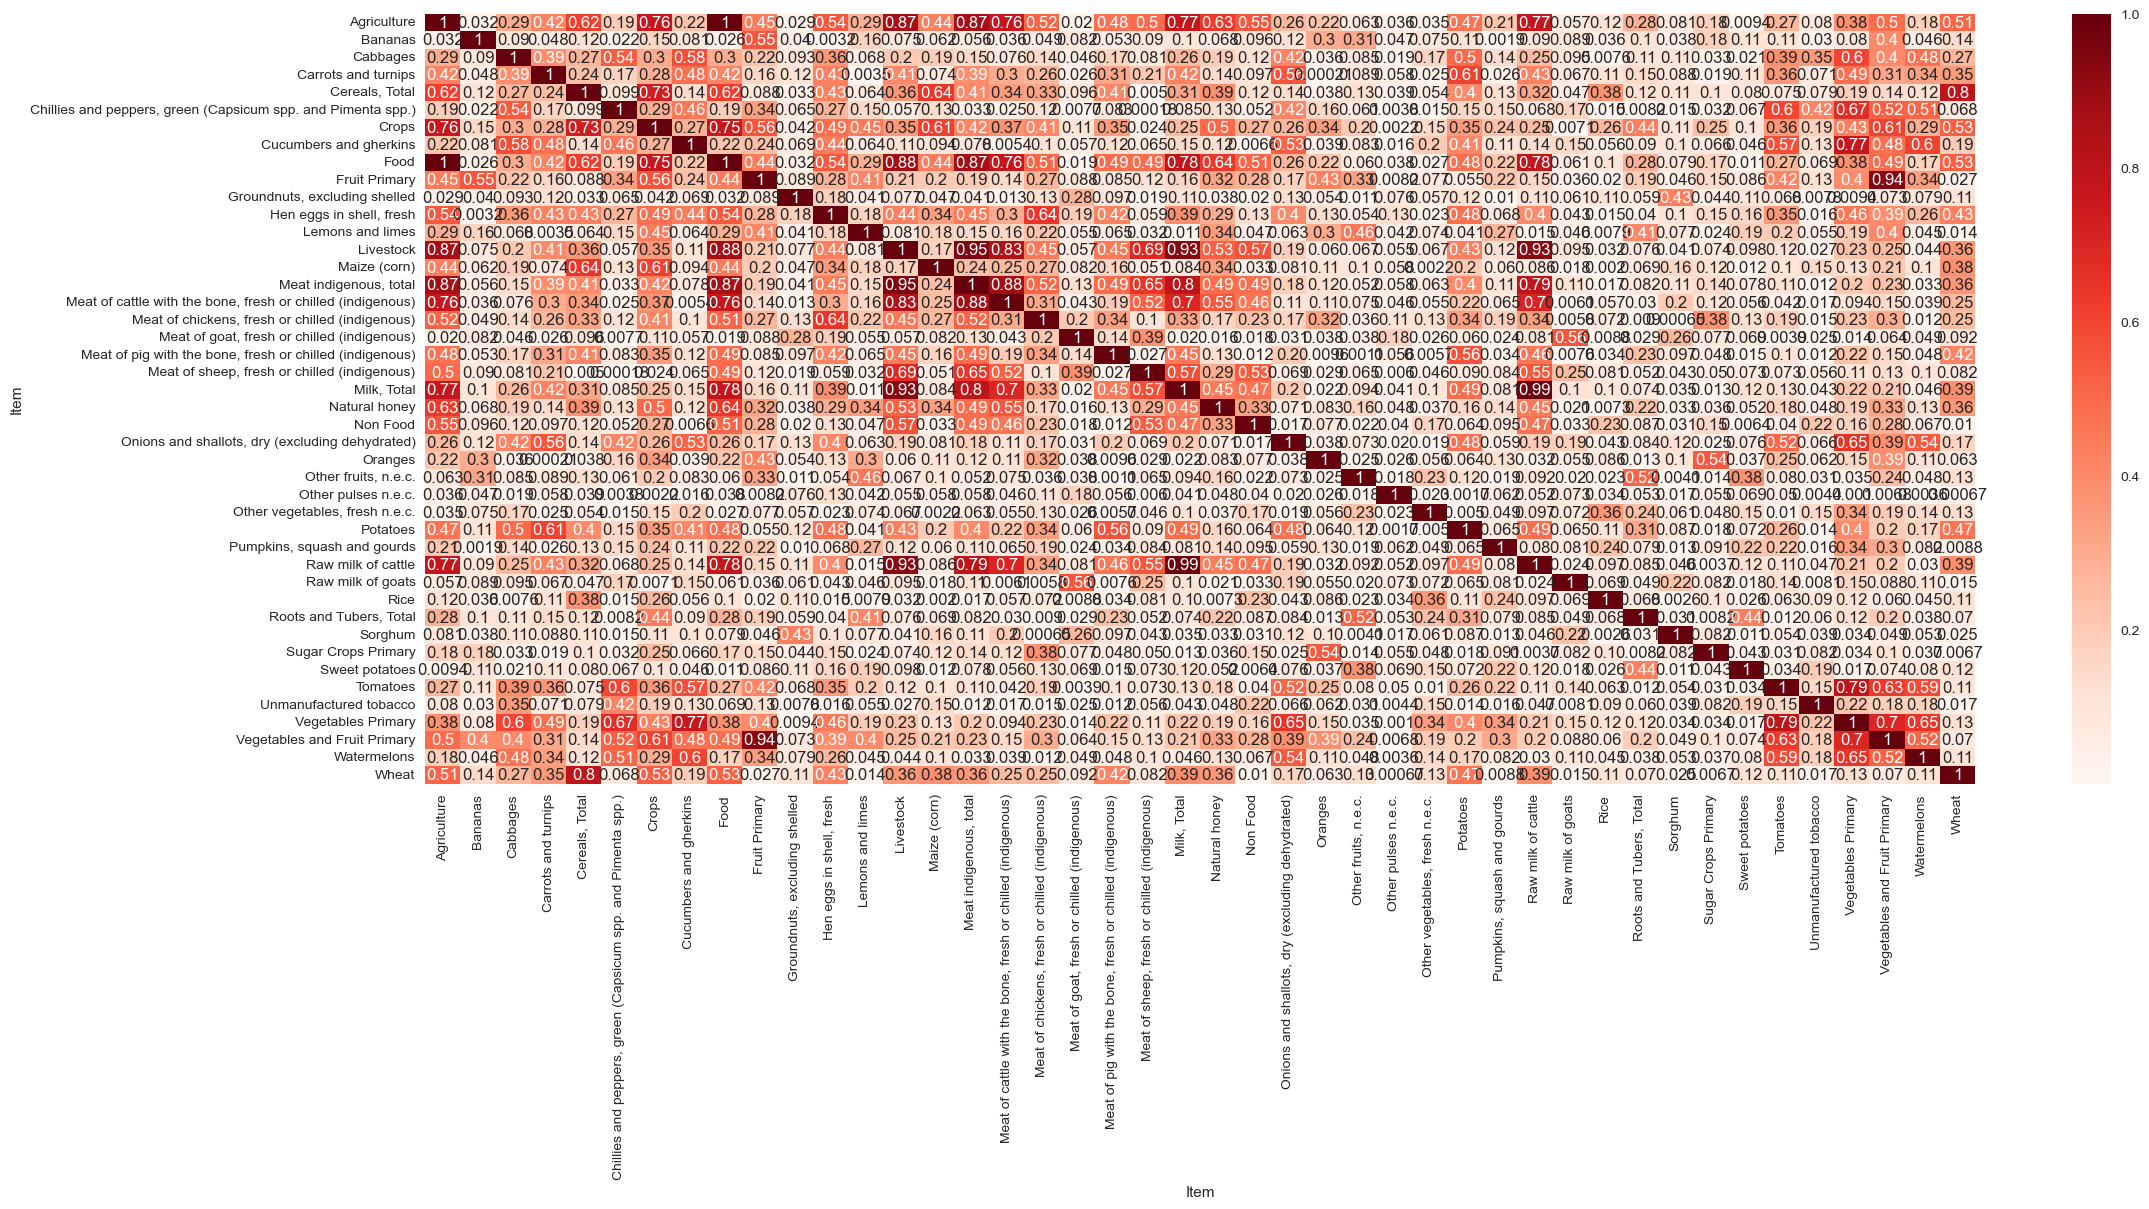

In [240]:
plt.figure(figsize=(25,10))
cor = data_scaled.corr().abs()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [249]:
upper_tri = cor.where(np.triu(np.ones(cor.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.85)]
print(); print(to_drop)
prod_df = prod_df.drop(prod_df.columns[to_drop], axis=1)
#print(); print(prod_df.head())


['Food', 'Livestock', 'Meat indigenous, total', 'Meat of cattle with the bone, fresh or chilled (indigenous)', 'Milk, Total', 'Raw milk of cattle', 'Vegetables and Fruit Primary']


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [251]:
prod_df.columns

Index(['Area', 'Agriculture', 'Bananas', 'Cabbages', 'Carrots and turnips',
       'Cereals, Total',
       'Chillies and peppers, green (Capsicum spp. and Pimenta spp.)', 'Crops',
       'Cucumbers and gherkins', 'Food', 'Fruit Primary',
       'Groundnuts, excluding shelled', 'Hen eggs in shell, fresh',
       'Lemons and limes', 'Livestock', 'Maize (corn)',
       'Meat indigenous, total',
       'Meat of cattle with the bone, fresh or chilled (indigenous)',
       'Meat of chickens, fresh or chilled (indigenous)',
       'Meat of goat, fresh or chilled (indigenous)',
       'Meat of pig with the bone, fresh or chilled (indigenous)',
       'Meat of sheep, fresh or chilled (indigenous)', 'Milk, Total',
       'Natural honey', 'Non Food',
       'Onions and shallots, dry (excluding dehydrated)', 'Oranges',
       'Other fruits, n.e.c.', 'Other pulses n.e.c.',
       'Other vegetables, fresh n.e.c.', 'Potatoes',
       'Pumpkins, squash and gourds', 'Raw milk of cattle',
       'Raw m

In [207]:
codes_df = pd.read_csv(pop_folder /"Population_E_AreaCodes.csv", encoding = 'unicode_escape')

In [214]:
prod_df=prod_df.merge(codes_df, on='Area')

In [215]:
import country_converter as coco
cc = coco.CountryConverter()
prod_df['iso']=cc.pandas_convert(prod_df['Area'], to='ISO3')  

Belgium-Luxembourg not found in regex
2022-12-17 21:20:33.178 WARNING country_converter.country_converter: Belgium-Luxembourg not found in regex
Serbia and Montenegro not found in regex
2022-12-17 21:20:33.336 WARNING country_converter.country_converter: Serbia and Montenegro not found in regex
USSR not found in regex
2022-12-17 21:20:33.360 WARNING country_converter.country_converter: USSR not found in regex
Yugoslav SFR not found in regex
2022-12-17 21:20:33.385 WARNING country_converter.country_converter: Yugoslav SFR not found in regex


In [216]:
pd.set_option('display.max_rows', None)

In [217]:
import plotly.express as px

In [218]:
fig = px.choropleth(prod_df, 
                    locations=prod_df['iso'], 
                    color="cluster_no",
                     hover_name="cluster_no",
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

In [256]:

cluster_ire=prod_df['cluster_no'][prod_df['Area']=='Italy'].values[0]
print("Regions in the same cluster than Ireland: \n")
#use to_string function to remove the "Name", "Dtype" from the output. 
print(prod_df['Area'][prod_df['cluster_no']==cluster_ire].to_string(index=False))

Regions in the same cluster than Ireland: 

                          Belize
                           Chile
                      Costa Rica
                        Dominica
              Dominican Republic
                         Ecuador
                       Guatemala
                          Guyana
                           Italy
                            Niue
Saint Vincent and the Grenadines


In [257]:
prod_df

Area  Agriculture  \
0                                          Afghanistan   174.078401   
1                                              Albania   736.821228   
2                                              Algeria   364.737754   
3                                               Angola   190.689824   
4                                  Antigua and Barbuda    92.230533   
5                                            Argentina  1744.827348   
6                                              Armenia   541.152562   
7                                            Australia  1509.816316   
8                                              Austria   704.273340   
9                                           Azerbaijan   531.992026   
10                                             Bahamas   128.805088   
11                                             Bahrain   124.694483   
12                                          Bangladesh   231.619931   
13                                            Barbados   209.579556   
14                                             Belarus  1167.679849   
15                                             Belgium   811.488191   
16                                  Belgium-Luxembourg     0.000000   
17                                              Belize   626.255799   
18                                               Benin   356.658881   
19                                              Bhutan   367.103650   
20                    Bolivia (Plurinational State of)   598.478770   
21                              Bosnia and Herzegovina   438.977050   
22                                            Botswana   180.201080   
23                                              Brazil  1164.050169   
24                                   Brunei Darussalam   144.938454   
25                                            Bulgaria   766.790991   
26                                        Burkina Faso   214.487993   
27                                             Burundi   227.285037   
28                                          Cabo Verde    81.182954   
29                                            Cambodia   443.759114   
30                                            Cameroon   373.676812   
31                                              Canada  1345.330295   
32                            Central African Republic   282.054831   
33                                                Chad   375.572538   
34                                               Chile   674.320077   
35                                               China   618.103937   
36                                            Colombia   485.741522   
37                                             Comoros   126.400467   
38                                               Congo   116.587530   
39                                        Cook Islands   141.496201   
40                                          Costa Rica   889.709417   
41                                             Croatia   518.899924   
42                                                Cuba   398.622584   
43                                              Cyprus   400.643373   
44                                             Czechia   516.875740   
45                                      Czechoslovakia     0.000000   
46                                       Côte d'Ivoire   478.675498   
47               Democratic People's Republic of Korea   216.177118   
48                    Democratic Republic of the Congo   130.708247   
49                                             Denmark  1654.963407   
50                                            Djibouti    70.175439   
51                                            Dominica   649.675197   
52                                  Dominican Republic   497.333641   
53                                             Ecuador   480.256046   
54                                               Egypt   328.141347   
55                                         El Salvador   254.418597   
56 